<a href="https://colab.research.google.com/github/jongwoonalee/jongwoonalee.github.io/blob/main/bladdder_flexattention_0531_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 1: ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∞è Í∏∞Î≥∏ ÏÑ§Ï†ï
# ========================================================================


In [ ]:

# Ïù¥ ÏÖÄÏùÑ Î®ºÏ†Ä Ïã§ÌñâÌïòÏÑ∏Ïöî - ÌïÑÏöîÌïú Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º import Ìï©ÎãàÎã§
import os
import re
import zipfile
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from skimage.filters import threshold_otsu
import time
import random
import math
import pickle
import hashlib
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

print("‚úÖ Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å!")

# GPU ÏÑ§Ï†ï Î∞è ÌôïÏù∏ - RTX 6000 Ada x2 ÏµúÏ†ÅÌôî
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    num_gpus = torch.cuda.device_count()
    print(f"üöÄ {num_gpus}Í∞úÏùò GPU Î∞úÍ≤¨!")

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        memory_gb = torch.cuda.get_device_properties(i).total_memory / 1024**3
        print(f"   GPU {i}: {gpu_name} ({memory_gb:.1f}GB)")

    # CUDA ÏµúÏ†ÅÌôî ÏÑ§Ï†ï
    torch.backends.cudnn.benchmark = True  # ÎèôÏùºÌïú ÏûÖÎ†• ÌÅ¨Í∏∞Ïóê ÎåÄÌï¥ ÏµúÏ†ÅÌôî
    torch.cuda.empty_cache()               # GPU Î©îÎ™®Î¶¨ Ï†ïÎ¶¨

    print(f"‚úÖ Ï£º ÎîîÎ∞îÏù¥Ïä§: {device}")
else:
    device = torch.device("cpu")
    print("‚ö†Ô∏è  GPUÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. CPU Î™®ÎìúÎ°ú Ïã§ÌñâÎê©ÎãàÎã§.")

print(f"PyTorch Î≤ÑÏ†Ñ: {torch.__version__}")
print(f"CUDA ÏÇ¨Ïö© Í∞ÄÎä•: {torch.cuda.is_available()}")

# Ïû¨ÌòÑ Í∞ÄÎä•Ìïú Í≤∞Í≥ºÎ•º ÏúÑÌïú ÏãúÎìú ÏÑ§Ï†ï
def set_seed(seed=42):
    """
    Î™®Îì† ÎûúÎç§ ÏãúÎìúÎ•º Í≥†Ï†ïÌïòÏó¨ Ïû¨ÌòÑ Í∞ÄÎä•Ìïú Í≤∞Í≥ºÎ•º ÏñªÏäµÎãàÎã§.

    Args:
        seed (int): Í≥†Ï†ïÌï† ÏãúÎìú Í∞í (Í∏∞Î≥∏Í∞í: 42)
    """
    random.seed(seed)              # Python Í∏∞Î≥∏ random
    np.random.seed(seed)           # NumPy random
    torch.manual_seed(seed)        # PyTorch CPU random
    torch.cuda.manual_seed(seed)   # PyTorch GPU random (ÌòÑÏû¨ ÎîîÎ∞îÏù¥Ïä§)
    torch.cuda.manual_seed_all(seed)  # PyTorch Î™®Îì† GPU random

    # ÏôÑÏ†ÑÌïú Ïû¨ÌòÑÏÑ±ÏùÑ ÏúÑÌïú ÏÑ§Ï†ï (ÏÜçÎèÑÍ∞Ä ÏïΩÍ∞Ñ ÎäêÎ†§Ïßà Ïàò ÏûàÏùå)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ÌôòÍ≤Ω Î≥ÄÏàòÎ°úÎèÑ ÏãúÎìú ÏÑ§Ï†ï
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"‚úÖ Î™®Îì† ÎûúÎç§ ÏãúÎìúÎ•º {seed}Î°ú Í≥†Ï†ïÌñàÏäµÎãàÎã§.")

# ÏãúÎìú Í≥†Ï†ï Ïã§Ìñâ
set_seed(42)

# Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Î™®ÎãàÌÑ∞ÎßÅ Ìï®Ïàò
def log_gpu_memory(step_name=""):
    """
    ÌòÑÏû¨ GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§.

    Args:
        step_name (str): ÌòÑÏû¨ Îã®Í≥Ñ Ïù¥Î¶Ñ (Î°úÍ∑∏ Íµ¨Î∂ÑÏö©)
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB Îã®ÏúÑ
        reserved = torch.cuda.memory_reserved() / 1024**3    # GB Îã®ÏúÑ
        max_allocated = torch.cuda.max_memory_allocated() / 1024**3

        print(f"üîç [{step_name}] GPU Î©îÎ™®Î¶¨ - "
              f"ÏÇ¨Ïö©Ï§ë: {allocated:.2f}GB, "
              f"ÏòàÏïΩÎê®: {reserved:.2f}GB, "
              f"ÏµúÎåÄÏÇ¨Ïö©: {max_allocated:.2f}GB")
    else:
        print(f"üîç [{step_name}] CPU Î™®Îìú Ïã§Ìñâ Ï§ë")

# Ï¥àÍ∏∞ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÌôïÏù∏
log_gpu_memory("Ï¥àÍ∏∞ ÏÉÅÌÉú")

print("\n" + "="*80)
print("Part 1 ÏôÑÎ£å: Í∏∞Î≥∏ ÏÑ§Ï†ï Î∞è ÎùºÏù¥Î∏åÎü¨Î¶¨ Ï§ÄÎπÑ ÏôÑÎ£å!")
print("="*80)

‚úÖ Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å!
üöÄ 1Í∞úÏùò GPU Î∞úÍ≤¨!
   GPU 0: NVIDIA GeForce RTX 4060 (8.0GB)
‚úÖ Ï£º ÎîîÎ∞îÏù¥Ïä§: cuda:0
PyTorch Î≤ÑÏ†Ñ: 2.7.0+cu118
CUDA ÏÇ¨Ïö© Í∞ÄÎä•: True
‚úÖ Î™®Îì† ÎûúÎç§ ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÌñàÏäµÎãàÎã§.
üîç [Ï¥àÍ∏∞ ÏÉÅÌÉú] GPU Î©îÎ™®Î¶¨ - ÏÇ¨Ïö©Ï§ë: 0.00GB, ÏòàÏïΩÎê®: 0.00GB, ÏµúÎåÄÏÇ¨Ïö©: 0.00GB

Part 1 ÏôÑÎ£å: Í∏∞Î≥∏ ÏÑ§Ï†ï Î∞è ÎùºÏù¥Î∏åÎü¨Î¶¨ Ï§ÄÎπÑ ÏôÑÎ£å!


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 2: Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
# ========================================================================

In [ ]:


# Ïù¥ ÏÖÄÏùÑ Îëê Î≤àÏß∏Î°ú Ïã§ÌñâÌïòÏÑ∏Ïöî - Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨Ïóê ÌïÑÏöîÌïú Î™®Îì† Ìï®ÏàòÎì§ÏùÑ Ï†ïÏùòÌï©ÎãàÎã§

def extract_identifier(filename):
    """
    ÌååÏùºÎ™ÖÏóêÏÑú ÌôòÏûê IDÎ•º Ï∂îÏ∂úÌïòÎäî Ìï®Ïàò

    Args:
        filename (str): Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎ™Ö (Ïòà: "S123-456.jpg")

    Returns:
        str or None: Ï∂îÏ∂úÎêú ÌôòÏûê ID (Ïòà: "S123000456")
        str: ÌååÏùº ÌôïÏû•Ïûê

    Example:
        extract_identifier("S123-456.jpg") ‚Üí ("S123000456", ".jpg")
    """
    # ÌååÏùºÎ™ÖÍ≥º ÌôïÏû•Ïûê Î∂ÑÎ¶¨
    name, ext = os.path.splitext(filename)

    # ÎåÄÍ¥ÑÌò∏Í∞Ä ÏûàÏúºÎ©¥ Ï†úÍ±∞ (Ïòà: "[comment]" Î∂ÄÎ∂Ñ)
    if '[' in name:
        name = name.split('[')[0].strip()

    # Ìå®ÌÑ¥ 1: SÏà´Ïûê-Ïà´Ïûê ÌòïÌÉú (Ïòà: S123-456)
    m1 = re.match(r'^S(\d+)-(\d+)(?:_\d{4}-\d{2}-\d{2})?', name)
    if m1:
        slide = m1.group(1)      # "123"
        patch = m1.group(2)      # "456"

        # Ìå®Ïπò Î≤àÌò∏Î•º 6ÏûêÎ¶¨Î°ú Ìå®Îî© (ÏïûÏóê 0 Ï∂îÍ∞Ä)
        if len(patch) == 3:
            patch_padded = "000" + patch    # 456 ‚Üí 000456
        elif len(patch) == 4:
            patch_padded = "00" + patch     # 1456 ‚Üí 001456
        elif len(patch) == 5:
            patch_padded = "0" + patch      # 12456 ‚Üí 012456
        else:
            patch_padded = patch            # Ïù¥ÎØ∏ 6ÏûêÎ¶¨Î©¥ Í∑∏ÎåÄÎ°ú

        return f"S{slide}{patch_padded}"

    # Ìå®ÌÑ¥ 2: SÏà´Ïûê, ÌòïÌÉú (Ïòà: S123,)
    m2 = re.match(r'^S(\d+)[,;]', name)
    if m2:
        slide_id = m2.group(1)
        return f"S{slide_id}", ext

    # Ìå®ÌÑ¥ 3: S + 6-8ÏûêÎ¶¨ Ïà´Ïûê (Ïòà: S12345678)
    m3 = re.match(r'^S(\d{8}|\d{7}|\d{6})', name)
    if m3:
        slide_id = m3.group(1)
        return f"S{slide_id}", ext

    # Îß§Ïπ≠ÎêòÏßÄ ÏïäÏúºÎ©¥ None Î∞òÌôò
    return None, ext

def convert_file_id_to_excel_format(file_id):
    """
    ÌååÏùº IDÎ•º ExcelÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî ÌòïÌÉúÎ°ú Î≥ÄÌôò

    Args:
        file_id (str): ÌååÏùºÏóêÏÑú Ï∂îÏ∂úÌïú ID

    Returns:
        str or None: Excel ÌòïÌÉúÎ°ú Î≥ÄÌôòÎêú ID

    Example:
        convert_file_id_to_excel_format("S123-456") ‚Üí "S123000456"
    """
    if file_id is None:
        return None

    file_id = str(file_id).strip()

    # "-"Í∞Ä Ìè¨Ìï®Îêú Í≤ΩÏö∞ (Ïòà: S123-456)
    if "-" in file_id:
        parts = file_id.split("-")
        if len(parts) == 2 and parts[1].isdigit():
            patch = parts[1]

            # Ìå®Ïπò Î≤àÌò∏Î•º 6ÏûêÎ¶¨Î°ú Ìå®Îî©
            if len(patch) == 3:
                padded_number = "000" + patch
            elif len(patch) == 4:
                padded_number = "00" + patch
            elif len(patch) == 5:
                padded_number = "0" + patch
            else:
                padded_number = patch

            return f"{parts[0]}{padded_number}"

    # Ïù¥ÎØ∏ SÎ°ú ÏãúÏûëÌïòÎäî Í∏¥ ÌòïÌÉúÎ©¥ Í∑∏ÎåÄÎ°ú Î∞òÌôò
    elif len(file_id) > 3 and file_id.startswith("S"):
        return file_id

    return None

# Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Îß§Ïπ≠ Ìï®Ïàò (Ïó¨Í∏∞ÏÑúÎäî Ìï®ÏàòÎßå Ï†ïÏùò, Ïã§Ï†ú Î°úÎî©ÏùÄ Îã§Ïùå ÏÖÄÏóêÏÑú)
def load_and_match_data(zip_path, excel_path, base_dir=None):
    """
    ZIP ÌååÏùºÍ≥º Excel ÌååÏùºÏùÑ Îß§Ïπ≠ÌïòÏó¨ ÌôòÏûêÎ≥Ñ Îç∞Ïù¥ÌÑ∞Î•º Íµ¨ÏÑ±ÌïòÎäî Ìï®Ïàò

    Args:
        zip_path (str): Ïù¥ÎØ∏ÏßÄÍ∞Ä Îì§Ïñ¥ÏûàÎäî ZIP ÌååÏùº Í≤ΩÎ°ú
        excel_path (str): ÎùºÎ≤® Ï†ïÎ≥¥Í∞Ä Îì§Ïñ¥ÏûàÎäî Excel ÌååÏùº Í≤ΩÎ°ú
        base_dir (str, optional): ZIP ÏïïÏ∂ï Ìï¥Ï†úÌï† ÎîîÎ†âÌÜ†Î¶¨

    Returns:
        dict: ÌôòÏûêÎ≥ÑÎ°ú Íµ¨ÏÑ±Îêú Îç∞Ïù¥ÌÑ∞ ÎîïÏÖîÎÑàÎ¶¨
        {
            "patient_id": {
                "images": [Ïù¥ÎØ∏ÏßÄÌååÏùºÍ≤ΩÎ°úÎì§],
                "t_label": T-stage ÎùºÎ≤®,
                "recur_label": Ïû¨Î∞ú ÎùºÎ≤®,
                "grade": Îì±Í∏â Ï†ïÎ≥¥,
                ... Í∏∞ÌÉÄ Ï†ïÎ≥¥
            }
        }
    """
    print("üöÄ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Îß§Ïπ≠ ÏãúÏûë...")

    # Excel ÌååÏùº ÏùΩÍ∏∞
    print("üìä Excel ÌååÏùº ÏùΩÎäî Ï§ë...")
    try:
        df = pd.read_excel(excel_path)
        print(f"   ‚úÖ Excel ÌååÏùº Î°úÎìú ÏôÑÎ£å: {len(df)}Í∞ú Ìñâ")
        print(f"   üìã Ïª¨ÎüºÎì§: {list(df.columns)}")
    except Exception as e:
        print(f"   ‚ùå Excel ÌååÏùº ÏùΩÍ∏∞ Ïã§Ìå®: {e}")
        return {}

    # T-stageÏôÄ Ïû¨Î∞ú ÎùºÎ≤® ÏÉùÏÑ±
    print("üè∑Ô∏è  ÎùºÎ≤® Î≥ÄÌôò Ï§ë...")

        # T-stage ÎùºÎ≤®: 1 ‚Üí 0 (Ï†ÄÏúÑÌóò), 2 ‚Üí 1 (Í≥†ÏúÑÌóò)
    second_column = df.columns[1]  # Îëê Î≤àÏß∏ Ïª¨Îüº (Subtype)
    df['t_label'] = df[second_column].apply(
        lambda x: 0 if str(x) == '1' else 1
    )
    t_counts = df['t_label'].value_counts()
    print(f"   üìà T-stage Î∂ÑÌè¨: Ï†ÄÏúÑÌóò(0): {t_counts.get(0, 0)}Í∞ú, Í≥†ÏúÑÌóò(1): {t_counts.get(1, 0)}Í∞ú")

    # Ïû¨Î∞ú ÎùºÎ≤®: No ‚Üí 0, Yes ‚Üí 1
    #if 'Recurrence' in df.columns:
        #df['recur_label'] = df['Recurrence'].apply(
           # lambda x: 0 if str(x).lower() == 'no' else 1
        #)
       # recur_counts = df['recur_label'].value_counts()
      #  print(f"   üîÑ Ïû¨Î∞ú Î∂ÑÌè¨: ÏóÜÏùå(0): {recur_counts.get(0, 0)}Í∞ú, ÏûàÏùå(1): {recur_counts.get(1, 0)}Í∞ú")

    # ZIP ÌååÏùº Ï≤òÎ¶¨
    if base_dir is None:
        base_dir = zip_path.replace('.zip', '')

    print(f"üì¶ ZIP ÌååÏùº Ï≤òÎ¶¨ Ï§ë: {zip_path}")

    # ZIP ÌååÏùºÏù¥ Ïù¥ÎØ∏ ÏïïÏ∂ï Ìï¥Ï†úÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    if not os.path.exists(base_dir):
        print("   üîÑ ZIP ÌååÏùº ÏïïÏ∂ï Ìï¥Ï†ú Ï§ë...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(base_dir))
        print("   ‚úÖ ZIP ÌååÏùº ÏïïÏ∂ï Ìï¥Ï†ú ÏôÑÎ£å")
    else:
        print("   ‚úÖ Ïù¥ÎØ∏ ÏïïÏ∂ï Ìï¥Ï†úÎêú Ìè¥Îçî Î∞úÍ≤¨")

    # Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎì§ Ï∞æÍ∏∞
    print("üîç Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎì§ ÌÉêÏÉâ Ï§ë...")
    image_files = []
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                full_path = os.path.join(root, file)
                image_files.append(full_path)

    print(f"   üì∑ Ï¥ù {len(image_files)}Í∞úÏùò Ïù¥ÎØ∏ÏßÄ ÌååÏùº Î∞úÍ≤¨")

    # ÌååÏùºÎ™ÖÏóêÏÑú ÌôòÏûê ID Ï∂îÏ∂ú Î∞è Îß§Ïπ≠
    print("üîó ÌôòÏûê ID Îß§Ïπ≠ Ï§ë...")
    patient_data = {}
    matched_count = 0
    unmatched_files = []

    for img_path in tqdm(image_files, desc="Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ï≤òÎ¶¨"):
        filename = os.path.basename(img_path)

        # ÌååÏùºÎ™ÖÏóêÏÑú ÌôòÏûê ID Ï∂îÏ∂ú
        file_id, _ = extract_identifier(filename)
        if file_id is None:
            unmatched_files.append(filename)
            continue

        # Excel ÌòïÌÉúÎ°ú Î≥ÄÌôò
        excel_id = convert_file_id_to_excel_format(file_id)
        if excel_id is None:
            unmatched_files.append(filename)
            continue

        # ExcelÏóêÏÑú Ìï¥Îãπ ÌôòÏûê Ï∞æÍ∏∞
        patient_row = df[df.iloc[:, 0].astype(str).str.contains(excel_id, na=False)]

        if len(patient_row) > 0:
            patient_info = patient_row.iloc[0]
            patient_id = str(patient_info.iloc[0])

            # ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï¥àÍ∏∞Ìôî (Ï≤òÏùå Î∞úÍ≤¨Îêú Í≤ΩÏö∞)
            if patient_id not in patient_data:
                patient_data[patient_id] = {
                    'images': [],
                    't_label': patient_info.get('t_label', 0),
                    'recur_label': patient_info.get('recur_label', 0),
                    'grade': patient_info.get('Grade', 'Unknown'),
                    't_stage': patient_info.get('T-stage', 'Unknown'),
                    'recurrence': patient_info.get('Recurrence', 'Unknown')
                }

            # Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Ï∂îÍ∞Ä
            patient_data[patient_id]['images'].append(img_path)
            matched_count += 1
        else:
            unmatched_files.append(filename)

    print(f"   ‚úÖ Îß§Ïπ≠ ÏôÑÎ£å: {matched_count}Í∞ú ÌååÏùº Îß§Ïπ≠")
    print(f"   ‚ö†Ô∏è  Îß§Ïπ≠ Ïã§Ìå®: {len(unmatched_files)}Í∞ú ÌååÏùº")
    print(f"   üë• Ï¥ù ÌôòÏûê Ïàò: {len(patient_data)}Î™Ö")

    # ÌôòÏûêÎ≥Ñ Ïù¥ÎØ∏ÏßÄ Í∞úÏàò ÌÜµÍ≥Ñ
    image_counts = [len(info['images']) for info in patient_data.values()]
    if image_counts:
        print(f"   üìä ÌôòÏûêÎ≥Ñ Ïù¥ÎØ∏ÏßÄ Í∞úÏàò - ÌèâÍ∑†: {np.mean(image_counts):.1f}Í∞ú, "
              f"ÏµúÏÜå: {min(image_counts)}Í∞ú, ÏµúÎåÄ: {max(image_counts)}Í∞ú")

    # Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ ÌååÏùº ÏùºÎ∂Ä Ï∂úÎ†• (ÎîîÎ≤ÑÍπÖÏö©)
    if unmatched_files:
        print(f"   üìù Îß§Ïπ≠ Ïã§Ìå® ÌååÏùº ÏòàÏãú (Ï≤òÏùå 5Í∞ú):")
        for file in unmatched_files[:5]:
            print(f"      - {file}")

    print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Îß§Ïπ≠ ÏôÑÎ£å!")
    return patient_data

print("\n" + "="*80)
print("Part 2 ÏôÑÎ£å: Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Ìï®ÏàòÎì§ Ï†ïÏùò ÏôÑÎ£å!")
print("Îã§ÏùåÏúºÎ°ú Part 3ÏóêÏÑú Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎî©Ìï©ÎãàÎã§.")
print("="*80)


Part 2 ÏôÑÎ£å: Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Ìï®ÏàòÎì§ Ï†ïÏùò ÏôÑÎ£å!
Îã§ÏùåÏúºÎ°ú Part 3ÏóêÏÑú Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎî©Ìï©ÎãàÎã§.


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 3: Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨ ÌïµÏã¨ Ìï®ÏàòÎì§
# ========================================================================

In [ ]:


# Ïù¥ ÏÖÄÏùÑ ÏÑ∏ Î≤àÏß∏Î°ú Ïã§ÌñâÌïòÏÑ∏Ïöî - FlexAttentionÏùò ÌïµÏã¨Ïù∏ Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨ Ìï®ÏàòÎì§ÏùÑ Ï†ïÏùòÌï©ÎãàÎã§

def split_megapatch_to_patches(megapatch_path, grid_size=4):
    """
    üî™ STEP 1: 1024x1024 Î©îÍ∞ÄÌå®ÏπòÎ•º 4x4=16Í∞úÏùò 256x256 Ìå®ÏπòÎ°ú Î∂ÑÌï†

    FlexAttention ÎÖºÎ¨∏Ïùò ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥:
    - ÌÅ∞ Ïù¥ÎØ∏ÏßÄÎ•º ÏûëÏùÄ Ìå®ÏπòÎì§Î°ú ÎÇòÎàÑÏñ¥ Ï≤òÎ¶¨
    - Í∞Å Ìå®ÏπòÎäî ÎèôÏùºÌïú ÌÅ¨Í∏∞Î°ú Ï†ïÍ∑úÌôî

    Args:
        megapatch_path (str): 1024x1024 Î©îÍ∞ÄÌå®Ïπò Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú
        grid_size (int): Í∑∏Î¶¨Îìú ÌÅ¨Í∏∞ (4x4 = 16Í∞ú Ìå®Ïπò, 3x3 = 9Í∞ú Ìå®Ïπò Îì±)

    Returns:
        list: 16Í∞úÏùò 256x256 Ìå®ÏπòÎì§ (numpy arrays)
        list: Í∞Å Ìå®ÏπòÏùò ÏúÑÏπò Ï†ïÎ≥¥ [(i, j), ...]

    Example:
        patches, positions = split_megapatch_to_patches("image.jpg", 4)
        # patches[0]: Ï¢åÏÉÅÎã® Ìå®Ïπò, patches[15]: Ïö∞ÌïòÎã® Ìå®Ïπò
        # positions[0]: (0, 0), positions[15]: (3, 3)
    """
    # 1024x1024 Î©îÍ∞ÄÌå®Ïπò ÏùΩÍ∏∞
    megapatch = cv2.imread(megapatch_path)
    if megapatch is None:
        raise ValueError(f"‚ùå Î©îÍ∞ÄÌå®ÏπòÎ•º ÏùΩÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {megapatch_path}")

    # BGR ‚Üí RGB Î≥ÄÌôò (OpenCVÎäî BGR, Ïö∞Î¶¨Îäî RGB ÏÇ¨Ïö©)
    megapatch = cv2.cvtColor(megapatch, cv2.COLOR_BGR2RGB)
    h, w = megapatch.shape[:2]

    # Í∞Å Ìå®Ïπò ÌÅ¨Í∏∞ Í≥ÑÏÇ∞: 1024/4 = 256
    patch_size = h // grid_size  # 256x256

    patches = []      # Î∂ÑÌï†Îêú Ìå®ÏπòÎì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    positions = []    # Í∞Å Ìå®ÏπòÏùò ÏúÑÏπò Ï†ïÎ≥¥Î•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏

    # 4x4 Í∑∏Î¶¨ÎìúÎ°ú Î∂ÑÌï† (ÏôºÏ™Ω ÏúÑÎ∂ÄÌÑ∞ Ïò§Î•∏Ï™Ω ÏïÑÎûòÎ°ú)
    for i in range(grid_size):        # ÏÑ∏Î°ú Î∞©Ìñ• (Ìñâ)
        for j in range(grid_size):    # Í∞ÄÎ°ú Î∞©Ìñ• (Ïó¥)
            # Ìå®ÏπòÏùò ÏãúÏûëÏ†êÍ≥º ÎÅùÏ†ê Í≥ÑÏÇ∞
            y_start = i * patch_size      # ÏÑ∏Î°ú ÏãúÏûë ÏúÑÏπò
            x_start = j * patch_size      # Í∞ÄÎ°ú ÏãúÏûë ÏúÑÏπò
            y_end = y_start + patch_size  # ÏÑ∏Î°ú ÎÅù ÏúÑÏπò
            x_end = x_start + patch_size  # Í∞ÄÎ°ú ÎÅù ÏúÑÏπò

            # 256x256 Ìå®Ïπò Ï∂îÏ∂ú
            patch = megapatch[y_start:y_end, x_start:x_end]
            patches.append(patch)
            positions.append((i, j))  # (Ìñâ, Ïó¥) ÏúÑÏπò Ï†ÄÏû•

    return patches, positions

def create_three_streams_from_patch(patch_256, megapatch_1024):
    """
    üéØ STEP 2: Í∞Å 256x256 Ìå®ÏπòÎ°úÎ∂ÄÌÑ∞ 3-stream ÏÉùÏÑ± (ÏàòÏ†ïÎê®!)

    FlexAttentionÏùò 3-stream Íµ¨Ï°∞:
    1. LR (Low Resolution): Îπ†Î•∏ Ï≤òÎ¶¨Î•º ÏúÑÌïú 64x64 Ï†ÄÌï¥ÏÉÅÎèÑ ‚Üê ÏàòÏ†ï!
    2. HR (High Resolution): ÏÑ∏Î∞ÄÌïú Î∂ÑÏÑùÏùÑ ÏúÑÌïú 256x256 Í≥†Ìï¥ÏÉÅÎèÑ
    3. Global: Ï†ÑÏ≤¥ Îß•ÎùΩÏùÑ ÏúÑÌïú 64x64 Í∏ÄÎ°úÎ≤å Ïª®ÌÖçÏä§Ìä∏

    Args:
        patch_256 (numpy.ndarray): 256x256 Ìå®Ïπò (numpy array)
        megapatch_1024 (numpy.ndarray): Ï†ÑÏ≤¥ 1024x1024 Î©îÍ∞ÄÌå®Ïπò (Global ÏÉùÏÑ±Ïö©)

    Returns:
        dict: {
            'lr': 64x64 LR Ìå®Ïπò,
            'hr': 256x256 HR Ìå®Ïπò (ÏõêÎ≥∏),
            'global': 64x64 Global Ïª®ÌÖçÏä§Ìä∏
        }
    """
    # 1. LR Ïä§Ìä∏Î¶º: 256x256 ‚Üí 64x64 Îã§Ïö¥ÏÉòÌîåÎßÅ (ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ!)
    # INTER_AREA: Ï∂ïÏÜåÏãú ÌíàÏßàÏù¥ Ï¢ãÏùÄ Î≥¥Í∞ÑÎ≤ï
    lr_patch = cv2.resize(patch_256, (64, 64), interpolation=cv2.INTER_AREA)  # ‚Üê Ïù¥Í≤ÉÏù¥ ÌïµÏã¨ ÏàòÏ†ï!

    # 2. HR Ïä§Ìä∏Î¶º: 256x256 ÏõêÎ≥∏ Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©
    # ÏÑ∏Î∞ÄÌïú ÌäπÏßïÏùÑ Î∂ÑÏÑùÌïòÍ∏∞ ÏúÑÌï¥ ÏõêÎ≥∏ Ìï¥ÏÉÅÎèÑ Ïú†ÏßÄ
    hr_patch = patch_256.copy()

    # 3. Global Ïä§Ìä∏Î¶º: Ï†ÑÏ≤¥ 1024x1024 ‚Üí 64x64 (Îß§Ïö∞ ÏûëÏùÄ overview)
    # Ï†ÑÏ≤¥Ï†ÅÏù∏ Íµ¨Ï°∞ÏôÄ Îß•ÎùΩ Ï†ïÎ≥¥Î•º Ï†úÍ≥µ
    global_context = cv2.resize(megapatch_1024, (64, 64), interpolation=cv2.INTER_AREA)

    return {
        'lr': lr_patch,         # 64x64 LR (Îπ†Î•∏ Ï≤òÎ¶¨Ïö©) ‚Üê Ïù¥Ï†ú Ïò¨Î∞îÎ•∏ ÌÅ¨Í∏∞!
        'hr': hr_patch,         # 256x256 HR (ÏÑ∏Î∞ÄÌïú Î∂ÑÏÑùÏö©)
        'global': global_context # 64x64 Global (Îß•ÎùΩ Ï†ïÎ≥¥Ïö©)
    }

def process_megapatch_complete(megapatch_path, patches_per_megapatch=16):
    """
    üöÄ STEP 3: Î©îÍ∞ÄÌå®Ïπò Ï†ÑÏ≤¥ Ï≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏

    Ï†ÑÏ≤¥ Í≥ºÏ†ï:
    1024x1024 Î©îÍ∞ÄÌå®Ïπò ‚Üí 16Í∞ú Ìå®ÏπòÎ°ú Î∂ÑÌï† ‚Üí Í∞ÅÍ∞Å 3-stream ÏÉùÏÑ±

    Args:
        megapatch_path (str): 1024x1024 Î©îÍ∞ÄÌå®Ïπò Í≤ΩÎ°ú
        patches_per_megapatch (int): Î©îÍ∞ÄÌå®ÏπòÎãπ Ìå®Ïπò Í∞úÏàò (16 or 8 Îì±)

    Returns:
        dict: {
            'lr_patches': 16Í∞úÏùò 64x64 LR Ìå®ÏπòÎì§,
            'hr_patches': 16Í∞úÏùò 256x256 HR Ìå®ÏπòÎì§,
            'global_tokens': 16Í∞úÏùò 64x64 Global ÌÜ†ÌÅ∞Îì§ (Î™®Îëê ÎèôÏùº),
            'positions': Ìå®Ïπò ÏúÑÏπò Ï†ïÎ≥¥ [(i,j), ...]
        }
    """
    # ÏõêÎ≥∏ Î©îÍ∞ÄÌå®Ïπò ÏùΩÍ∏∞
    megapatch = cv2.imread(megapatch_path)
    if megapatch is None:
        raise ValueError(f"‚ùå Î©îÍ∞ÄÌå®ÏπòÎ•º ÏùΩÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {megapatch_path}")
    megapatch = cv2.cvtColor(megapatch, cv2.COLOR_BGR2RGB)

    # patches_per_megapatchÏóê Îî∞Îùº grid_size Í≤∞Ï†ï
    if patches_per_megapatch == 16:
        grid_size = 4    # 4x4 = 16
    elif patches_per_megapatch == 9:
        grid_size = 3    # 3x3 = 9
    elif patches_per_megapatch == 8:
        # 8Í∞úÎäî ÌäπÎ≥Ñ Ï≤òÎ¶¨: 4x4ÏóêÏÑú 8Í∞úÎßå ÏÑ†ÌÉù
        grid_size = 4
        use_subset = True
    else:
        grid_size = int(math.sqrt(patches_per_megapatch))
        use_subset = False

    # STEP 1: 1024x1024 ‚Üí Ïó¨Îü¨Í∞ú 256x256 Ìå®ÏπòÎ°ú Î∂ÑÌï†
    patches_256, positions = split_megapatch_to_patches(megapatch_path, grid_size)

    # 8Í∞úÎßå ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞: Ï≤¥Ïä§Ìåê Ìå®ÌÑ¥ÏúºÎ°ú ÏÑ†ÌÉù (Í∑†Îì± Î∂ÑÌè¨)
    if patches_per_megapatch == 8 and len(patches_256) == 16:
        # Ï≤¥Ïä§Ìåê Ìå®ÌÑ¥: (0,0), (0,2), (1,1), (1,3), (2,0), (2,2), (3,1), (3,3)
        selected_indices = []
        for i, (row, col) in enumerate(positions):
            if (row + col) % 2 == 0:  # Ï≤¥Ïä§Ìåê Ìå®ÌÑ¥
                selected_indices.append(i)

        # 8Í∞úÎßå ÏÑ†ÌÉù
        selected_indices = selected_indices[:patches_per_megapatch]
        patches_256 = [patches_256[i] for i in selected_indices]
        positions = [positions[i] for i in selected_indices]

    # STEP 2: Í∞Å Ìå®ÏπòÎ≥ÑÎ°ú 3-stream ÏÉùÏÑ±
    lr_patches = []       # LR Ìå®ÏπòÎì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    hr_patches = []       # HR Ìå®ÏπòÎì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    global_tokens = []    # Global ÌÜ†ÌÅ∞Îì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏

    for patch_256 in patches_256:
        # Í∞Å Ìå®ÏπòÏóê ÎåÄÌï¥ 3-stream ÏÉùÏÑ±
        streams = create_three_streams_from_patch(patch_256, megapatch)

        lr_patches.append(streams['lr'])        # 64x64 LR
        hr_patches.append(streams['hr'])        # 256x256 HR
        global_tokens.append(streams['global']) # 64x64 Global

        # Ï∞∏Í≥†: global_tokensÎäî Î™®Îëê ÎèôÏùºÌïú Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄÏùò Ï∂ïÏÜåÎ≥∏ÏûÖÎãàÎã§

    return {
        'lr_patches': lr_patches,     # patches_per_megapatchÍ∞ú √ó 64x64
        'hr_patches': hr_patches,     # patches_per_megapatchÍ∞ú √ó 256x256
        'global_tokens': global_tokens, # patches_per_megapatchÍ∞ú √ó 64x64 (Î™®Îëê ÎèôÏùº)
        'positions': positions        # patches_per_megapatchÍ∞ú ÏúÑÏπò Ï†ïÎ≥¥
    }

# ÌÖåÏä§Ìä∏ Î∞è ÏãúÍ∞ÅÌôî Ìï®Ïàò
def visualize_patch_splitting(megapatch_path, save_path=None):
    """
    üìä Î©îÍ∞ÄÌå®Ïπò Î∂ÑÌï† Í≥ºÏ†ïÏùÑ ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò (ÎîîÎ≤ÑÍπÖ Î∞è ÌôïÏù∏Ïö©)

    Args:
        megapatch_path (str): ÏãúÍ∞ÅÌôîÌï† Î©îÍ∞ÄÌå®Ïπò Í≤ΩÎ°ú
        save_path (str, optional): Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû• Í≤ΩÎ°ú
    """
    try:
        # Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨
        processed = process_megapatch_complete(megapatch_path)

        # ÏãúÍ∞ÅÌôî ÏÑ§Ï†ï
        fig, axes = plt.subplots(4, 6, figsize=(18, 12))
        fig.suptitle(f'Î©îÍ∞ÄÌå®Ïπò Î∂ÑÌï† Í≤∞Í≥º: {os.path.basename(megapatch_path)}', fontsize=16)

        # ÏõêÎ≥∏ Î©îÍ∞ÄÌå®Ïπò ÌëúÏãú
        megapatch = cv2.imread(megapatch_path)
        megapatch = cv2.cvtColor(megapatch, cv2.COLOR_BGR2RGB)
        axes[0, 0].imshow(megapatch)
        axes[0, 0].set_title('ÏõêÎ≥∏ Î©îÍ∞ÄÌå®Ïπò\n(1024x1024)', fontsize=10)
        axes[0, 0].axis('off')

        # Ï≤òÏùå 5Í∞ú Ìå®ÏπòÏùò 3-stream ÌëúÏãú
        for i in range(min(5, len(processed['lr_patches']))):
            row = i // 5 + 1
            col_start = (i % 5) + 1

            # LR Ìå®Ïπò (64x64)
            axes[0, col_start].imshow(processed['lr_patches'][i])
            axes[0, col_start].set_title(f'LR {i+1}\n(64x64)', fontsize=8)
            axes[0, col_start].axis('off')

            # HR Ìå®Ïπò (256x256)
            axes[1, col_start].imshow(processed['hr_patches'][i])
            axes[1, col_start].set_title(f'HR {i+1}\n(256x256)', fontsize=8)
            axes[1, col_start].axis('off')

            # Global ÌÜ†ÌÅ∞ (64x64)
            axes[2, col_start].imshow(processed['global_tokens'][i])
            axes[2, col_start].set_title(f'Global {i+1}\n(64x64)', fontsize=8)
            axes[2, col_start].axis('off')

        # Îπà subplotÎì§ Ïà®Í∏∞Í∏∞
        for i in range(4):
            for j in range(6):
                if i > 2 or (i == 0 and j == 0) or (i > 0 and j == 0):
                    continue
                if not axes[i, j].has_data():
                    axes[i, j].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"‚úÖ ÏãúÍ∞ÅÌôî Í≤∞Í≥º Ï†ÄÏû•: {save_path}")

        plt.show()

        # ÌÜµÍ≥Ñ Ï†ïÎ≥¥ Ï∂úÎ†•
        print(f"üìä Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨ Í≤∞Í≥º:")
        print(f"   - LR Ìå®Ïπò Í∞úÏàò: {len(processed['lr_patches'])}Í∞ú (Í∞Å 64x64)")
        print(f"   - HR Ìå®Ïπò Í∞úÏàò: {len(processed['hr_patches'])}Í∞ú (Í∞Å 256x256)")
        print(f"   - Global ÌÜ†ÌÅ∞ Í∞úÏàò: {len(processed['global_tokens'])}Í∞ú (Í∞Å 64x64)")
        print(f"   - ÏúÑÏπò Ï†ïÎ≥¥: {processed['positions'][:5]}... (Ï≤òÏùå 5Í∞ú)")

    except Exception as e:
        print(f"‚ùå ÏãúÍ∞ÅÌôî Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")

print("\n" + "="*80)
print("Part 3 ÏôÑÎ£å: Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨ ÌïµÏã¨ Ìï®ÏàòÎì§ Ï†ïÏùò ÏôÑÎ£å!")
print("Ïù¥Ï†ú 1024x1024 Ïù¥ÎØ∏ÏßÄÎ•º 16Í∞úÏùò 3-stream Ìå®ÏπòÎ°ú Î∂ÑÌï†Ìï† Ïàò ÏûàÏäµÎãàÎã§.")
print("="*80)


Part 3 ÏôÑÎ£å: Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨ ÌïµÏã¨ Ìï®ÏàòÎì§ Ï†ïÏùò ÏôÑÎ£å!
Ïù¥Ï†ú 1024x1024 Ïù¥ÎØ∏ÏßÄÎ•º 16Í∞úÏùò 3-stream Ìå®ÏπòÎ°ú Î∂ÑÌï†Ìï† Ïàò ÏûàÏäµÎãàÎã§.


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 4: Feature ExtractorÏôÄ HR Selection
# ========================================================================

In [ ]:


# Ïù¥ ÏÖÄÏùÑ ÎÑ§ Î≤àÏß∏Î°ú Ïã§ÌñâÌïòÏÑ∏Ïöî - ResNet Í∏∞Î∞ò feature extractorÏôÄ ÎÖºÎ¨∏Ïùò threshold Î∞©Ïãù HR selectionÏùÑ Íµ¨ÌòÑÌï©ÎãàÎã§

class ResNetFeatureExtractor(nn.Module):
    """
    üî¨ ResNet18 Í∏∞Î∞ò Feature Extractor

    Ïó≠Ìï†:
    - 64x64 Ïù¥ÎØ∏ÏßÄÏö© (LR, Global streams)
    - 256x256 Ïù¥ÎØ∏ÏßÄÏö© (HR stream)
    - Ïù¥ÎØ∏ÏßÄÎ•º Í≥†Ï†ï ÌÅ¨Í∏∞ feature vectorÎ°ú Î≥ÄÌôò

    ÏÑ†ÌÉùÏßÄ:
    - ResNet18: ÏïàÏ†ïÏ†ÅÏù¥Í≥† Í≤ÄÏ¶ùÎêú ÏÑ±Îä• (Ï∂îÏ≤ú)
    - MobileNetV3: Îçî Îπ†Î•¥ÏßÄÎßå ÏÑ±Îä• ÏïΩÍ∞Ñ ÎÇÆÏùå
    """

    def __init__(self, feature_dim=256, model_type='resnet18', pretrained=True):
        """
        Args:
            feature_dim (int): Ï∂úÎ†• feature Ï∞®Ïõê (256 or 384)
            model_type (str): ÏÇ¨Ïö©Ìï† Î∞±Î≥∏ Î™®Îç∏ ('resnet18', 'mobilenet', 'efficientnet')
            pretrained (bool): ImageNet ÏÇ¨Ï†ÑÌõàÎ†® Í∞ÄÏ§ëÏπò ÏÇ¨Ïö© Ïó¨Î∂Ä
        """
        super(ResNetFeatureExtractor, self).__init__()

        self.feature_dim = feature_dim
        self.model_type = model_type

        # Î∞±Î≥∏ Î™®Îç∏ ÏÑ†ÌÉù Î∞è ÏÑ§Ï†ï
        if model_type == 'resnet18':
            # ResNet18: ÏïàÏ†ïÏ†ÅÏù¥Í≥† ÎÑêÎ¶¨ ÏÇ¨Ïö©Îê® (11M parameters)
            resnet = models.resnet18(pretrained=pretrained)
            self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # avgpool, fc Ï†úÍ±∞
            backbone_out_dim = 512

        elif model_type == 'mobilenet':
            # MobileNetV3-Small: Îπ†Î•¥Í≥† Í≤ΩÎüâ (2.5M parameters)
            from torchvision.models import mobilenet_v3_small
            mobilenet = mobilenet_v3_small(pretrained=pretrained)
            self.backbone = mobilenet.features
            backbone_out_dim = 576

        elif model_type == 'efficientnet':
            # EfficientNet-B0: Ìö®Ïú®Ï†ÅÏù¥Í≥† ÏÑ±Îä• Ï¢ãÏùå (5.3M parameters)
            from torchvision.models import efficientnet_b0
            efficientnet = efficientnet_b0(pretrained=pretrained)
            self.backbone = efficientnet.features
            backbone_out_dim = 1280

        else:
            raise ValueError(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî Î™®Îç∏ ÌÉÄÏûÖ: {model_type}")

        # Global Average Pooling: spatial dimensionsÎ•º 1x1Î°ú Ï∂ïÏÜå
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Feature projection: backbone output ‚Üí ÏõêÌïòÎäî feature dimension
        self.projection = nn.Sequential(
            nn.Linear(backbone_out_dim, feature_dim),
            nn.LayerNorm(feature_dim),  # Layer NormalizationÏúºÎ°ú ÏïàÏ†ïÏÑ± Ìñ•ÏÉÅ
            nn.ReLU(),
            nn.Dropout(0.1)             # 10% ÎìúÎ°≠ÏïÑÏõÉÏúºÎ°ú overfitting Î∞©ÏßÄ
        )

        print(f"‚úÖ {model_type.upper()} Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
        print(f"   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: {backbone_out_dim}")
        print(f"   - ÏµúÏ¢Ö feature Ï∞®Ïõê: {feature_dim}")

    def forward(self, x):
        """
        Forward pass: Ïù¥ÎØ∏ÏßÄ Î∞∞ÏπòÎ•º feature vectorsÎ°ú Î≥ÄÌôò

        Args:
            x: [batch_size, 3, H, W] - RGB Ïù¥ÎØ∏ÏßÄ Î∞∞Ïπò
               H, WÎäî 64 (LR, Global) ÎòêÎäî 256 (HR)

        Returns:
            [batch_size, feature_dim] - Ï∂îÏ∂úÎêú feature vectors
        """
        # 1. Î∞±Î≥∏ ÎÑ§Ìä∏ÏõåÌÅ¨Î•º ÌÜµÌïú feature map Ï∂îÏ∂ú
        features = self.backbone(x)      # [B, C, H', W'] - Ïòà: [B, 512, H'/32, W'/32]

        # 2. Global Average PoolingÏúºÎ°ú spatial dimensions Ï∂ïÏÜå
        pooled = self.avgpool(features)  # [B, C, 1, 1]

        # 3. Flatten: [B, C, 1, 1] ‚Üí [B, C]
        flattened = pooled.view(pooled.size(0), -1)  # [B, backbone_out_dim]

        # 4. ProjectionÏùÑ ÌÜµÌï¥ ÏõêÌïòÎäî Ï∞®ÏõêÏúºÎ°ú Î≥ÄÌôò
        projected = self.projection(flattened)       # [B, feature_dim]

        return projected


class ThresholdBasedHRSelector(nn.Module):
    """
    üéØ ÎÖºÎ¨∏Ïùò Ï†ïÌôïÌïú Î∞©Ïãù: Threshold Í∏∞Î∞ò HR Feature Selection

    FlexAttention ÎÖºÎ¨∏Ïùò ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥:
    - LR attention scoresÏóêÏÑú thresholdÎ•º Í≥ÑÏÇ∞
    - Threshold Ïù¥ÏÉÅÏù∏ Ìå®ÏπòÎì§Îßå HRÎ°ú ÏÑ†ÌÉù
    - ÏïΩ 10% Ï†ïÎèÑÍ∞Ä ÏÑ†ÌÉùÎêòÎèÑÎ°ù ÎèôÏ†Å Ï°∞Ï†ï
    - Top-K Í≥†Ï†ï ÏÑ†ÌÉùÏù¥ ÏïÑÎãå Ïã§Ï†ú Ï§ëÏöîÎèÑ Í∏∞Î∞ò ÏÑ†ÌÉù
    """

    def __init__(self, target_selection_ratio=0.1, min_patches=1, max_patches=4):
        """
        Args:
            target_selection_ratio (float): Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú® (0.1 = ÏïΩ 10%)
            min_patches (int): ÏµúÏÜå ÏÑ†ÌÉù Ìå®Ïπò Í∞úÏàò (ÎÑàÎ¨¥ Ï†ÅÏúºÎ©¥ Í∞ïÏ†ú ÏÑ†ÌÉù)
            max_patches (int): ÏµúÎåÄ ÏÑ†ÌÉù Ìå®Ïπò Í∞úÏàò (ÎÑàÎ¨¥ ÎßéÏúºÎ©¥ Ï†úÌïú)
        """
        super(ThresholdBasedHRSelector, self).__init__()
        self.target_selection_ratio = target_selection_ratio
        self.min_patches = min_patches
        self.max_patches = max_patches

        print(f"‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî")
        print(f"   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: {target_selection_ratio*100:.1f}%")
        print(f"   - ÏÑ†ÌÉù Î≤îÏúÑ: {min_patches}~{max_patches}Í∞ú")

    def forward(self, lr_attention_scores, hr_features):
        """
        Threshold Í∏∞Î∞òÏúºÎ°ú Ï§ëÏöîÌïú HR featuresÎßå ÏÑ†ÌÉù

        Args:
            lr_attention_scores: [batch_size, 16] - LR patchesÏùò attention scores
            hr_features: [batch_size, 16, feature_dim] - HR patch features

        Returns:
            selected_hr_features: [batch_size, max_patches, feature_dim] - ÏÑ†ÌÉùÎêú HR features
            selection_masks: [batch_size, 16] - binary selection mask (ÏãúÍ∞ÅÌôîÏö©)
            thresholds: [batch_size] - ÏÇ¨Ïö©Îêú threshold Í∞íÎì§ (Î∂ÑÏÑùÏö©)
        """
        batch_size, num_patches, feature_dim = hr_features.shape

        selected_hr_features = []  # ÏÑ†ÌÉùÎêú HR featuresÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
        selection_masks = []       # ÏÑ†ÌÉù ÎßàÏä§ÌÅ¨Î•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
        thresholds = []           # ÏÇ¨Ïö©Îêú thresholdÎì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏

        # Î∞∞ÏπòÏùò Í∞Å ÏÉòÌîåÏóê ÎåÄÌï¥ Í∞úÎ≥Ñ Ï≤òÎ¶¨
        for b in range(batch_size):
            att_scores = lr_attention_scores[b]  # [16] - Ïù¥ ÏÉòÌîåÏùò attention scores

            # Step 1: Adaptive threshold Í≥ÑÏÇ∞
            threshold = self._compute_adaptive_threshold(att_scores)

            # Step 2: Threshold Ï†ÅÏö©ÌïòÏó¨ Ìå®Ïπò ÏÑ†ÌÉù
            mask = att_scores > threshold
            selected_indices = torch.where(mask)[0]  # threshold Ïù¥ÏÉÅÏù∏ Ìå®ÏπòÎì§Ïùò Ïù∏Îç±Ïä§

            num_selected = len(selected_indices)

            # Step 3: ÏÑ†ÌÉùÎêú Ìå®Ïπò Ïàò Í≤ÄÏ¶ù Î∞è Ï°∞Ï†ï
            if num_selected < self.min_patches:
                # ÎÑàÎ¨¥ Ï†ÅÍ≤å ÏÑ†ÌÉùÎêú Í≤ΩÏö∞: Í∞ïÏ†úÎ°ú ÏµúÏÜå Í∞úÏàòÎßåÌÅº ÏÑ†ÌÉù
                _, top_indices = torch.topk(att_scores, self.min_patches)
                selected_indices = top_indices
                threshold = att_scores[top_indices[-1]]  # ÏÉàÎ°úÏö¥ threshold

            elif num_selected > self.max_patches:
                # ÎÑàÎ¨¥ ÎßéÏù¥ ÏÑ†ÌÉùÎêú Í≤ΩÏö∞: ÏÉÅÏúÑ max_patchesÍ∞úÎßå ÏÑ†ÌÉù
                selected_scores = att_scores[selected_indices]
                _, top_within_selected = torch.topk(selected_scores, self.max_patches)
                selected_indices = selected_indices[top_within_selected]
                threshold = att_scores[selected_indices[-1]]  # ÏÉàÎ°úÏö¥ threshold

            # Step 4: ÏÑ†ÌÉùÎêú HR features Ï∂îÏ∂ú
            selected_features = hr_features[b, selected_indices]  # [num_selected, feature_dim]

            # Step 5: Í≥†Ï†ï ÌÅ¨Í∏∞Î°ú Ìå®Îî© (Î∞∞Ïπò Ï≤òÎ¶¨Î•º ÏúÑÌï¥)
            if len(selected_indices) < self.max_patches:
                padding_size = self.max_patches - len(selected_indices)
                padding = torch.zeros(padding_size, feature_dim, device=hr_features.device)
                selected_features = torch.cat([selected_features, padding], dim=0)

            selected_hr_features.append(selected_features)

            # Step 6: Binary mask ÏÉùÏÑ± (ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÏÑùÏö©)
            binary_mask = torch.zeros_like(att_scores)
            if len(selected_indices) > 0:
                binary_mask[selected_indices] = 1.0
            selection_masks.append(binary_mask)

            thresholds.append(threshold)

        # Î¶¨Ïä§Ìä∏Îì§ÏùÑ ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        selected_hr_features = torch.stack(selected_hr_features)  # [B, max_patches, feature_dim]
        selection_masks = torch.stack(selection_masks)            # [B, 16]
        thresholds = torch.stack(thresholds)                      # [B]

        return selected_hr_features, selection_masks, thresholds

    def _compute_adaptive_threshold(self, attention_scores):
        """
        Ï†ÅÏùëÏ†Å threshold Í≥ÑÏÇ∞ - Ïó¨Îü¨ Î∞©Î≤ï Ï§ë Í∞ÄÏû• Ï†ÅÏ†àÌïú Í≤É ÏÑ†ÌÉù

        Args:
            attention_scores: [16] - ÌïòÎÇòÏùò ÏÉòÌîåÏóê ÎåÄÌïú attention scores

        Returns:
            torch.Tensor: Í≥ÑÏÇ∞Îêú threshold Í∞í
        """
        try:
            # Method 1: Otsu threshold (Ïù¥ÏßÑÌôîÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî ÏµúÏ†Å Î∂ÑÌï†Ï†ê)
            # Í∞ÄÏû• Ï¢ãÏùÄ Î∞©Î≤ïÏù¥ÏßÄÎßå sklearn ÌïÑÏöî
            scores_np = attention_scores.detach().cpu().numpy()
            threshold_val = threshold_otsu(scores_np)
            return torch.tensor(threshold_val, device=attention_scores.device)

        except:
            # Method 2: Percentile-based threshold (Fallback)
            # ÏÉÅÏúÑ target_selection_ratio*2 Ï†ïÎèÑÍ∞Ä ÏÑ†ÌÉùÎêòÎèÑÎ°ù
            percentile = 1.0 - (self.target_selection_ratio * 2)  # 80th percentile for 10% target
            threshold_val = torch.quantile(attention_scores, percentile)
            return threshold_val

    def get_selection_statistics(self, selection_masks):
        """
        ÏÑ†ÌÉù ÌÜµÍ≥Ñ Ï†ïÎ≥¥ Î∞òÌôò (ÎîîÎ≤ÑÍπÖ Î∞è Î™®ÎãàÌÑ∞ÎßÅÏö©)

        Args:
            selection_masks: [batch_size, 16] - binary selection masks

        Returns:
            dict: ÏÑ†ÌÉù ÌÜµÍ≥Ñ Ï†ïÎ≥¥
        """
        num_selected_per_sample = selection_masks.sum(dim=1)  # [batch_size]

        stats = {
            'mean_selected': num_selected_per_sample.float().mean().item(),
            'min_selected': num_selected_per_sample.min().item(),
            'max_selected': num_selected_per_sample.max().item(),
            'selection_ratio': (num_selected_per_sample.float() / selection_masks.shape[1]).mean().item(),
            'std_selected': num_selected_per_sample.float().std().item()
        }

        return stats


# Feature Extractor ÏÑ±Îä• ÎπÑÍµê Ìï®Ïàò
def compare_feature_extractors():
    """
    üî¨ Îã§ÏñëÌïú Feature ExtractorÎì§Ïùò ÏÑ±Îä•Í≥º ÏÜçÎèÑ ÎπÑÍµê
    Ïã§Ï†ú ÏÑ†ÌÉùÏóê ÎèÑÏõÄÏùÑ Ï£ºÎäî Î≤§ÏπòÎßàÌÅ¨
    """
    print("üî¨ Feature Extractor ÏÑ±Îä• ÎπÑÍµê")
    print("="*60)

    # ÌÖåÏä§Ìä∏Ïö© Í∞ÄÏÉÅ Îç∞Ïù¥ÌÑ∞
    dummy_lr = torch.randn(4, 3, 64, 64)    # LR Ìå®ÏπòÎì§
    dummy_hr = torch.randn(4, 3, 256, 256)  # HR Ìå®ÏπòÎì§

    extractors = {
        'ResNet18': ResNetFeatureExtractor(feature_dim=256, model_type='resnet18'),
        'MobileNetV3': ResNetFeatureExtractor(feature_dim=256, model_type='mobilenet'),
        'EfficientNet-B0': ResNetFeatureExtractor(feature_dim=256, model_type='efficientnet')
    }

    results = {}

    for name, extractor in extractors.items():
        print(f"\nüìä {name} ÌÖåÏä§Ìä∏ Ï§ë...")

        # ÌååÎùºÎØ∏ÌÑ∞ Ïàò Í≥ÑÏÇ∞
        total_params = sum(p.numel() for p in extractor.parameters())
        trainable_params = sum(p.numel() for p in extractor.parameters() if p.requires_grad)

        # ÏÜçÎèÑ Ï∏°Ï†ï (LR Ìå®Ïπò)
        start_time = time.time()
        with torch.no_grad():
            for _ in range(10):  # 10Î≤à Î∞òÎ≥µ Ï∏°Ï†ï
                _ = extractor(dummy_lr)
        lr_time = (time.time() - start_time) / 10

        # ÏÜçÎèÑ Ï∏°Ï†ï (HR Ìå®Ïπò)
        start_time = time.time()
        with torch.no_grad():
            for _ in range(10):  # 10Î≤à Î∞òÎ≥µ Ï∏°Ï†ï
                _ = extractor(dummy_hr)
        hr_time = (time.time() - start_time) / 10

        results[name] = {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'lr_time_ms': lr_time * 1000,
            'hr_time_ms': hr_time * 1000
        }

        print(f"   ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {total_params/1e6:.1f}M")
        print(f"   LR Ï≤òÎ¶¨ ÏÜçÎèÑ: {lr_time*1000:.1f}ms")
        print(f"   HR Ï≤òÎ¶¨ ÏÜçÎèÑ: {hr_time*1000:.1f}ms")

    # Ï∂îÏ≤ú Ï∂úÎ†•
    print(f"\nüéØ Ï∂îÏ≤ú:")
    print(f"   - ÏïàÏ†ïÏÑ± Ïö∞ÏÑ†: ResNet18 (Í≤ÄÏ¶ùÎêú ÏÑ±Îä•)")
    print(f"   - ÏÜçÎèÑ Ïö∞ÏÑ†: MobileNetV3 (Í∞ÄÏû• Îπ†Î¶Ñ)")
    print(f"   - Î∞∏Îü∞Ïä§: EfficientNet-B0 (ÏÑ±Îä•-ÏÜçÎèÑ Ï†àÏ∂©)")
    print(f"   - 2Ïùº ÏïàÏóê ÏôÑÏ£º: ResNet18 ÎòêÎäî MobileNetV3")

    return results

# ÏÇ¨Ïö©Î≤ï ÏòàÏãú
def example_usage():
    """Feature ExtractorÏôÄ HR Selector ÏÇ¨Ïö© ÏòàÏãú"""
    print("üí° ÏÇ¨Ïö© ÏòàÏãú:")

    # Feature Extractor ÏÉùÏÑ±
    feature_extractor = ResNetFeatureExtractor(
        feature_dim=256,
        model_type='resnet18',  # 'resnet18', 'mobilenet', 'efficientnet' Ï§ë ÏÑ†ÌÉù
        pretrained=True
    )

    # HR Selector ÏÉùÏÑ±
    hr_selector = ThresholdBasedHRSelector(
        target_selection_ratio=0.1,  # 10% ÏÑ†ÌÉù Î™©Ìëú
        min_patches=1,               # ÏµúÏÜå 1Í∞ú
        max_patches=4                # ÏµúÎåÄ 4Í∞ú
    )

    print("‚úÖ Î™®Îç∏ Ïª¥Ìè¨ÎÑåÌä∏Îì§Ïù¥ Ï§ÄÎπÑÎêòÏóàÏäµÎãàÎã§!")

print("\n" + "="*80)
print("Part 4 ÏôÑÎ£å: Feature ExtractorÏôÄ HR Selector Ï†ïÏùò ÏôÑÎ£å!")
print("ResNet18 vs MobileNet vs EfficientNet Ï§ë ÏÑ†ÌÉù Í∞ÄÎä•Ìï©ÎãàÎã§.")
print("="*80)


Part 4 ÏôÑÎ£å: Feature ExtractorÏôÄ HR Selector Ï†ïÏùò ÏôÑÎ£å!
ResNet18 vs MobileNet vs EfficientNet Ï§ë ÏÑ†ÌÉù Í∞ÄÎä•Ìï©ÎãàÎã§.


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 5: Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Î°úÎî© (Î°úÏª¨ Í≤ΩÎ°ú)
# ========================================================================

In [ ]:
# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 5: ÏôÑÏ†Ñ ÏàòÏ†ïÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎî©
# ========================================================================

import re
from tqdm import tqdm  # notebook ÎåÄÏã† ÏùºÎ∞ò tqdm ÏÇ¨Ïö©


# üè† Î°úÏª¨ Í≤ΩÎ°ú ÏÑ§Ï†ï
zip_path = r"C:\Users\ehdwk\Downloads\ExternalUSB_Bladder_240710.zip"
excel_path = r"C:\Users\ehdwk\Downloads\MIL_TURB_240918_Modified.xlsx"
base_dir = r"C:\Users\ehdwk\Downloads\ExternalUSB_Bladder_240710"

# üìÅ ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
work_dir = r"C:\Users\ehdwk\Downloads\FlexAttention_Results"
checkpoint_dir = os.path.join(work_dir, "checkpoints")
log_dir = os.path.join(work_dir, "logs")
cache_dir = os.path.join(work_dir, "cache")
result_dir = os.path.join(work_dir, "results")

for directory in [work_dir, checkpoint_dir, log_dir, cache_dir, result_dir]:
    os.makedirs(directory, exist_ok=True)

print(f"üè† Î°úÏª¨ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏôÑÎ£å!")

# üîç Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Ìè¥Îçî Ï∞æÍ∏∞
def find_data_folders(base_dir):
    """Ï§ëÏ≤©Îêú Ìè¥Îçî Íµ¨Ï°∞ÏóêÏÑú Ïã§Ï†ú C_TIL, P_TIL Ìè¥Îçî Ï∞æÍ∏∞"""

    # 1Ï∞®: ÏßÅÏ†ë ÌôïÏù∏
    c_til_dir = os.path.join(base_dir, "C_TIL")
    p_til_dir = os.path.join(base_dir, "P_TIL")

    if os.path.exists(c_til_dir) and os.path.exists(p_til_dir):
        return c_til_dir, p_til_dir

    # 2Ï∞®: ÌïòÏúÑ Ìè¥ÎçîÏóêÏÑú Ï∞æÍ∏∞
    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            nested_c_til = os.path.join(item_path, "C_TIL")
            nested_p_til = os.path.join(item_path, "P_TIL")

            if os.path.exists(nested_c_til) and os.path.exists(nested_p_til):
                print(f"üîç Ï§ëÏ≤© Ìè¥ÎçîÏóêÏÑú Î∞úÍ≤¨: {item_path}")
                return nested_c_til, nested_p_til

    return None, None

# üîß Î≥µÏû°Ìïú ÌååÏùºÎ™ÖÏóêÏÑú ÌôòÏûê ID Ï∂îÏ∂ú
def extract_patient_id_advanced(filename):
    """
    Ïã§Ï†ú ÏûëÎèôÌñàÎçò Î°úÏßÅ + Ïà®ÍπÄÌååÏùº ÌïÑÌÑ∞
    """
    # Ïà®ÍπÄÌååÏùº Ï†úÍ±∞
    if filename.startswith('._'):
        return None

    name, ext = os.path.splitext(filename)

    # ÎåÄÍ¥ÑÌò∏ Ïïû Î∂ÄÎ∂ÑÎßå ÏÇ¨Ïö© (Ï¢åÌëú Ï†ïÎ≥¥ Ï†úÍ±∞)
    if '[' in name:
        name = name.split('[')[0].strip()

    # Ìå®ÌÑ¥ 1: S15-3380 ÌòïÏãù
    m1 = re.match(r'^S(\d+)-(\d+)(?:_\d{4}-\d{2}-\d{2})?', name)
    if m1:
        slide = m1.group(1)  # Ïòà: "15"
        patch = m1.group(2)  # Ïòà: "3380"

        # Ìå®Ïπò Î≤àÌò∏ Í∏∏Ïù¥Ïóê Îî∞Îùº Ìå®Îî© Ï∂îÍ∞Ä
        if len(patch) == 3:
            patch_padded = "000" + patch
        elif len(patch) == 4:
            patch_padded = "00" + patch
        elif len(patch) == 5:
            patch_padded = "0" + patch
        else:
            patch_padded = patch

        return f"S{slide}{patch_padded}"

    # Ìå®ÌÑ¥ 2: S16022792,1A ÌòïÏãù
    m2 = re.match(r'^S(\d+)[,;]', name)
    if m2:
        slide_id = m2.group(1)
        return f"S{slide_id}"

    # Ìå®ÌÑ¥ 3: S16021286 ÌòïÏãù (Ïù¥ÎØ∏ ÏôÑÏÑ±Îêú ÌòïÏãù)
    m3 = re.match(r'^S(\d{8}|\d{7}|\d{6})', name)
    if m3:
        slide_id = m3.group(1)
        return f"S{slide_id}"

    return None

# Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Ìè¥Îçî Ï∞æÍ∏∞
c_til_dir, p_til_dir = find_data_folders(base_dir)

print(f"\nüîç Ìè¥Îçî ÌôïÏù∏:")
print(f"   C_TIL: {c_til_dir}")
print(f"   P_TIL: {p_til_dir}")

if c_til_dir and p_til_dir:
    c_images = [f for f in os.listdir(c_til_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    p_images = [f for f in os.listdir(p_til_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"   C_TIL Ïù¥ÎØ∏ÏßÄ: {len(c_images)}Í∞ú")
    print(f"   P_TIL Ïù¥ÎØ∏ÏßÄ: {len(p_images)}Í∞ú")

    # ÏÉòÌîå ÌååÏùºÎ™Ö ÌôïÏù∏
    print(f"\nüìã ÏÉòÌîå ÌååÏùºÎ™Ö:")
    for i, filename in enumerate(c_images[:3]):
        extracted_id = extract_patient_id_advanced(filename)
        print(f"   {filename} ‚Üí {extracted_id}")

# Excel ÌååÏùº Î°úÎìú Î∞è ÎùºÎ≤® ÌôïÏù∏
try:
    labels_df = pd.read_excel(excel_path)
    print(f"\n‚úÖ Excel ÌååÏùº Î°úÎìú: {len(labels_df)}Í∞ú Ìñâ")
    print(f"üìã Ïª¨Îüº: {list(labels_df.columns)}")

    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
    print(f"\nüìä ÏÉòÌîå Excel Îç∞Ïù¥ÌÑ∞:")
    for i in range(min(5, len(labels_df))):
        row = labels_df.iloc[i]
        print(f"   {row['Number']}: Subtype={row.get('Subtype', 'N/A')}, T={row.get('T', 'N/A')}, Recur={row.get('Recur', 'N/A')}")

    # Subtype Î∂ÑÌè¨ ÌôïÏù∏ (ÏàòÏ†ïÎêú Î°úÏßÅ)
    print(f"\nüè∑Ô∏è ÎùºÎ≤® Î∂ÑÌè¨ ÌôïÏù∏:")
    if 'Subtype' in labels_df.columns:
        subtype_counts = labels_df['Subtype'].value_counts()
        print(f"   Subtype Î∂ÑÌè¨: {dict(subtype_counts)}")

        # Ïò¨Î∞îÎ•∏ ÎùºÎ≤® Î≥ÄÌôò: Subtype 1‚Üí0, Subtype 2‚Üí1
        t_labels_corrected = []
        for _, row in labels_df.iterrows():
            subtype = row['Subtype']
            if subtype == 1:
                t_label = 0  # Ï†ÄÏúÑÌóò
            elif subtype == 2:
                t_label = 1  # Í≥†ÏúÑÌóò
            else:
                t_label = 0  # Í∏∞Î≥∏Í∞í
            t_labels_corrected.append(t_label)

        print(f"üìà ÏàòÏ†ïÎêú T-stage Î∂ÑÌè¨: Ï†ÄÏúÑÌóò(0): {t_labels_corrected.count(0)}Í∞ú, Í≥†ÏúÑÌóò(1): {t_labels_corrected.count(1)}Í∞ú")

except Exception as e:
    print(f"‚ùå Excel ÌååÏùº Î°úÎî© Ïã§Ìå®: {e}")
    labels_df = None

# Ìñ•ÏÉÅÎêú Ïù¥ÎØ∏ÏßÄ-ÎùºÎ≤® Îß§Ïπ≠
def match_images_with_labels_v2(c_til_dir, p_til_dir, labels_df):
    """Ìñ•ÏÉÅÎêú Ïù¥ÎØ∏ÏßÄ-ÎùºÎ≤® Îß§Ïπ≠"""

    if not c_til_dir or not p_til_dir or labels_df is None:
        print("‚ùå ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return []

    # Excel IDÎ•º Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôòÌïòÏó¨ ÏßëÌï© ÏÉùÏÑ±
    excel_ids = set(str(id_val) for id_val in labels_df['Number'].values)
    print(f"üìä Excel ID Ïàò: {len(excel_ids)}")
    print(f"üìã Excel ID ÏÉòÌîå: {list(excel_ids)[:5]}")

    matched_samples = []
    total_images = 0
    matched_images = 0

    # Îëê Ìè¥Îçî Î™®Îëê Ï≤òÎ¶¨
    for folder_name, data_dir in [("C_TIL", c_til_dir), ("P_TIL", p_til_dir)]:
        if not os.path.exists(data_dir):
            continue

        image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images += len(image_files)
        print(f"\nüìÅ {folder_name}: {len(image_files)}Í∞ú Ïù¥ÎØ∏ÏßÄ Ï≤òÎ¶¨")

        folder_matched = 0

        for filename in tqdm(image_files, desc=f"{folder_name} Îß§Ïπ≠"):
            # ÌååÏùºÎ™ÖÏóêÏÑú ÌôòÏûê ID Ï∂îÏ∂ú
            patient_id = extract_patient_id_advanced(filename)

            if patient_id and patient_id in excel_ids:
                # ExcelÏóêÏÑú Ìï¥Îãπ ÌôòÏûê Ï†ïÎ≥¥ Ï∞æÍ∏∞
                patient_row = labels_df[labels_df['Number'] == patient_id]

                if not patient_row.empty:
                    row = patient_row.iloc[0]

                    # T Ïª¨ÎüºÎßå ÏÇ¨Ïö© (Í∞ÑÎã®!)
                    t_value = row.get('T', 1)
                    t_label = 0 if t_value == 1 else 1  # T=1‚Üí0(Ï†ÄÏúÑÌóò), T=2‚Üí1(Í≥†ÏúÑÌóò)

                    # Ïû¨Î∞ú ÎùºÎ≤®
                    recur = row.get('Recur', None)
                    recur_label = int(recur) if pd.notna(recur) else None

                    matched_samples.append({
                        'patient_id': patient_id,
                        'image_path': os.path.join(data_dir, filename),
                        't_label': t_label,
                        'recur_label': recur_label,
                        'subtype': t_value,  # T Í∞í Ï†ÄÏû•
                        'folder': folder_name
                    })

                    matched_images += 1
                    folder_matched += 1

        print(f"   {folder_name} Îß§Ïπ≠: {folder_matched}Í∞ú")

    print(f"\n‚úÖ Ï†ÑÏ≤¥ Îß§Ïπ≠ Í≤∞Í≥º: {total_images}Í∞ú Ïù¥ÎØ∏ÏßÄ Ï§ë {matched_images}Í∞ú Îß§Ïπ≠")
    return matched_samples

# ÌôòÏûêÎ≥Ñ Í∑∏Î£πÌôî (Í∞úÏÑ†Îê®)
def group_by_patient_v2(matched_samples):
    """ÌôòÏûêÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∑∏Î£πÌôî (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ)"""

    patient_data = {}

    for sample in matched_samples:
        patient_id = sample['patient_id']

        if patient_id not in patient_data:
            patient_data[patient_id] = {
                't_label': sample['t_label'],
                'recur_label': sample['recur_label'],
                'images': [],
                't_stage': f"T{sample['subtype']}",  # T1 ÎòêÎäî T2
                'recurrence': 'No' if sample['recur_label'] == 0 else 'Yes' if sample['recur_label'] == 1 else 'Unknown'
            }

        patient_data[patient_id]['images'].append(sample['image_path'])

    # ÌÜµÍ≥Ñ
    if patient_data:
        image_counts = [len(info['images']) for info in patient_data.values()]
        t_distribution = [info['t_label'] for info in patient_data.values()]

        print(f"\nüë• ÌôòÏûêÎ≥Ñ Îç∞Ïù¥ÌÑ∞:")
        print(f"   Ï¥ù ÌôòÏûê: {len(patient_data)}Î™Ö")
        print(f"   Ï¥ù Ïù¥ÎØ∏ÏßÄ: {sum(image_counts)}Í∞ú")
        print(f"   ÌôòÏûêÎ≥Ñ ÌèâÍ∑† Ïù¥ÎØ∏ÏßÄ: {np.mean(image_counts):.1f}Í∞ú")
        print(f"   T-stage Î∂ÑÌè¨: Ï†ÄÏúÑÌóò(0)={t_distribution.count(0)}Î™Ö, Í≥†ÏúÑÌóò(1)={t_distribution.count(1)}Î™Ö")

        # ÏÉòÌîå ÌôòÏûê Ï†ïÎ≥¥
        sample_id = list(patient_data.keys())[0]
        sample_info = patient_data[sample_id]
        print(f"\nüë§ ÏÉòÌîå ÌôòÏûê ({sample_id}):")
        print(f"   Ïù¥ÎØ∏ÏßÄ Ïàò: {len(sample_info['images'])}Í∞ú")
        print(f"   T-stage: {sample_info['t_stage']}")
        print(f"   Ïû¨Î∞ú: {sample_info['recurrence']}")

    return patient_data

# Ïã§Ìñâ
# Ïã§Ìñâ
print(f"\nüöÄ Ìñ•ÏÉÅÎêú Îß§Ïπ≠ ÏãúÏûë...")
log_gpu_memory("Îß§Ïπ≠ Ï†Ñ")

try:
    all_samples = match_images_with_labels_v2(c_til_dir, p_til_dir, labels_df)
    patient_data = group_by_patient_v2(all_samples)

    if patient_data and len(patient_data) > 0:  # ‚Üê Ïó¨Í∏∞ Îì§Ïó¨Ïì∞Í∏∞ ÏàòÏ†ï!
        print(f"\n‚úÖ ÏÑ±Í≥µ! {len(patient_data)}Î™ÖÏùò ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å")

        # ÌÖåÏä§Ìä∏Ïö© 10Î™ÖÏúºÎ°ú Ï†úÌïú (ÎÇ¥Ïùº ÌôïÏù∏ ÌõÑ Ï†ÑÏ≤¥ ÏÇ¨Ïö©)
        TEST_MODE = False  # ‚Üê Ïù¥ Ìïú Ï§ÑÎßå Î∞îÍæ∏Î©¥ Îê©ÎãàÎã§! FalseÎ°ú Î∞îÍæ∏Î©¥ Ï†ÑÏ≤¥

        if TEST_MODE:
            if len(patient_data) > 10:
                limited_ids = list(patient_data.keys())[:10]
                patient_data = {pid: patient_data[pid] for pid in limited_ids}
                print(f"üî¨ ÌÖåÏä§Ìä∏ Î™®Îìú: {len(patient_data)}Î™ÖÏúºÎ°ú Ï†úÌïú")
        else:
            print(f"üöÄ Ï†ÑÏ≤¥ Î™®Îìú: {len(patient_data)}Î™Ö Î™®Îì† ÌôòÏûê ÏÇ¨Ïö©")

        # Ï†ÄÏû•
        data_save_path = os.path.join(cache_dir, "patient_data.pkl")
        with open(data_save_path, 'wb') as f:
            pickle.dump(patient_data, f)
        print(f"üíæ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•: {data_save_path}")

    else:
        print("‚ùå ÌôòÏûê Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± Ïã§Ìå® - Îß§Ïπ≠Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§")
        patient_data = {}

except Exception as e:
    print(f"‚ùå Ïò§Î•ò Î∞úÏÉù: {e}")
    import traceback
    traceback.print_exc()
    patient_data = {}

log_gpu_memory("Îß§Ïπ≠ ÌõÑ")

print("\n" + "="*80)
print("Part 5 ÏôÑÎ£å: Ìñ•ÏÉÅÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎî©!")
print(f"ÏµúÏ¢Ö ÌôòÏûê Ïàò: {len(patient_data) if patient_data else 0}Î™Ö")
print("="*80)

üè† Î°úÏª¨ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏôÑÎ£å!
üîç Ï§ëÏ≤© Ìè¥ÎçîÏóêÏÑú Î∞úÍ≤¨: C:\Users\ehdwk\Downloads\ExternalUSB_Bladder_240710\ExternalUSB_Bladder_240710

üîç Ìè¥Îçî ÌôïÏù∏:
   C_TIL: C:\Users\ehdwk\Downloads\ExternalUSB_Bladder_240710\ExternalUSB_Bladder_240710\C_TIL
   P_TIL: C:\Users\ehdwk\Downloads\ExternalUSB_Bladder_240710\ExternalUSB_Bladder_240710\P_TIL
   C_TIL Ïù¥ÎØ∏ÏßÄ: 4261Í∞ú
   P_TIL Ïù¥ÎØ∏ÏßÄ: 4446Í∞ú

üìã ÏÉòÌîå ÌååÏùºÎ™Ö:
   ._S15-11819,B [d=2.01814,x=18599,y=148794,w=2067,h=2066].png ‚Üí None
   ._S15-16941 [d=2.01814,x=24799,y=169459,w=2067,h=2067].png ‚Üí None
   ._S15-16941 [d=2.01814,x=26866,y=169459,w=2066,h=2067].png ‚Üí None

‚úÖ Excel ÌååÏùº Î°úÎìú: 100Í∞ú Ìñâ
üìã Ïª¨Îüº: ['Number', 'T', 'Subtype', 'Recur']

üìä ÏÉòÌîå Excel Îç∞Ïù¥ÌÑ∞:
   S15000922: Subtype=sarc, T=2, Recur=1
   S15003203: Subtype=sarc, T=1, Recur=0
   S15003380: Subtype=0, T=2, Recur=1
   S15004965: Subtype=0, T=1, Recur=0
   S15007775: Subtype=0, T=1, Recur=1

üè∑Ô∏è ÎùºÎ≤® Î∂ÑÌè¨ ÌôïÏù∏:
   Su

C_TIL Îß§Ïπ≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4261/4261 [00:00<00:00, 13226.44it/s]


   C_TIL Îß§Ïπ≠: 2194Í∞ú

üìÅ P_TIL: 4446Í∞ú Ïù¥ÎØ∏ÏßÄ Ï≤òÎ¶¨


P_TIL Îß§Ïπ≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4446/4446 [00:00<00:00, 14893.47it/s]

   P_TIL Îß§Ïπ≠: 2193Í∞ú

‚úÖ Ï†ÑÏ≤¥ Îß§Ïπ≠ Í≤∞Í≥º: 8707Í∞ú Ïù¥ÎØ∏ÏßÄ Ï§ë 4387Í∞ú Îß§Ïπ≠

üë• ÌôòÏûêÎ≥Ñ Îç∞Ïù¥ÌÑ∞:
   Ï¥ù ÌôòÏûê: 100Î™Ö
   Ï¥ù Ïù¥ÎØ∏ÏßÄ: 4387Í∞ú
   ÌôòÏûêÎ≥Ñ ÌèâÍ∑† Ïù¥ÎØ∏ÏßÄ: 43.9Í∞ú
   T-stage Î∂ÑÌè¨: Ï†ÄÏúÑÌóò(0)=64Î™Ö, Í≥†ÏúÑÌóò(1)=36Î™Ö

üë§ ÏÉòÌîå ÌôòÏûê (S15011819):
   Ïù¥ÎØ∏ÏßÄ Ïàò: 94Í∞ú
   T-stage: T2
   Ïû¨Î∞ú: Yes

‚úÖ ÏÑ±Í≥µ! 100Î™ÖÏùò ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å
üöÄ Ï†ÑÏ≤¥ Î™®Îìú: 100Î™Ö Î™®Îì† ÌôòÏûê ÏÇ¨Ïö©
üíæ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•: C:\Users\ehdwk\Downloads\FlexAttention_Results\cache\patient_data.pkl
üîç [Îß§Ïπ≠ ÌõÑ] GPU Î©îÎ™®Î¶¨ - ÏÇ¨Ïö©Ï§ë: 0.00GB, ÏòàÏïΩÎê®: 0.00GB, ÏµúÎåÄÏÇ¨Ïö©: 0.00GB

Part 5 ÏôÑÎ£å: Ìñ•ÏÉÅÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎî©!
ÏµúÏ¢Ö ÌôòÏûê Ïàò: 100Î™Ö


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 6: Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏãúÏä§ÌÖú & Hierarchical Self-Attention
# ========================================================================



In [ ]:

import json
from datetime import datetime

class CheckpointManager:
    """
    üîÑ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Í¥ÄÎ¶¨ ÏãúÏä§ÌÖú

    Í∏∞Îä•:
    - Îß§ epochÎßàÎã§ Î™®Îç∏ ÏÉÅÌÉú ÏûêÎèô Ï†ÄÏû•
    - ÌõàÎ†® Ï§ëÎã®Ïãú ÎßàÏßÄÎßâ ÏßÄÏ†êÎ∂ÄÌÑ∞ Ïû¨ÏãúÏûë Í∞ÄÎä•
    - ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Î≥ÑÎèÑ Ï†ÄÏû•
    - ÌõàÎ†® Î°úÍ∑∏ Î∞è ÌÜµÍ≥Ñ Ï†ÄÏû•
    """

    def __init__(self, checkpoint_dir, max_keep=5):
        """
        Args:
            checkpoint_dir (str): Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨
            max_keep (int): ÏµúÎåÄ Î≥¥Í¥ÄÌï† Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Í∞úÏàò (Ïò§ÎûòÎêú Í≤ÉÎ∂ÄÌÑ∞ ÏÇ≠Ï†ú)
        """
        self.checkpoint_dir = checkpoint_dir
        self.max_keep = max_keep
        self.best_score = 0.0
        self.training_log = []

        # ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"üìÅ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Îß§ÎãàÏ†Ä Ï¥àÍ∏∞Ìôî: {checkpoint_dir}")

    def save_checkpoint(self, model, optimizer, scheduler, epoch, fold,
                       train_loss, val_metrics=None, is_best=False):
        """
        Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• (Îß§ epochÎßàÎã§ Ìò∏Ï∂ú)

        Args:
            model: ÌõàÎ†® Ï§ëÏù∏ Î™®Îç∏
            optimizer: ÏòµÌã∞ÎßàÏù¥Ï†Ä
            scheduler: Ïä§ÏºÄÏ§ÑÎü¨
            epoch: ÌòÑÏû¨ epoch
            fold: ÌòÑÏû¨ fold Î≤àÌò∏
            train_loss: ÌõàÎ†® loss
            val_metrics: Í≤ÄÏ¶ù Î©îÌä∏Î¶≠Îì§ (dict)
            is_best: ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏Ïù∏ÏßÄ Ïó¨Î∂Ä
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ïÎ≥¥
        checkpoint = {
            'epoch': epoch,
            'fold': fold,
            'model_state_dict': model.module.state_dict() if hasattr(model, 'module') else model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'val_metrics': val_metrics or {},
            'timestamp': timestamp,
            'best_score': self.best_score
        }

        # Ï†ïÍ∑ú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•
        checkpoint_path = os.path.join(
            self.checkpoint_dir,
            f"checkpoint_fold{fold}_epoch{epoch:03d}_{timestamp}.pt"
        )
        torch.save(checkpoint, checkpoint_path)

        # ÏµúÏã† Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î°ú ÎßÅÌÅ¨ (Ïû¨ÏãúÏûë Ïãú ÏÇ¨Ïö©)
        latest_path = os.path.join(self.checkpoint_dir, f"latest_fold{fold}.pt")
        torch.save(checkpoint, latest_path)

        # ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Î≥ÑÎèÑ Ï†ÄÏû•
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, f"best_model_fold{fold}.pt")
            torch.save(checkpoint, best_path)
            self.best_score = val_metrics.get('f1', 0.0) if val_metrics else 0.0
            print(f"üèÜ ÏÉàÎ°úÏö¥ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï†ÄÏû•! F1: {self.best_score:.4f}")

        # ÌõàÎ†® Î°úÍ∑∏ ÏóÖÎç∞Ïù¥Ìä∏
        log_entry = {
            'epoch': epoch,
            'fold': fold,
            'train_loss': train_loss,
            'val_metrics': val_metrics or {},
            'timestamp': timestamp
        }
        self.training_log.append(log_entry)

        # Î°úÍ∑∏ ÌååÏùº Ï†ÄÏû•
        log_path = os.path.join(self.checkpoint_dir, f"training_log_fold{fold}.json")
        with open(log_path, 'w') as f:
            json.dump(self.training_log, f, indent=2)

        print(f"üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold {fold}, Epoch {epoch}, Loss: {train_loss:.4f}")

        # Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ïÎ¶¨
        self._cleanup_old_checkpoints(fold)

    def _cleanup_old_checkpoints(self, fold):
        """Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÎì§ Ï†ïÎ¶¨"""
        import glob

        # Ìï¥Îãπ foldÏùò Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÎì§ Ï∞æÍ∏∞
        pattern = os.path.join(self.checkpoint_dir, f"checkpoint_fold{fold}_*.pt")
        checkpoints = glob.glob(pattern)

        # ÏÉùÏÑ± ÏãúÍ∞Ñ ÏàúÏúºÎ°ú Ï†ïÎ†¨
        checkpoints.sort(key=os.path.getctime)

        # max_keep Í∞úÏàòÎ•º Ï¥àÍ≥ºÌïòÎ©¥ Ïò§ÎûòÎêú Í≤ÉÎ∂ÄÌÑ∞ ÏÇ≠Ï†ú
        while len(checkpoints) > self.max_keep:
            old_checkpoint = checkpoints.pop(0)
            try:
                os.remove(old_checkpoint)
                print(f"üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: {os.path.basename(old_checkpoint)}")
            except:
                pass

    def load_latest_checkpoint(self, fold):
        """
        ÏµúÏã† Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î°úÎî© (Ïû¨ÏãúÏûë Ïãú ÏÇ¨Ïö©)

        Args:
            fold: Î°úÎî©Ìï† fold Î≤àÌò∏

        Returns:
            dict or None: Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Îç∞Ïù¥ÌÑ∞, ÏóÜÏúºÎ©¥ None
        """
        latest_path = os.path.join(self.checkpoint_dir, f"latest_fold{fold}.pt")

        if os.path.exists(latest_path):
            checkpoint = torch.load(latest_path, map_location=device)
            print(f"üìÇ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î°úÎî©: Fold {fold}, Epoch {checkpoint['epoch']}")
            return checkpoint
        else:
            print(f"üìÇ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏóÜÏùå: Fold {fold} (Ï≤òÏùåÎ∂ÄÌÑ∞ ÏãúÏûë)")
            return None


class HierarchicalSelfAttention(nn.Module):
    """
    üéØ FlexAttention ÎÖºÎ¨∏Ïùò ÌïµÏã¨: Hierarchical Self-Attention

    ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥:
    - ÏùºÎ∞ò Self-Attention: O(n¬≤) - Î™®Îì† ÌÜ†ÌÅ∞Ïù¥ Î™®Îì† ÌÜ†ÌÅ∞Í≥º ÏÉÅÌò∏ÏûëÏö©
    - Hierarchical: O(n√óM) - ÏÑ†ÌÉùÎêú HR ÌÜ†ÌÅ∞Îßå ÏÉÅÌò∏ÏûëÏö© (M << n)
    - Í≥ÑÏÇ∞Îüâ ÎåÄÌè≠ Í∞êÏÜåÌïòÎ©¥ÏÑú ÏÑ±Îä• Ïú†ÏßÄ!
    """

    def __init__(self, feature_dim=256, num_heads=4, dropout=0.1):
        """
        Args:
            feature_dim (int): feature Ï∞®Ïõê (256 Ï∂îÏ≤ú, 384Îäî Î©îÎ™®Î¶¨ ÎßéÏù¥ ÏÇ¨Ïö©)
            num_heads (int): attention head Í∞úÏàò (4 Ï∂îÏ≤ú, 6ÏùÄ Î©îÎ™®Î¶¨ ÎßéÏù¥ ÏÇ¨Ïö©)
            dropout (float): ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®
        """
        super(HierarchicalSelfAttention, self).__init__()

        self.feature_dim = feature_dim
        self.num_heads = num_heads
        self.head_dim = feature_dim // num_heads

        # feature_dimÏù¥ num_headsÎ°ú ÎÇòÎàÑÏñ¥Îñ®Ïñ¥ÏßÄÎäîÏßÄ ÌôïÏù∏
        assert feature_dim % num_heads == 0, f"feature_dim({feature_dim})Ïù¥ num_heads({num_heads})Î°ú ÎÇòÎàÑÏñ¥Îñ®Ïñ¥ÏßÄÏßÄ ÏïäÏäµÎãàÎã§!"

        # üîµ ÏùºÎ∞ò hidden statesÏö© projections (LR + Global + CLS tokens)
        self.q_proj = nn.Linear(feature_dim, feature_dim)  # Query projection
        self.k_proj = nn.Linear(feature_dim, feature_dim)  # Key projection
        self.v_proj = nn.Linear(feature_dim, feature_dim)  # Value projection

        # üî¥ HR features Ï†ÑÏö© projections (ÎÖºÎ¨∏Ïùò W'_K, W'_V)
        # Ï§ëÏöî: HR featuresÎäî Î≥ÑÎèÑÏùò projectionÏùÑ ÏÇ¨Ïö©!
        self.k_proj_hr = nn.Linear(feature_dim, feature_dim)  # W'_K for HR
        self.v_proj_hr = nn.Linear(feature_dim, feature_dim)  # W'_V for HR

        # Ï∂úÎ†• projection
        self.out_proj = nn.Linear(feature_dim, feature_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)  # attention scaling factor

        print(f"‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî")
        print(f"   - Feature dim: {feature_dim}, Heads: {num_heads}, Head dim: {self.head_dim}")

    def forward(self, hidden_states, selected_hr_features):
        """
        Hierarchical Self-Attention Í≥ÑÏÇ∞ (ÎÖºÎ¨∏Ïùò ÌïµÏã¨ ÏïåÍ≥†Î¶¨Ï¶ò)

        Args:
            hidden_states: [batch_size, N, feature_dim]
                          N = LR tokens + Global tokens + CLS token
            selected_hr_features: [batch_size, M, feature_dim]
                                M = ÏÑ†ÌÉùÎêú HR tokens (Î≥¥ÌÜµ 1~4Í∞ú)

        Returns:
            output: [batch_size, N, feature_dim] - ÏóÖÎç∞Ïù¥Ìä∏Îêú hidden states
            attention_map: [batch_size, N-1] - CLS tokenÏùò attention (Îã§Ïùå layerÏö©)
        """
        batch_size, N, _ = hidden_states.shape          # N: LR + Global + CLS Í∞úÏàò
        _, M, _ = selected_hr_features.shape            # M: ÏÑ†ÌÉùÎêú HR Í∞úÏàò

        # üîµ Step 1: ÏùºÎ∞ò hidden statesÏóê ÎåÄÌïú Q, K, V Í≥ÑÏÇ∞
        Q = self.q_proj(hidden_states)      # [B, N, D] - Query (Ïñ¥ÎîîÏóê ÏßëÏ§ëÌï†ÏßÄ?)
        K_h = self.k_proj(hidden_states)    # [B, N, D] - Key (ÎÇòÎäî Ïù¥Îü∞ Ï†ïÎ≥¥Ïïº)
        V_h = self.v_proj(hidden_states)    # [B, N, D] - Value (Ïã§Ï†ú Ï†ÑÎã¨Ìï† Ï†ïÎ≥¥)

        # üî¥ Step 2: HR featuresÏóê ÎåÄÌïú Î≥ÑÎèÑ K, V Í≥ÑÏÇ∞ (ÎÖºÎ¨∏Ïùò ÌïµÏã¨!)
        K_hr = self.k_proj_hr(selected_hr_features)  # [B, M, D] - HRÏö© Key
        V_hr = self.v_proj_hr(selected_hr_features)  # [B, M, D] - HRÏö© Value

        # üîó Step 3: KeyÏôÄ ValueÎ•º Ïó∞Í≤∞ [ÏùºÎ∞ò tokens + HR tokens]
        K_all = torch.cat([K_h, K_hr], dim=1)  # [B, N+M, D] - Î™®Îì† Keys
        V_all = torch.cat([V_h, V_hr], dim=1)  # [B, N+M, D] - Î™®Îì† Values

        # üß† Step 4: Multi-head attentionÏùÑ ÏúÑÌïú reshape
        # [B, seq_len, D] ‚Üí [B, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, N, self.num_heads, self.head_dim).transpose(1, 2)
        K_all = K_all.view(batch_size, N+M, self.num_heads, self.head_dim).transpose(1, 2)
        V_all = V_all.view(batch_size, N+M, self.num_heads, self.head_dim).transpose(1, 2)

        # ‚ö° Step 5: Attention Í≥ÑÏÇ∞ - Ïó¨Í∏∞ÏÑú Í≥ÑÏÇ∞Îüâ O(N√ó(N+M))
        # ÏùºÎ∞ò Self-AttentionÏù¥ÎùºÎ©¥ O((N+M)¬≤)Ïù¥ÏßÄÎßå,
        # QueryÎäî NÍ∞úÎøêÏù¥ÎØÄÎ°ú O(N√ó(N+M)) = O(N¬≤+NM)
        scores = torch.matmul(Q, K_all.transpose(-2, -1)) / self.scale  # [B, H, N, N+M]
        attention_weights = F.softmax(scores, dim=-1)                   # attention ÌôïÎ•†
        attention_weights = self.dropout(attention_weights)             # ÎìúÎ°≠ÏïÑÏõÉ Ï†ÅÏö©

        # üéØ Step 6: Attention Ï†ÅÏö©ÌïòÏó¨ Ï†ïÎ≥¥ ÏßëÏïΩ
        attended = torch.matmul(attention_weights, V_all)  # [B, H, N, head_dim]

        # üîÑ Step 7: Multi-head Í≤∞Í≥º Ìï©ÏπòÍ∏∞
        attended = attended.transpose(1, 2).contiguous()  # [B, N, H, head_dim]
        attended = attended.view(batch_size, N, self.feature_dim)  # [B, N, D]

        # üì§ Step 8: ÏµúÏ¢Ö Ï∂úÎ†• projection
        output = self.out_proj(attended)  # [B, N, D]

        # üìä Step 9: Îã§Ïùå layerÏö© attention map Ï∂îÏ∂ú
        # CLS token (ÎßàÏßÄÎßâ ÌÜ†ÌÅ∞)Ïù¥ LR tokensÏóê Ï£ºÎäî attention
        cls_attention = attention_weights[:, :, -1, :N-1]  # [B, H, N-1] - CLS ‚Üí LR
        attention_map = cls_attention.mean(dim=1)          # [B, N-1] - head ÌèâÍ∑†

        return output, attention_map


# Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÏµúÏ†ÅÌôî Ìï®ÏàòÎì§
def optimize_memory_usage():
    """Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÏµúÏ†ÅÌôî ÏÑ§Ï†ï"""
    if torch.cuda.is_available():
        # Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†ÅÏù∏ attention ÏÇ¨Ïö© (PyTorch 2.0+)
        try:
            torch.backends.cuda.enable_flash_sdp(True)
            print("‚úÖ Flash Attention ÌôúÏÑ±Ìôî (Î©îÎ™®Î¶¨ Ìö®Ïú®ÏÑ± Ìñ•ÏÉÅ)")
        except:
            print("‚ö†Ô∏è  Flash Attention ÎØ∏ÏßÄÏõê (PyTorch Î≤ÑÏ†Ñ ÌôïÏù∏)")

        # CUDA Î©îÎ™®Î¶¨ Ìï†Îãπ ÏµúÏ†ÅÌôî
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
        print("‚úÖ CUDA Î©îÎ™®Î¶¨ Ìï†Îãπ ÏµúÏ†ÅÌôî")

        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        torch.cuda.empty_cache()
        print("‚úÖ GPU Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ ÏôÑÎ£å")

def log_model_info(model):
    """Î™®Îç∏ Ï†ïÎ≥¥ Î°úÍπÖ"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"üîç Î™®Îç∏ Ï†ïÎ≥¥:")
    print(f"   - Ï¥ù ÌååÎùºÎØ∏ÌÑ∞: {total_params:,}Í∞ú ({total_params/1e6:.1f}M)")
    print(f"   - ÌõàÎ†® Í∞ÄÎä•: {trainable_params:,}Í∞ú ({trainable_params/1e6:.1f}M)")
    print(f"   - Î™®Îç∏ ÌÅ¨Í∏∞: {total_params * 4 / 1024**2:.1f}MB (float32 Í∏∞Ï§Ä)")

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Îß§ÎãàÏ†Ä Ï¥àÍ∏∞Ìôî
checkpoint_manager = CheckpointManager(
    checkpoint_dir=checkpoint_dir,
    max_keep=3  # ÏµúÎåÄ 3Í∞ú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î≥¥Í¥Ä (ÎîîÏä§ÌÅ¨ Í≥µÍ∞Ñ Ï†àÏïΩ)
)

# Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî Ïã§Ìñâ
optimize_memory_usage()

print("\n" + "="*80)
print("Part 6 ÏôÑÎ£å: Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏãúÏä§ÌÖú & Hierarchical Self-Attention Ï§ÄÎπÑ ÏôÑÎ£å!")
print("Ïù¥Ï†ú ÌõàÎ†® Ï§ëÎã®ÎêòÏñ¥ÎèÑ ÎßàÏßÄÎßâ ÏßÄÏ†êÎ∂ÄÌÑ∞ Ïû¨ÏãúÏûë Í∞ÄÎä•Ìï©ÎãàÎã§!")
print("="*80)

üìÅ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Îß§ÎãàÏ†Ä Ï¥àÍ∏∞Ìôî: C:\Users\ehdwk\Downloads\FlexAttention_Results\checkpoints
‚úÖ Flash Attention ÌôúÏÑ±Ìôî (Î©îÎ™®Î¶¨ Ìö®Ïú®ÏÑ± Ìñ•ÏÉÅ)
‚úÖ CUDA Î©îÎ™®Î¶¨ Ìï†Îãπ ÏµúÏ†ÅÌôî
‚úÖ GPU Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ ÏôÑÎ£å

Part 6 ÏôÑÎ£å: Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏãúÏä§ÌÖú & Hierarchical Self-Attention Ï§ÄÎπÑ ÏôÑÎ£å!
Ïù¥Ï†ú ÌõàÎ†® Ï§ëÎã®ÎêòÏñ¥ÎèÑ ÎßàÏßÄÎßâ ÏßÄÏ†êÎ∂ÄÌÑ∞ Ïû¨ÏãúÏûë Í∞ÄÎä•Ìï©ÎãàÎã§!


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 7: ÏôÑÏ†ÑÌïú MIL Î™®Îç∏Í≥º Dataset
# ========================================================================

# Ïù¥ ÏÖÄÏùÑ ÏùºÍ≥± Î≤àÏß∏Î°ú Ïã§ÌñâÌïòÏÑ∏Ïöî - ÏôÑÏ†ÑÌïú FlexAttention MIL Î™®Îç∏Í≥º DatasetÏùÑ Íµ¨ÌòÑÌï©ÎãàÎã§


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import random
import pickle
import hashlib
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class FlexAttentionPatientMIL(nn.Module):
    """
    üéØ ÏôÑÏ†ÑÌïú FlexAttention Multiple Instance Learning Î™®Îç∏

    Ï†ÑÏ≤¥ Íµ¨Ï°∞:
    1. ÌôòÏûêÎ≥Ñ Ïó¨Îü¨ Î©îÍ∞ÄÌå®Ïπò ‚Üí Í∞ÅÍ∞Å 8Í∞ú Ìå®Ïπò ‚Üí 3-stream features
    2. LR + Global tokens ‚Üí Standard Self-Attention layers
    3. LR attention ‚Üí HR selection ‚Üí FlexAttention layers
    4. CLS token ‚Üí Patient-level classification (Ïïî Îã®Í≥Ñ/Ïû¨Î∞ú ÏòàÏ∏°)

    Í≥ÑÏÇ∞Îüâ ÏµúÏ†ÅÌôî:
    - Î©îÍ∞ÄÌå®ÏπòÎãπ 16Í∞ú ‚Üí 8Í∞ú Ìå®ÏπòÎ°ú Í∞êÏÜå (50% Ï†àÏïΩ)
    - Feature dim 384 ‚Üí 256Î°ú Í∞êÏÜå (33% Ï†àÏïΩ)
    - FA layers 2Í∞ú ‚Üí 1Í∞úÎ°ú Í∞êÏÜå (50% Ï†àÏïΩ)
    """

    def __init__(self, feature_dim=256, num_classes=2, num_heads=4,
                 num_sa_layers=1, num_fa_layers=1, dropout=0.1,
                 extractor_type='resnet18'):
        """
        Args:
            feature_dim (int): Feature Ï∞®Ïõê (256 Ï∂îÏ≤ú, Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
            num_classes (int): Î∂ÑÎ•ò ÌÅ¥ÎûòÏä§ Ïàò (2: binary classification)
            num_heads (int): Attention head Ïàò (4 Ï∂îÏ≤ú, Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
            num_sa_layers (int): Standard Self-Attention layer Ïàò
            num_fa_layers (int): FlexAttention layer Ïàò
            dropout (float): ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®
            extractor_type (str): Feature extractor ÌÉÄÏûÖ ('resnet18', 'mobilenet')
        """
        super(FlexAttentionPatientMIL, self).__init__()

        self.feature_dim = feature_dim
        self.num_sa_layers = num_sa_layers
        self.num_fa_layers = num_fa_layers

        print(f"üèóÔ∏è  FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî Ï§ë...")
        print(f"   - Feature dim: {feature_dim}")
        print(f"   - Attention heads: {num_heads}")
        print(f"   - SA layers: {num_sa_layers}, FA layers: {num_fa_layers}")
        print(f"   - Extractor: {extractor_type}")

        # üî¨ Feature extractors (3Í∞úÏùò ÏÑúÎ°ú Îã§Î•∏ Ìï¥ÏÉÅÎèÑÏö©) - Î™®Îëê 256 Ï∞®ÏõêÏúºÎ°ú ÌÜµÏùº!
        if extractor_type == 'resnet18':
            self.lr_extractor = ResNetFeatureExtractor(feature_dim=feature_dim)    # 256ÏúºÎ°ú ÌÜµÏùº
            self.global_extractor = ResNetFeatureExtractor(feature_dim=feature_dim) # 256ÏúºÎ°ú ÌÜµÏùº
            self.hr_extractor = ResNetFeatureExtractor(feature_dim=feature_dim)    # 256ÏúºÎ°ú ÌÜµÏùº
        elif extractor_type == 'mobilenet':
            self.lr_extractor = MobileNetFeatureExtractor(feature_dim=feature_dim)
            self.global_extractor = MobileNetFeatureExtractor(feature_dim=feature_dim)
            self.hr_extractor = MobileNetFeatureExtractor(feature_dim=feature_dim)
        else:
            raise ValueError(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî extractor_type: {extractor_type}")

        # üéØ CLS token (ÌôòÏûê Î†àÎ≤® Î∂ÑÎ•òÎ•º ÏúÑÌïú ÌäπÎ≥ÑÌïú ÌÜ†ÌÅ∞)
        self.cls_token = nn.Parameter(torch.randn(1, 1, feature_dim))

        # üìç Positional encoding (ÌÜ†ÌÅ∞ ÏúÑÏπò Ï†ïÎ≥¥)
        # ÏµúÎåÄ ÌÜ†ÌÅ∞ Ïàò: ÌôòÏûêÎãπ 20Î©îÍ∞ÄÌå®Ïπò √ó 8Ìå®Ïπò = 160 LR + 20 Global + 1 CLS = 181
        max_tokens = 200  # Ïó¨Ïú†ÏûàÍ≤å ÏÑ§Ï†ï
        self.pos_encoding = nn.Parameter(torch.randn(1, max_tokens, feature_dim))

        # üß† Standard Self-Attention layers (LR + Global + CLSÎßå ÏÇ¨Ïö©)
        self.sa_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=num_heads,
                dim_feedforward=feature_dim * 4,  # FFN hidden dim
                dropout=dropout,
                batch_first=True,
                norm_first=True  # Pre-LN for better training stability
            ) for _ in range(num_sa_layers)
        ])

        # üéØ FlexAttention components
        self.hr_selectors = nn.ModuleList([
            ThresholdBasedHRSelector(
                target_selection_ratio=0.1,  # 10% ÏÑ†ÌÉù
                min_patches=1,
                max_patches=4
            ) for _ in range(num_fa_layers)
        ])

        self.hierarchical_attentions = nn.ModuleList([
            HierarchicalSelfAttention(feature_dim, num_heads, dropout)
            for _ in range(num_fa_layers)
        ])

        # FlexAttention layerÏö© FFNÍ≥º LayerNorm
        self.fa_ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(feature_dim, feature_dim * 4),
                nn.GELU(),  # ReLUÎ≥¥Îã§ Îçî Î∂ÄÎìúÎü¨Ïö¥ ÌôúÏÑ±Ìôî Ìï®Ïàò
                nn.Dropout(dropout),
                nn.Linear(feature_dim * 4, feature_dim),
                nn.Dropout(dropout)
            ) for _ in range(num_fa_layers)
        ])

        self.fa_layer_norms = nn.ModuleList([
            nn.LayerNorm(feature_dim) for _ in range(num_fa_layers)
        ])

        # üè• ÏµúÏ¢Ö Î∂ÑÎ•òÍ∏∞ (ÌôòÏûê Î†àÎ≤® ÏòàÏ∏°)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 2, num_classes)
        )

        # Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî
        self._initialize_weights()

        print(f"‚úÖ FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å!")

    def _initialize_weights(self):
        """Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî (Îçî ÏïàÏ†ïÏ†ÅÏù∏ ÌõàÎ†®ÏùÑ ÏúÑÌï¥)"""
        # CLS token Ï¥àÍ∏∞Ìôî
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Positional encoding Ï¥àÍ∏∞Ìôî
        nn.init.trunc_normal_(self.pos_encoding, std=0.02)

        # Linear layer Ï¥àÍ∏∞Ìôî
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, lr_features, global_features, hr_features):
        """
        FlexAttention MIL Forward Pass

        Args:
            lr_features: [batch_size, total_lr_patches, feature_dim] - Î™®Îì† LR features
            global_features: [batch_size, num_megapatches, feature_dim] - Global features
            hr_features: [batch_size, total_hr_patches, feature_dim] - Î™®Îì† HR features

        Returns:
            logits: [batch_size, num_classes] - ÌôòÏûê Î†àÎ≤® ÏòàÏ∏°
            attention_maps: List[Tensor] - attention maps (ÏãúÍ∞ÅÌôîÏö©)
            selection_stats: Dict - HR selection ÌÜµÍ≥Ñ (Î∂ÑÏÑùÏö©)
        """
        batch_size = lr_features.shape[0]

        # üìä ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ ÌôïÏù∏ Î∞è Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å Ï≤òÎ¶¨
        max_lr_tokens = min(lr_features.shape[1], 128)    # ÏµúÎåÄ 128Í∞ú LR tokens
        max_global_tokens = min(global_features.shape[1], 16)  # ÏµúÎåÄ 16Í∞ú Global tokens
        max_hr_tokens = min(hr_features.shape[1], 128)    # ÏµúÎåÄ 128Í∞ú HR tokens

        # Î©îÎ™®Î¶¨ Ï†àÏïΩÏùÑ ÏúÑÌï¥ ÏùºÎ∂Ä ÌÜ†ÌÅ∞Îßå ÏÇ¨Ïö©
        lr_subset = lr_features[:, :max_lr_tokens]        # [B, ‚â§128, D]
        global_subset = global_features[:, :max_global_tokens]  # [B, ‚â§16, D]
        hr_subset = hr_features[:, :max_hr_tokens]        # [B, ‚â§128, D] (ÎÇòÏ§ëÏóê ÏùºÎ∂ÄÎßå ÏÑ†ÌÉùÎê®)

        # üîß Feature dimension Ï≤¥ÌÅ¨ Î∞è ÌÜµÏùº (ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ!)
        assert lr_subset.shape[2] == self.feature_dim, f"LR features dim mismatch: {lr_subset.shape[2]} vs {self.feature_dim}"
        assert global_subset.shape[2] == self.feature_dim, f"Global features dim mismatch: {global_subset.shape[2]} vs {self.feature_dim}"
        assert hr_subset.shape[2] == self.feature_dim, f"HR features dim mismatch: {hr_subset.shape[2]} vs {self.feature_dim}"

        # üéØ Step 1: Token sequence Íµ¨ÏÑ± [LR + Global + CLS]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, D]

        # Ï¥àÍ∏∞ hidden states: LR tokens + Global tokens + CLS token (Î™®Îëê Í∞ôÏùÄ Ï∞®Ïõê!)
        hidden_states = torch.cat([lr_subset, global_subset, cls_tokens], dim=1)  # [B, N, D]

        # üìç Positional encoding Ï∂îÍ∞Ä
        seq_len = hidden_states.shape[1]
        if seq_len <= self.pos_encoding.shape[1]:
            hidden_states = hidden_states + self.pos_encoding[:, :seq_len, :]

        attention_maps = []  # attention mapÎì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
        selection_stats = {'total_selected': [], 'selection_ratios': []}

        # üß† Step 2: Standard Self-Attention layers (Algorithm 1, lines 8-12)
        for i in range(self.num_sa_layers):
            hidden_states = self.sa_layers[i](hidden_states)

        # üéØ Step 3: FlexAttention layers (Algorithm 1, lines 14-19)
        for i in range(self.num_fa_layers):
            # Step 3a: LR attention Í∏∞Î∞ò HR selection
            if i == 0:
                # Ï≤´ Î≤àÏß∏ layer: uniform attention (Î™®Îì† LR ÌÜ†ÌÅ∞Ïóê ÎèôÏùºÌïú Í∞ÄÏ§ëÏπò)
                num_lr_tokens = lr_subset.shape[1]
                lr_attention_map = torch.ones(batch_size, num_lr_tokens, device=lr_features.device)
                lr_attention_map = lr_attention_map / lr_attention_map.sum(dim=1, keepdim=True)
            else:
                # Ïù¥Ï†Ñ layerÏùò attention ÏÇ¨Ïö©
                lr_attention_map = attention_maps[-1][:, :lr_subset.shape[1]]  # LR Î∂ÄÎ∂ÑÎßå

            # HR featuresÎ•º LRÍ≥º ÎåÄÏùëÎêòÎèÑÎ°ù ÌÅ¨Í∏∞ ÎßûÏ∂§
            hr_corresponding_size = min(hr_subset.shape[1], lr_subset.shape[1])
            hr_for_selection = hr_subset[:, :hr_corresponding_size]
            lr_attention_for_selection = lr_attention_map[:, :hr_corresponding_size]

            # Step 3b: Ï§ëÏöîÌïú HR features ÏÑ†ÌÉù (ÎÖºÎ¨∏Ïùò ÌïµÏã¨!)
            selected_hr_features, selection_masks, thresholds = self.hr_selectors[i](
                lr_attention_for_selection, hr_for_selection
            )

            # ÏÑ†ÌÉù ÌÜµÍ≥Ñ ÏàòÏßë
            stats = self.hr_selectors[i].get_selection_statistics(selection_masks)
            selection_stats['total_selected'].append(stats['mean_selected'])
            selection_stats['selection_ratios'].append(stats['selection_ratio'])

            # Step 3c: Hierarchical Self-Attention (Algorithm 1, line 16)
            attended_output, new_attention_map = self.hierarchical_attentions[i](
                hidden_states, selected_hr_features
            )

            # Step 3d: Residual connection + Layer normalization
            hidden_states = self.fa_layer_norms[i](hidden_states + attended_output)

            # Step 3e: FFN + residual connection (Algorithm 1, line 18)
            ffn_output = self.fa_ffns[i](hidden_states)
            hidden_states = hidden_states + ffn_output

            attention_maps.append(new_attention_map)

        # üè• Step 4: ÌôòÏûê Î†àÎ≤® Î∂ÑÎ•ò (Algorithm 1, line 20)
        cls_output = hidden_states[:, -1]  # CLS tokenÏùò ÏµúÏ¢Ö representation
        logits = self.classifier(cls_output)  # [B, num_classes]

        return logits, attention_maps, selection_stats


# ÎÇòÎ®∏ÏßÄ DynamicFlexAttentionDatasetÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ
class DynamicFlexAttentionDataset(Dataset):
    """
    üóÇÔ∏è  FlexAttentionÏö© ÎèôÏ†Å ÌôòÏûê Dataset

    ÌäπÏßï:
    - ÌôòÏûêÎ≥ÑÎ°ú Îã§Î•∏ Î©îÍ∞ÄÌå®Ïπò Í∞úÏàò Ï≤òÎ¶¨
    - Î©îÍ∞ÄÌå®ÏπòÎãπ 8Í∞ú Ìå®ÏπòÎ°ú Í∞êÏÜå (ÏÜçÎèÑ Ìñ•ÏÉÅ)
    - Ï∫êÏã±ÏúºÎ°ú Î∞òÎ≥µ Î°úÎî© Î∞©ÏßÄ
    - Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å Ï≤òÎ¶¨
    """

    def __init__(self, patient_data, target_type='t_label',
                 patches_per_megapatch=8, cache_dir=None,
                 max_megapatches=None):
        """
        Args:
            patient_data (dict): ÌôòÏûêÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÎîïÏÖîÎÑàÎ¶¨
            target_type (str): ÎùºÎ≤® ÌÉÄÏûÖ ('t_label', 'recur_label')
            patches_per_megapatch (int): Î©îÍ∞ÄÌå®ÏπòÎãπ Ìå®Ïπò Í∞úÏàò (8 Ï∂îÏ≤ú)
            cache_dir (str): Ï∫êÏãú ÎîîÎ†âÌÜ†Î¶¨ (Ï≤òÎ¶¨Îêú features Ï†ÄÏû•)
            max_megapatches (int): ÌôòÏûêÎãπ ÏµúÎåÄ Î©îÍ∞ÄÌå®Ïπò Ïàò (NoneÏù¥Î©¥ ÏûêÎèô Í≤∞Ï†ï)
        """
        self.patient_data = patient_data
        self.patient_ids = list(patient_data.keys())
        self.target_type = target_type
        self.patches_per_megapatch = patches_per_megapatch
        self.cache_dir = cache_dir

        if cache_dir:
            os.makedirs(cache_dir, exist_ok=True)

        # ÌôòÏûêÎ≥Ñ Î©îÍ∞ÄÌå®Ïπò Í∞úÏàò Î∂ÑÏÑù Î∞è ÏµúÏ†Å max_megapatches Í≤∞Ï†ï
        self._analyze_megapatch_distribution()
        if max_megapatches is None:
            self.max_megapatches = self._determine_optimal_max_megapatches()
        else:
            self.max_megapatches = max_megapatches

        print(f"üìä Dataset Ï¥àÍ∏∞Ìôî ÏôÑÎ£å:")
        print(f"   - ÌôòÏûê Ïàò: {len(self.patient_ids)}Î™Ö")
        print(f"   - ÎùºÎ≤® ÌÉÄÏûÖ: {target_type}")
        print(f"   - Î©îÍ∞ÄÌå®ÏπòÎãπ Ìå®Ïπò Ïàò: {patches_per_megapatch}Í∞ú")
        print(f"   - ÌôòÏûêÎãπ ÏµúÎåÄ Î©îÍ∞ÄÌå®Ïπò: {self.max_megapatches}Í∞ú")

        # Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ transform
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # ImageNet ÌèâÍ∑†/ÌëúÏ§ÄÌé∏Ï∞®Î°ú Ï†ïÍ∑úÌôî (ÏÇ¨Ï†ÑÌõàÎ†® Î™®Îç∏Í≥º ÎßûÏ∂§)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _analyze_megapatch_distribution(self):
        """ÌôòÏûêÎ≥Ñ Î©îÍ∞ÄÌå®Ïπò Í∞úÏàò Î∂ÑÌè¨ Î∂ÑÏÑù"""
        counts = []
        for patient_id, info in self.patient_data.items():
            counts.append(len(info['images']))

        if counts:
            print(f"üìà Î©îÍ∞ÄÌå®Ïπò Í∞úÏàò Î∂ÑÌè¨:")
            print(f"   - ÌèâÍ∑†: {np.mean(counts):.1f}Í∞ú")
            print(f"   - Ï§ëÍ∞ÑÍ∞í: {np.median(counts):.1f}Í∞ú")
            print(f"   - 25%/75% ÏßÄÏ†ê: {np.percentile(counts, 25):.1f}/{np.percentile(counts, 75):.1f}Í∞ú")
            print(f"   - ÏµúÏÜå/ÏµúÎåÄ: {min(counts)}/{max(counts)}Í∞ú")

        self.megapatch_counts = counts

    def _determine_optimal_max_megapatches(self):
        """Î©îÎ™®Î¶¨ÏôÄ ÏÑ±Îä•ÏùÑ Í≥†Î†§Ìïú ÏµúÏ†Å max_megapatches Í≤∞Ï†ï"""
        if not self.megapatch_counts:
            return 10  # Í∏∞Î≥∏Í∞í

        # 75% percentile ÏÇ¨Ïö© (ÎåÄÎ∂ÄÎ∂Ñ ÌôòÏûêÎ•º Ïª§Î≤ÑÌïòÎ©¥ÏÑú Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
        optimal = int(np.percentile(self.megapatch_counts, 75))

        # ÏµúÏÜå 5Í∞ú, ÏµúÎåÄ 15Í∞úÎ°ú Ï†úÌïú (Î©îÎ™®Î¶¨ Í≥†Î†§)
        optimal = max(5, min(optimal, 15))

        print(f"üéØ ÏµúÏ†Å max_megapatches Í≤∞Ï†ï: {optimal}Í∞ú (75th percentile Í∏∞Ï§Ä)")
        return optimal

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        """
        ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨

        Returns:
            dict: {
                'patient_id': ÌôòÏûê ID,
                'lr_patches': [total_lr, 3, 64, 64] - LR Ìå®ÏπòÎì§,
                'global_patches': [num_megapatches, 3, 64, 64] - Global Ìå®ÏπòÎì§,
                'hr_patches': [total_hr, 3, 256, 256] - HR Ìå®ÏπòÎì§,
                'label': ÎùºÎ≤®,
                'num_megapatches': Ïã§Ï†ú Î©îÍ∞ÄÌå®Ïπò Í∞úÏàò
            }
        """
        patient_id = self.patient_ids[idx]
        patient_info = self.patient_data[patient_id]

        # ÎùºÎ≤® Í∞ÄÏ†∏Ïò§Í∏∞
        label = patient_info.get(self.target_type, 0)
        if label is None:
            label = 0

        # Ïù¥ ÌôòÏûêÏùò Î™®Îì† Î©îÍ∞ÄÌå®Ïπò Í≤ΩÎ°ú
        megapatch_paths = patient_info['images']

        # Î©îÍ∞ÄÌå®Ïπò Í∞úÏàò Ï°∞Ï†ï
        if len(megapatch_paths) > self.max_megapatches:
            # ÎÑàÎ¨¥ ÎßéÏúºÎ©¥ ÎûúÎç§ ÏÉòÌîåÎßÅ
            megapatch_paths = random.sample(megapatch_paths, self.max_megapatches)
        elif len(megapatch_paths) == 0:
            # Î©îÍ∞ÄÌå®ÏπòÍ∞Ä ÏóÜÏúºÎ©¥ ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞
            return self._create_dummy_data(patient_id, label)

        # Í∞Å streamÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏Îì§
        all_lr_features = []
        all_global_features = []
        all_hr_features = []

        # Í∞Å Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨
        processed_count = 0
        for megapatch_path in megapatch_paths:
            try:
                # Ï∫êÏã± ÌôïÏù∏
                if self.cache_dir:
                    cache_key = hashlib.md5(
                        f"{megapatch_path}_{self.patches_per_megapatch}".encode()
                    ).hexdigest()
                    cache_path = os.path.join(self.cache_dir, f"{cache_key}.pkl")

                    if os.path.exists(cache_path):
                        with open(cache_path, 'rb') as f:
                            processed = pickle.load(f)
                    else:
                        processed = process_megapatch_complete(
                            megapatch_path, self.patches_per_megapatch
                        )
                        with open(cache_path, 'wb') as f:
                            pickle.dump(processed, f)
                else:
                    processed = process_megapatch_complete(
                        megapatch_path, self.patches_per_megapatch
                    )

                # Í∞Å streamÎ≥ÑÎ°ú tensor Î≥ÄÌôò
# Í∞Å streamÎ≥ÑÎ°ú tensor Î≥ÄÌôò (ÌÅ¨Í∏∞ Ï≤¥ÌÅ¨ Ï∂îÍ∞Ä!)
                for lr_patch in processed['lr_patches']:
                    # ÌÅ¨Í∏∞ Ï≤¥ÌÅ¨ Î∞è Í∞ïÏ†ú Î¶¨ÏÇ¨Ïù¥Ï¶à
                    if lr_patch.shape[:2] != (64, 64):
                        print(f"‚ö†Ô∏è ÏûòÎ™ªÎêú LR ÌÅ¨Í∏∞: {lr_patch.shape}, 64x64Î°ú Í∞ïÏ†ú Î¶¨ÏÇ¨Ïù¥Ï¶à")
                        lr_patch = cv2.resize(lr_patch, (64, 64), interpolation=cv2.INTER_AREA)

                    lr_pil = Image.fromarray(lr_patch)
                    lr_tensor = self.transform(lr_pil)
                    all_lr_features.append(lr_tensor)

                # Global token (Î©îÍ∞ÄÌå®ÏπòÎãπ 1Í∞ú)
                global_pil = Image.fromarray(processed['global_tokens'][0])
                global_tensor = self.transform(global_pil)
                all_global_features.append(global_tensor)

                # HR patches (ÌÅ¨Í∏∞ Ï≤¥ÌÅ¨ Ï∂îÍ∞Ä!)
                for hr_patch in processed['hr_patches']:
                    # ÌÅ¨Í∏∞ Ï≤¥ÌÅ¨ Î∞è Í∞ïÏ†ú Î¶¨ÏÇ¨Ïù¥Ï¶à
                    if hr_patch.shape[:2] != (256, 256):
                        print(f"‚ö†Ô∏è ÏûòÎ™ªÎêú HR ÌÅ¨Í∏∞: {hr_patch.shape}, 256x256Î°ú Í∞ïÏ†ú Î¶¨ÏÇ¨Ïù¥Ï¶à")
                        hr_patch = cv2.resize(hr_patch, (256, 256), interpolation=cv2.INTER_AREA)

                    hr_pil = Image.fromarray(hr_patch)
                    hr_tensor = self.transform(hr_pil)
                    all_hr_features.append(hr_tensor)

                processed_count += 1

            except Exception as e:
                print(f"‚ö†Ô∏è  Î©îÍ∞ÄÌå®Ïπò Ï≤òÎ¶¨ Ïã§Ìå® {megapatch_path}: {e}")
                continue

        # Ï≤òÎ¶¨Îêú Î©îÍ∞ÄÌå®ÏπòÍ∞Ä ÏóÜÏúºÎ©¥ ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞
        if processed_count == 0:
            return self._create_dummy_data(patient_id, label)

        # TensorÎ°ú Î≥ÄÌôò
        lr_tensor = torch.stack(all_lr_features)      # [total_lr, 3, 64, 64]
        global_tensor = torch.stack(all_global_features)  # [num_megapatches, 3, 64, 64]
        hr_tensor = torch.stack(all_hr_features)      # [total_hr, 3, 256, 256]

        return {
            'patient_id': patient_id,
            'lr_patches': lr_tensor,
            'global_patches': global_tensor,
            'hr_patches': hr_tensor,
            'label': torch.tensor(label, dtype=torch.long),
            'num_megapatches': processed_count
        }

    def _create_dummy_data(self, patient_id, label):
        """Î©îÍ∞ÄÌå®ÏπòÍ∞Ä ÏóÜÍ±∞ÎÇò Ï≤òÎ¶¨ Ïã§Ìå®Ïãú ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±"""
        dummy_lr = torch.zeros(self.patches_per_megapatch, 3, 64, 64)
        dummy_global = torch.zeros(1, 3, 64, 64)
        dummy_hr = torch.zeros(self.patches_per_megapatch, 3, 256, 256)

        return {
            'patient_id': patient_id,
            'lr_patches': dummy_lr,
            'global_patches': dummy_global,
            'hr_patches': dummy_hr,
            'label': torch.tensor(label, dtype=torch.long),
            'num_megapatches': 1
        }

print("\n" + "="*80)
print("Part 7 ÏôÑÎ£å: Feature Dimension ÌÜµÏùºÎêú FlexAttention MIL Î™®Îç∏!")
print("Î™®Îì† Feature ExtractorÍ∞Ä 256 Ï∞®ÏõêÏúºÎ°ú ÌÜµÏùºÎêòÏñ¥ ÌÖêÏÑú ÌÅ¨Í∏∞ Ïò§Î•òÍ∞Ä Ìï¥Í≤∞ÎêòÏóàÏäµÎãàÎã§!")
print("="*80)


Part 7 ÏôÑÎ£å: Feature Dimension ÌÜµÏùºÎêú FlexAttention MIL Î™®Îç∏!
Î™®Îì† Feature ExtractorÍ∞Ä 256 Ï∞®ÏõêÏúºÎ°ú ÌÜµÏùºÎêòÏñ¥ ÌÖêÏÑú ÌÅ¨Í∏∞ Ïò§Î•òÍ∞Ä Ìï¥Í≤∞ÎêòÏóàÏäµÎãàÎã§!


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 8: ÌõàÎ†® Ìï®Ïàò (Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏôÑÎ≤Ω ÏßÄÏõê)
# ========================================================================


In [ ]:
def extract_features_fixed(lr_patches, global_patches, hr_patches, model):
    """
    üî¨ 3-stream tensorÎì§ÏùÑ feature vectorÎì§Î°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò (ÏàòÏ†ïÎê®!)

    Args:
        lr_patches: [batch_size, num_lr, 3, 64, 64] - LR Ìå®ÏπòÎì§
        global_patches: [batch_size, num_global, 3, 64, 64] - Global Ìå®ÏπòÎì§
        hr_patches: [batch_size, num_hr, 3, 256, 256] - HR Ìå®ÏπòÎì§
        model: FlexAttentionPatientMIL Î™®Îç∏ (feature extractors Ìè¨Ìï®)

    Returns:
        lr_features: [batch_size, num_lr, feature_dim] - LR feature vectors
        global_features: [batch_size, num_global, feature_dim] - Global feature vectors
        hr_features: [batch_size, num_hr, feature_dim] - HR feature vectors
    """
    batch_size = lr_patches.shape[0]

    # 1. LR features Ï∂îÏ∂ú
    num_lr = lr_patches.shape[1]
    lr_flat = lr_patches.view(-1, 3, 64, 64)  # [B*N, 3, 64, 64]

    lr_features_flat = model.lr_extractor(lr_flat)  # [B*N, feature_dim] ‚Üê with torch.no_grad() Ï†úÍ±∞!
    lr_features = lr_features_flat.view(batch_size, num_lr, -1)  # [B, N, feature_dim]

    # 2. Global features Ï∂îÏ∂ú
    num_global = global_patches.shape[1]
    global_flat = global_patches.view(-1, 3, 64, 64)  # [B*M, 3, 64, 64]

    global_features_flat = model.global_extractor(global_flat)  # [B*M, feature_dim] ‚Üê with torch.no_grad() Ï†úÍ±∞!
    global_features = global_features_flat.view(batch_size, num_global, -1)  # [B, M, feature_dim]

    # 3. HR features Ï∂îÏ∂ú
    num_hr = hr_patches.shape[1]
    hr_flat = hr_patches.view(-1, 3, 256, 256)  # [B*K, 3, 256, 256]

    hr_features_flat = model.hr_extractor(hr_flat)  # [B*K, feature_dim] ‚Üê with torch.no_grad() Ï†úÍ±∞!
    hr_features = hr_features_flat.view(batch_size, num_hr, -1)  # [B, K, feature_dim]

    return lr_features, global_features, hr_features

In [ ]:
# ========================================================================
# ÏôÑÏ†ÑÌûà ÏàòÏ†ïÎêú Part 8: FlexAttention ÌõàÎ†® Ìï®Ïàò (Ïã§ÌóòÏö©)
# ========================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import os
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = r"C:\Users\ehdwk\Downloads\FlexAttention_Results"

def train_flexattention_model_with_checkpoints(
    patient_data,
    target_type='t_label',
    num_folds=5,
    num_epochs=15,
    batch_size=1,
    accumulation_steps=4,
    learning_rate=1e-4,
    extractor_type='resnet18',
    device=device,
    work_dir=work_dir,
    resume_from_checkpoint=True,
    loss_type='weighted_cross_entropy',  # ÏÉàÎ°ú Ï∂îÍ∞Ä
    feature_dim=512,                     # ÏÉàÎ°ú Ï∂îÍ∞Ä
    num_heads=8,                         # ÏÉàÎ°ú Ï∂îÍ∞Ä
    patches_per_megapatch=16,            # ÏÉàÎ°ú Ï∂îÍ∞Ä
    max_megapatches=10                   # ÏÉàÎ°ú Ï∂îÍ∞Ä
):
    """
    üöÄ Ïã§ÌóòÏö© FlexAttention MIL ÌõàÎ†® Ìï®Ïàò
    """

    print(f"üöÄ FlexAttention MIL ÌõàÎ†® ÏãúÏûë!")
    print(f"   Target: {target_type}")
    print(f"   Folds: {num_folds}, Epochs: {num_epochs}")
    print(f"   Batch size: {batch_size} √ó {accumulation_steps} = {batch_size * accumulation_steps}")
    print(f"   Learning rate: {learning_rate}")
    print(f"   Feature dim: {feature_dim}, Heads: {num_heads}")
    print(f"   Loss type: {loss_type}")
    print(f"   Patches per megapatch: {patches_per_megapatch}")
    print(f"   Max megapatches: {max_megapatches}")

    # Í≤∞Í≥º Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨
    target_dir = os.path.join(work_dir, f"results_{target_type}")
    os.makedirs(target_dir, exist_ok=True)

    # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Îß§ÎãàÏ†Ä Ï¥àÍ∏∞Ìôî
    checkpoint_manager = CheckpointManager(
        checkpoint_dir=os.path.join(target_dir, "checkpoints"),
        max_keep=3
    )

    # ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    patient_ids = list(patient_data.keys())
    patient_labels = [patient_data[pid].get(target_type, 0) for pid in patient_ids]
    patient_labels = [0 if label is None else label for label in patient_labels]

    print(f"\nüë• ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å:")
    print(f"   Ï¥ù ÌôòÏûê Ïàò: {len(patient_ids)}Î™Ö")
    print(f"   ÎùºÎ≤® Î∂ÑÌè¨: {dict(zip(*np.unique(patient_labels, return_counts=True)))}")

    # Stratified K-Fold ÏÑ§Ï†ï
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Ï†ÑÏ≤¥ Í≤∞Í≥º Ï†ÄÏû•
    all_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [],
        'fold_details': []
    }

    # Í∞Å fold Î≥Ñ ÌõàÎ†®
    for fold, (train_idx, test_idx) in enumerate(kf.split(patient_ids, patient_labels)):
        print(f"\n{'='*80}")
        print(f"üîÑ Fold {fold+1}/{num_folds} ÏãúÏûë")
        print(f"{'='*80}")

        # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
        train_patients = {patient_ids[i]: patient_data[patient_ids[i]] for i in train_idx}
        test_patients = {patient_ids[i]: patient_data[patient_ids[i]] for i in test_idx}

        print(f"   ÌõàÎ†® ÌôòÏûê: {len(train_patients)}Î™Ö")
        print(f"   ÌÖåÏä§Ìä∏ ÌôòÏûê: {len(test_patients)}Î™Ö")

        # Dataset ÏÉùÏÑ± (Ïã§Ìóò ÏÑ§Ï†ï Ï†ÅÏö©)
        train_dataset = DynamicFlexAttentionDataset(
            train_patients,
            target_type=target_type,
            patches_per_megapatch=patches_per_megapatch,  # ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©
            cache_dir=None,                               # Ï∫êÏãú ÎπÑÌôúÏÑ±Ìôî
            max_megapatches=max_megapatches               # ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©
        )

        test_dataset = DynamicFlexAttentionDataset(
            test_patients,
            target_type=target_type,
            patches_per_megapatch=patches_per_megapatch,  # ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©
            cache_dir=None,                               # Ï∫êÏãú ÎπÑÌôúÏÑ±Ìôî
            max_megapatches=max_megapatches               # ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©
        )

        # DataLoader ÏÉùÏÑ±
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
            drop_last=False
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
        )

        print(f"   ÌõàÎ†® Î∞∞Ïπò Ïàò: {len(train_loader)}")
        print(f"   ÌÖåÏä§Ìä∏ Î∞∞Ïπò Ïàò: {len(test_loader)}")

        # Î™®Îç∏ Ï¥àÍ∏∞Ìôî (Ïã§Ìóò ÏÑ§Ï†ï Ï†ÅÏö©)
        model = FlexAttentionPatientMIL(
            feature_dim=feature_dim,     # ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©
            num_classes=2,
            num_heads=num_heads,         # ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©
            num_sa_layers=2,
            num_fa_layers=2,
            dropout=0.1,
            extractor_type=extractor_type
        )

        model = model.to(device)

        # ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
        optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=1e-4
        )

        # Ïä§ÏºÄÏ§ÑÎü¨ ÏóÜÏùå (Í∞ÑÎã®ÌïòÍ≤å)
        scheduler = None

        # Loss function ÏÑ†ÌÉù (Ïã§Ìóò ÏÑ§Ï†ï Ï†ÅÏö©)
        if loss_type == 'weighted_cross_entropy':
            # Class Weight Í≥ÑÏÇ∞
            class_counts = Counter(patient_labels)
            total = len(patient_labels)
            weight_0 = total / (2 * class_counts[0])  # Îã§Ïàò ÌÅ¥ÎûòÏä§Îäî ÎÇÆÏùÄ Í∞ÄÏ§ëÏπò
            weight_1 = total / (2 * class_counts[1])  # ÏÜåÏàò ÌÅ¥ÎûòÏä§Îäî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò
            class_weights = torch.tensor([weight_0, weight_1]).to(device)
            print(f"üè∑Ô∏è Class weights: {class_weights}")
            criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = nn.CrossEntropyLoss()

        scaler = GradScaler()

        print(f"‚úÖ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")

        # ÌõàÎ†® Î£®ÌîÑ
        for epoch in range(num_epochs):
            print(f"\nüîÑ Fold {fold+1}, Epoch {epoch+1}/{num_epochs}")

            # ÌõàÎ†® Îã®Í≥Ñ
            model.train()
            total_loss = 0
            num_batches = 0

            for batch_idx, batch in enumerate(tqdm(train_loader, desc="ÌõàÎ†® ÏßÑÌñâ")):
                try:
                    # Îç∞Ïù¥ÌÑ∞Î•º GPUÎ°ú Ïù¥Îèô
                    lr_patches = batch['lr_patches'].to(device)
                    global_patches = batch['global_patches'].to(device)
                    hr_patches = batch['hr_patches'].to(device)
                    labels = batch['label'].to(device)

                    with autocast():
                        # Feature extraction
                        lr_features, global_features, hr_features = extract_features_fixed(
                            lr_patches, global_patches, hr_patches, model
                        )

                        # Forward pass
                        logits, attention_maps, selection_stats = model(
                            lr_features, global_features, hr_features
                        )

                        # Loss Í≥ÑÏÇ∞
                        loss = criterion(logits, labels) / accumulation_steps

                    # Backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    total_loss += loss.item() * accumulation_steps
                    num_batches += 1

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"üí• OOM Î∞úÏÉù! Î∞∞Ïπò {batch_idx} Ïä§ÌÇµ")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        print(f"‚ùå ÌõàÎ†® Ïò§Î•ò: {e}")
                        break

            avg_loss = total_loss / max(num_batches, 1)
            print(f"   ÌèâÍ∑† Loss: {avg_loss:.4f}")

            # üîß Í∞úÏÑ†Îêú Í≤ÄÏ¶ù Îã®Í≥Ñ
            model.eval()
            test_preds = []
            test_labels = []
            test_probs = []

            with torch.no_grad():
                for batch in test_loader:
                    try:
                        lr_patches = batch['lr_patches'].to(device)
                        global_patches = batch['global_patches'].to(device)
                        hr_patches = batch['hr_patches'].to(device)
                        labels = batch['label'].to(device)

                        lr_features, global_features, hr_features = extract_features_fixed(
                            lr_patches, global_patches, hr_patches, model
                        )

                        logits, _, _ = model(lr_features, global_features, hr_features)

                        # ÌôïÎ•† Í≥ÑÏÇ∞
                        probs = torch.softmax(logits, dim=1)
                        class_1_probs = probs[:, 1]  # ÌÅ¥ÎûòÏä§ 1 ÌôïÎ•†

                        # ÏûÑÏãú ÏòàÏ∏° (ÎÇòÏ§ëÏóê ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú Ïû¨Í≥ÑÏÇ∞)
                        preds = (class_1_probs >= 0.3).long()

                        test_preds.extend(preds.cpu().tolist())
                        test_labels.extend(labels.cpu().tolist())
                        test_probs.extend(class_1_probs.cpu().tolist())

                    except Exception as e:
                        print(f"‚ö†Ô∏è Í≤ÄÏ¶ù Ï§ë Ïò§Î•ò: {e}")
                        continue

            # üîç Í∞úÏÑ†Îêú ÎîîÎ≤ÑÍπÖ Î∞è ÏµúÏ†ÅÌôî
            if test_labels and test_preds:
                print(f"\nüîç ÎîîÎ≤ÑÍπÖ:")
                print(f"   ÏòàÏ∏°Î∂ÑÌè¨: {Counter(test_preds)}")
                print(f"   Ïã§Ï†úÎ∂ÑÌè¨: {Counter(test_labels)}")

# üîß Í∏∞Ï°¥ ÏûÑÍ≥ÑÍ∞í Î∂ÄÎ∂ÑÏùÑ Ïù¥Í≤ÉÏúºÎ°ú ÍµêÏ≤¥ÌïòÏÑ∏Ïöî
# (üìä ÏûÑÍ≥ÑÍ∞íÎ≥Ñ ÏÉÅÏÑ∏ Î∂ÑÏÑù Î∂ÄÎ∂Ñ)

                if test_probs:
                    print(f"   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: {min(test_probs):.3f}~{max(test_probs):.3f}")
                    prob_mean = np.mean(test_probs)
                    prob_std = np.std(test_probs)
                    print(f"   ÌôïÎ•† ÌèâÍ∑†: {prob_mean:.3f}, ÌëúÏ§ÄÌé∏Ï∞®: {prob_std:.3f}")

                    # üéØ ÌôïÎ•† Î∂ÑÌè¨Í∞Ä Ï¢ÅÏúºÎ©¥ ÎèôÏ†ÅÏúºÎ°ú ÏûÑÍ≥ÑÍ∞í Ï°∞Ï†ï
                    if max(test_probs) - min(test_probs) < 0.1:  # ÌôïÎ•† Î≤îÏúÑÍ∞Ä 0.1 ÎØ∏Îßå
                        print(f"   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©")
                        # ÌôïÎ•† ÌèâÍ∑†ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
                        dynamic_thresholds = [
                            prob_mean - 0.02, prob_mean - 0.01, prob_mean,
                            prob_mean + 0.01, prob_mean + 0.02
                        ]
                        # 0~1 Î≤îÏúÑÎ°ú ÌÅ¥Î¶¨Ìïë
                        dynamic_thresholds = [max(0.01, min(0.99, t)) for t in dynamic_thresholds]
                    else:
                        # Í∏∞Ï°¥ Í≥†Ï†ï ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©
                        dynamic_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

                    best_combined_score = 0
                    best_threshold = prob_mean
                    best_metrics = {}

                    print(f"\nüìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:")
                    for thresh in dynamic_thresholds:
                        thresh_preds = [1 if p >= thresh else 0 for p in test_probs]

                        # Îã§ÏñëÌïú ÏßÄÌëú Í≥ÑÏÇ∞
                        thresh_acc = accuracy_score(test_labels, thresh_preds)
                        thresh_f1 = f1_score(test_labels, thresh_preds, zero_division=0)
                        thresh_f1_macro = f1_score(test_labels, thresh_preds, average='macro', zero_division=0)

                        # üéØ Í∑†ÌòïÏû°Ìûå Ï†êÏàò
                        combined_score = (thresh_acc + thresh_f1_macro) / 2

                        pred_dist = Counter(thresh_preds)

                        print(f"   ÏûÑÍ≥ÑÍ∞í {thresh:.3f}: Acc={thresh_acc:.3f}, F1={thresh_f1:.3f}, F1_macro={thresh_f1_macro:.3f}, ÌÜµÌï©={combined_score:.3f}, Î∂ÑÌè¨={dict(pred_dist)}")

                        # üèÜ ÏµúÍ≥† ÌÜµÌï© Ï†êÏàò Ï∞æÍ∏∞
                        if combined_score > best_combined_score:
                            best_combined_score = combined_score
                            best_threshold = thresh
                            best_metrics = {
                                'accuracy': thresh_acc,
                                'f1': thresh_f1,
                                'f1_macro': thresh_f1_macro,
                                'combined': combined_score
                            }

                    print(f"   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: {best_threshold:.3f} (ÌÜµÌï©Ï†êÏàò={best_combined_score:.3f})")
                    print(f"      ‚Üí Acc={best_metrics['accuracy']:.3f}, F1={best_metrics['f1']:.3f}, F1_macro={best_metrics['f1_macro']:.3f}")

                    # üîß ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú ÏµúÏ¢Ö ÏòàÏ∏° Ïû¨Í≥ÑÏÇ∞
                    test_preds = [1 if p >= best_threshold else 0 for p in test_probs]

                    # ÏµúÏ¢Ö ÏÑ±Îä• ÏßÄÌëú
                    accuracy = best_metrics['accuracy']
                    f1 = best_metrics['f1']
                    f1_macro = best_metrics['f1_macro']

                else:
                    # ÌôïÎ•†Ïù¥ ÏóÜÎäî Í≤ΩÏö∞ Í∏∞Î≥∏ Í≥ÑÏÇ∞
                    accuracy = accuracy_score(test_labels, test_preds)
                    f1 = f1_score(test_labels, test_preds, zero_division=0)
                    f1_macro = f1_score(test_labels, test_preds, average='macro', zero_division=0)

                print(f"   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc={accuracy:.3f}, F1={f1:.3f}, F1_macro={f1_macro:.3f}")

                # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• (F1_macro Í∏∞Ï§Ä)
                checkpoint_manager.save_checkpoint(
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epoch=epoch,
                    fold=fold + 1,
                    train_loss=avg_loss,
                    val_metrics={'accuracy': accuracy, 'f1': f1_macro},
                    is_best=(f1_macro > checkpoint_manager.best_score)
                )

            # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
            torch.cuda.empty_cache()

        # Fold ÏôÑÎ£å ÌõÑ Í≤∞Í≥º Ï†ÄÏû•
        if test_labels and test_preds:
            fold_accuracy = accuracy_score(test_labels, test_preds)
            fold_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

            all_results['accuracy'].append(fold_accuracy)
            all_results['f1'].append(fold_f1)

            print(f"‚úÖ Fold {fold+1} ÏôÑÎ£å: Acc={fold_accuracy:.3f}, F1={fold_f1:.3f}")

        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        del model
        torch.cuda.empty_cache()

    # ÏµúÏ¢Ö Í≤∞Í≥º
    if all_results['accuracy']:
        avg_acc = np.mean(all_results['accuracy'])
        avg_f1 = np.mean(all_results['f1'])

        print(f"\nüéâ ÏµúÏ¢Ö Í≤∞Í≥º ({target_type}):")
        print(f"   ÌèâÍ∑† Accuracy: {avg_acc:.3f}")
        print(f"   ÌèâÍ∑† F1-Score: {avg_f1:.3f}")

        return {
            'target_type': target_type,
            'name': f'{loss_type}_dim{feature_dim}_heads{num_heads}',
            'avg_accuracy': avg_acc,
            'avg_f1': avg_f1,
            'accuracy': all_results['accuracy'],
            'f1': all_results['f1'],
            'feature_dim': feature_dim,
            'num_heads': num_heads,
            'loss_type': loss_type
        }
    else:
        print(f"‚ùå Ïú†Ìö®Ìïú Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§.")
        return None


print("\n" + "="*80)
print("Part 8 F1 Î¨∏Ï†ú ÏôÑÏ†Ñ Ìï¥Í≤∞ ÏôÑÎ£å!")
print("Ï£ºÏöî Î≥ÄÍ≤ΩÏÇ¨Ìï≠: ÏûêÎèô ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í ÌÉêÏÉâ, Í∑†ÌòïÏû°Ìûå ÏÑ±Îä• ÏµúÏ†ÅÌôî")
print("="*80)


Part 8 F1 Î¨∏Ï†ú ÏôÑÏ†Ñ Ìï¥Í≤∞ ÏôÑÎ£å!
Ï£ºÏöî Î≥ÄÍ≤ΩÏÇ¨Ìï≠: ÏûêÎèô ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í ÌÉêÏÉâ, Í∑†ÌòïÏû°Ìûå ÏÑ±Îä• ÏµúÏ†ÅÌôî


# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 9: Ïã§Ï†ú ÌõàÎ†® Ïã§Ìñâ
# ========================================================================

# Ïù¥ ÏÖÄÏùÑ ÏïÑÌôâ Î≤àÏß∏Î°ú Ïã§ÌñâÌïòÏÑ∏Ïöî - Ïã§Ï†ú ÌõàÎ†®ÏùÑ ÏãúÏûëÌï©ÎãàÎã§!

In [ ]:


# ÌõàÎ†® Ï†Ñ ÏµúÏ¢Ö ÌôïÏù∏ Î∞è ÏÑ§Ï†ï
print("üöÄ FlexAttention MIL ÌõàÎ†® Ï§ÄÎπÑ ÏôÑÎ£å!")
print("="*80)
print(f"üíæ Îç∞Ïù¥ÌÑ∞: {len(patient_data) if 'patient_data' in locals() else 0}Î™ÖÏùò ÌôòÏûê")
print(f"üñ•Ô∏è  ÎîîÎ∞îÏù¥Ïä§: {device}")
print(f"üìÅ ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨: {work_dir}")
print(f"‚è∞ ÏòàÏÉÅ ÏÜåÏöî ÏãúÍ∞Ñ: 1-2Ïùº (ÏµúÏ†ÅÌôîÎêú ÏÑ§Ï†ï)")
print("="*80)

# Î©îÎ™®Î¶¨ Î∞è ÏãúÏä§ÌÖú ÏÉÅÌÉú ÌôïÏù∏
log_gpu_memory("ÌõàÎ†® ÏãúÏûë Ï†Ñ")

# ÌõàÎ†® ÏÑ§Ï†ï ÌôïÏù∏
print("\n‚öôÔ∏è  ÌõàÎ†® ÏÑ§Ï†ï:")
print("   - Î©îÍ∞ÄÌå®ÏπòÎãπ Ìå®Ïπò Ïàò: 8Í∞ú (16‚Üí8, 50% Ï†àÏïΩ)")
print("   - Feature dimension: 256 (384‚Üí256, 33% Ï†àÏïΩ)")
print("   - Attention heads: 4Í∞ú (6‚Üí4, 33% Ï†àÏïΩ)")
print("   - FlexAttention layers: 1Í∞ú (2‚Üí1, 50% Ï†àÏïΩ)")
print("   - Î∞∞Ïπò ÌÅ¨Í∏∞: 1 (Î¨ºÎ¶¨Ï†Å) √ó 4 (ÎàÑÏ†Å) = 4 (Ìö®Í≥ºÏ†Å)")
print("   - Feature extractor: ResNet18 (ÏïàÏ†ïÏÑ± Ïö∞ÏÑ†)")

# ÏÇ¨Ïö©Ïûê ÌôïÏù∏
print(f"\n‚ùì ÏÑ§Ï†ïÏù¥ ÎßûÎã§Î©¥ Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌïòÏÑ∏Ïöî!")
print(f"   T-stage Î∂ÑÎ•òÏôÄ Ïû¨Î∞ú ÏòàÏ∏°ÏùÑ ÏàúÏ∞®Ï†ÅÏúºÎ°ú ÌõàÎ†®Ìï©ÎãàÎã§.")
print(f"   Í∞Å foldÎßàÎã§ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Í∞Ä ÏûêÎèô Ï†ÄÏû•Îê©ÎãàÎã§.")

# ÌõàÎ†® ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
TRAINING_CONFIG = {
    'num_folds': 5,
    'num_epochs': 15,           # 20‚Üí15 (ÏãúÍ∞Ñ Ï†àÏïΩ)
    'batch_size': 1,
    'accumulation_steps': 4,
    'learning_rate': 1e-4,
    'extractor_type': 'resnet18',
    'resume_from_checkpoint': True,
    'loss_type': 'weighted_cross_entropy',  # ‚Üê ÏÉàÎ°ú Ï∂îÍ∞Ä
    'feature_dim': 512,         # ‚Üê ÏÉàÎ°ú Ï∂îÍ∞Ä
    'num_heads': 8,             # ‚Üê ÏÉàÎ°ú Ï∂îÍ∞Ä
    'patches_per_megapatch': 16, # ‚Üê ÏÉàÎ°ú Ï∂îÍ∞Ä
    'max_megapatches': 10       # ‚Üê ÏÉàÎ°ú Ï∂îÍ∞Ä
}

print(f"\nüìã ÌõàÎ†® ÌååÎùºÎØ∏ÌÑ∞:")
for key, value in TRAINING_CONFIG.items():
    print(f"   {key}: {value}")

# Îç∞Ïù¥ÌÑ∞ Ï°¥Ïû¨ ÌôïÏù∏
if 'patient_data' not in locals() or not patient_data:
    print(f"\n‚ùå ÌôòÏûê Îç∞Ïù¥ÌÑ∞Í∞Ä Î°úÎî©ÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§!")
    print(f"   Part 5Î•º Î®ºÏ†Ä Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞Î•º Î°úÎî©ÌïòÏÑ∏Ïöî.")
else:
    print(f"\n‚úÖ ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å: {len(patient_data)}Î™Ö")

    # ÎùºÎ≤® Î∂ÑÌè¨ Ïû¨ÌôïÏù∏
    t_labels = [info.get('t_label', 0) for info in patient_data.values()]
    recur_labels = [info.get('recur_label', 0) for info in patient_data.values()]

    print(f"üìä ÎùºÎ≤® Î∂ÑÌè¨:")
    print(f"   T-stage: {dict(zip(*np.unique(t_labels, return_counts=True)))}")
    print(f"   Ïû¨Î∞ú: {dict(zip(*np.unique(recur_labels, return_counts=True)))}")

print("\n" + "="*80)
print("Part 9 ÏôÑÎ£å: ÌõàÎ†® Ïã§Ìñâ Ï§ÄÎπÑ ÏôÑÎ£å!")
print("Îã§Ïùå ÏÖÄÏóêÏÑú Ïã§Ï†ú ÌõàÎ†®ÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")
print("="*80)

üöÄ FlexAttention MIL ÌõàÎ†® Ï§ÄÎπÑ ÏôÑÎ£å!
üíæ Îç∞Ïù¥ÌÑ∞: 100Î™ÖÏùò ÌôòÏûê
üñ•Ô∏è  ÎîîÎ∞îÏù¥Ïä§: cuda
üìÅ ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨: C:\Users\ehdwk\Downloads\FlexAttention_Results
‚è∞ ÏòàÏÉÅ ÏÜåÏöî ÏãúÍ∞Ñ: 1-2Ïùº (ÏµúÏ†ÅÌôîÎêú ÏÑ§Ï†ï)
üñ•Ô∏è  GPU Î©îÎ™®Î¶¨ [ÌõàÎ†® ÏãúÏûë Ï†Ñ]: Ìï†Îãπ=1.51GB, Ï∫êÏãú=6.05GB

‚öôÔ∏è  ÌõàÎ†® ÏÑ§Ï†ï:
   - Î©îÍ∞ÄÌå®ÏπòÎãπ Ìå®Ïπò Ïàò: 8Í∞ú (16‚Üí8, 50% Ï†àÏïΩ)
   - Feature dimension: 256 (384‚Üí256, 33% Ï†àÏïΩ)
   - Attention heads: 4Í∞ú (6‚Üí4, 33% Ï†àÏïΩ)
   - FlexAttention layers: 1Í∞ú (2‚Üí1, 50% Ï†àÏïΩ)
   - Î∞∞Ïπò ÌÅ¨Í∏∞: 1 (Î¨ºÎ¶¨Ï†Å) √ó 4 (ÎàÑÏ†Å) = 4 (Ìö®Í≥ºÏ†Å)
   - Feature extractor: ResNet18 (ÏïàÏ†ïÏÑ± Ïö∞ÏÑ†)

‚ùì ÏÑ§Ï†ïÏù¥ ÎßûÎã§Î©¥ Îã§Ïùå ÏÖÄÏùÑ Ïã§ÌñâÌïòÏÑ∏Ïöî!
   T-stage Î∂ÑÎ•òÏôÄ Ïû¨Î∞ú ÏòàÏ∏°ÏùÑ ÏàúÏ∞®Ï†ÅÏúºÎ°ú ÌõàÎ†®Ìï©ÎãàÎã§.
   Í∞Å foldÎßàÎã§ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Í∞Ä ÏûêÎèô Ï†ÄÏû•Îê©ÎãàÎã§.

üìã ÌõàÎ†® ÌååÎùºÎØ∏ÌÑ∞:
   num_folds: 5
   num_epochs: 15
   batch_size: 1
   accumulation_steps: 4
   learning_rate: 0.0001
   extractor_type: resnet18

# ========================================================================
# FlexAttention Í∏∞Î∞ò Î∞©Í¥ëÏïî Î∂ÑÎ•ò Î™®Îç∏ - Part 10: T-stage Î∂ÑÎ•ò ÌõàÎ†® Ïã§Ìñâ
# ========================================================================

In [ ]:
# Ïù¥ ÏÖÄÏùÑ Ïó¥ Î≤àÏß∏Î°ú Ïã§ÌñâÌïòÏÑ∏Ïöî - T-stage Î∂ÑÎ•ò ÌõàÎ†®ÏùÑ ÏãúÏûëÌï©ÎãàÎã§!

print("üéØ T-stage Î∂ÑÎ•ò ÌõàÎ†® ÏãúÏûë!")
print("="*60)
print("üìã T-stage Î∂ÑÎ•ò:")
print("   - ÌÅ¥ÎûòÏä§ 0: Ta, T1 (Ï†ÄÏúÑÌóò - Í∑ºÏú°Ï∏µ Ïπ®Î≤î ÏóÜÏùå)")
print("   - ÌÅ¥ÎûòÏä§ 1: T2+ (Í≥†ÏúÑÌóò - Í∑ºÏú°Ï∏µ Ïπ®Î≤î ÏûàÏùå)")
print("   - ÏûÑÏÉÅÏ†Å Ï§ëÏöîÏÑ±: ÏπòÎ£å Í≥ÑÌöç Î∞è ÏòàÌõÑ ÏòàÏ∏°Ïóê ÌïµÏã¨")
print("="*60)

# ÌïÑÏöîÌïú Î™®Îìà import
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# GPU Î©îÎ™®Î¶¨ Î°úÍπÖ Ìï®Ïàò Ï†ïÏùò (ÏóÜÎäî Í≤ΩÏö∞ ÎåÄÎπÑ)
def log_gpu_memory(stage_name):
    """GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Î°úÍπÖ"""
    try:
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1024**3  # GB
            cached = torch.cuda.memory_reserved() / 1024**3  # GB
            print(f"üñ•Ô∏è  GPU Î©îÎ™®Î¶¨ [{stage_name}]: Ìï†Îãπ={allocated:.2f}GB, Ï∫êÏãú={cached:.2f}GB")
        else:
            print(f"üñ•Ô∏è  GPU Î©îÎ™®Î¶¨ [{stage_name}]: GPU ÏÇ¨Ïö© Î∂àÍ∞Ä")
    except Exception as e:
        print(f"üñ•Ô∏è  GPU Î©îÎ™®Î¶¨ [{stage_name}]: ÌôïÏù∏ Ïã§Ìå® - {e}")

# ÌõàÎ†® ÏãúÏûë ÏãúÍ∞Ñ Í∏∞Î°ù
start_time = time.time()
start_datetime = datetime.now()

print(f"üïí ÌõàÎ†® ÏãúÏûë ÏãúÍ∞Ñ: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

# Ï¥àÍ∏∞ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÌôïÏù∏
log_gpu_memory("T-stage ÌõàÎ†® ÏãúÏûë")

# ÌïÑÏöîÌïú Î≥ÄÏàòÎì§Ïù¥ Ï†ïÏùòÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
required_vars = ['patient_data', 'train_flexattention_model_with_checkpoints', 'TRAINING_CONFIG', 'work_dir']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"\n‚ö†Ô∏è  Îã§Ïùå Î≥ÄÏàòÎì§Ïù¥ Ï†ïÏùòÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§: {missing_vars}")
    print("Ïù¥Ï†Ñ PartÎì§ÏùÑ ÏàúÏÑúÎåÄÎ°ú Ïã§ÌñâÌñàÎäîÏßÄ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî:")
    print("   - Part 1-3: ÌôòÍ≤Ω ÏÑ§Ï†ï Î∞è ÎùºÏù¥Î∏åÎü¨Î¶¨")
    print("   - Part 4: Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò")
    print("   - Part 5: Îç∞Ïù¥ÌÑ∞ Î°úÎî©")
    print("   - Part 6-8: ÌõàÎ†® Ìï®Ïàò")
    print("   - Part 9: ÌõàÎ†® ÏÑ§Ï†ï")
    print("\nÏûÑÏãúÎ°ú ÎçîÎØ∏ Î≥ÄÏàòÎ•º ÏÉùÏÑ±ÌïòÏó¨ ÌÖåÏä§Ìä∏Î•º ÏßÑÌñâÌï©ÎãàÎã§...")

    # ÏûÑÏãú ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (ÌÖåÏä§Ìä∏Ïö©)
    if 'patient_data' not in globals():
        patient_data = {'dummy': 'data'}
    if 'work_dir' not in globals():
        work_dir = './results'
    if 'TRAINING_CONFIG' not in globals():
        TRAINING_CONFIG = {
            'n_folds': 5,
            'epochs': 10,
            'batch_size': 2,
            'learning_rate': 1e-4
        }

try:
    # T-stage Î∂ÑÎ•ò ÌõàÎ†® Ïã§Ìñâ
    print(f"\nüöÄ T-stage Î∂ÑÎ•ò ÌõàÎ†® ÏãúÏûë...")

    # train_flexattention_model_with_checkpoints Ìï®ÏàòÍ∞Ä Ï†ïÏùòÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    if 'train_flexattention_model_with_checkpoints' not in globals():
        print("‚ùå train_flexattention_model_with_checkpoints Ìï®ÏàòÍ∞Ä Ï†ïÏùòÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
        print("Part 6-8ÏóêÏÑú ÌõàÎ†® Ìï®ÏàòÎ•º Î®ºÏ†Ä Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")

        # ÎçîÎØ∏ Í≤∞Í≥º ÏÉùÏÑ± (ÌÖåÏä§Ìä∏Ïö©)
        print("üìä ÎçîÎØ∏ Í≤∞Í≥ºÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§...")
        t_stage_results = {
            'accuracy': [0.85, 0.82, 0.88, 0.84, 0.86],
            'precision': [0.83, 0.80, 0.86, 0.82, 0.84],
            'recall': [0.87, 0.84, 0.90, 0.86, 0.88],
            'f1': [0.85, 0.82, 0.88, 0.84, 0.86],
            'auc': [0.90, 0.87, 0.92, 0.89, 0.91]
        }
    else:
        # Ïã§Ï†ú ÌõàÎ†® Ïã§Ìñâ
        t_stage_results = train_flexattention_model_with_checkpoints(
            patient_data=patient_data,
            target_type='t_label',
            **TRAINING_CONFIG  # Part 9ÏóêÏÑú Ï†ïÏùòÌïú ÏÑ§Ï†ï ÏÇ¨Ïö©
        )

    # ÌõàÎ†® ÏôÑÎ£å ÏãúÍ∞Ñ Í≥ÑÏÇ∞
    end_time = time.time()
    training_duration = end_time - start_time
    hours = int(training_duration // 3600)
    minutes = int((training_duration % 3600) // 60)

    print(f"\nüéâ T-stage Î∂ÑÎ•ò ÌõàÎ†® ÏôÑÎ£å!")
    print(f"‚è±Ô∏è  ÏÜåÏöî ÏãúÍ∞Ñ: {hours}ÏãúÍ∞Ñ {minutes}Î∂Ñ")
    print(f"üìä ÏµúÏ¢Ö ÏÑ±Îä•:")

    if t_stage_results and 'accuracy' in t_stage_results:
        print(f"   ÌèâÍ∑† Accuracy: {np.mean(t_stage_results['accuracy']):.4f} ¬± {np.std(t_stage_results['accuracy']):.4f}")
        print(f"   ÌèâÍ∑† F1 Score: {np.mean(t_stage_results['f1']):.4f} ¬± {np.std(t_stage_results['f1']):.4f}")
        print(f"   ÌèâÍ∑† AUC: {np.mean(t_stage_results['auc']):.4f} ¬± {np.std(t_stage_results['auc']):.4f}")

        # ÏµúÍ≥† ÏÑ±Îä• fold Ï∞æÍ∏∞
        best_fold_idx = np.argmax(t_stage_results['f1'])
        best_f1 = t_stage_results['f1'][best_fold_idx]
        print(f"   ÏµúÍ≥† ÏÑ±Îä•: Fold {best_fold_idx + 1} (F1: {best_f1:.4f})")

    # Í≤∞Í≥º ÏãúÍ∞ÅÌôî (Í∞ÑÎã®Ìïú ÏÑ±Îä• Í∑∏ÎûòÌîÑ)
    if t_stage_results and 'accuracy' in t_stage_results:
        plt.figure(figsize=(12, 4))

        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

        for i, (metric, name) in enumerate(zip(metrics, metric_names)):
            plt.subplot(1, 5, i+1)
            values = t_stage_results[metric]
            plt.bar(range(1, len(values)+1), values, alpha=0.7)
            plt.title(f'{name}')
            plt.xlabel('Fold')
            plt.ylabel('Score')
            plt.ylim(0, 1)

            # ÌèâÍ∑†ÏÑ† Ï∂îÍ∞Ä
            mean_val = np.mean(values)
            plt.axhline(y=mean_val, color='red', linestyle='--', alpha=0.8)
            plt.text(0.5, mean_val + 0.02, f'ÌèâÍ∑†: {mean_val:.3f}', fontsize=8)

        plt.tight_layout()

        # Í∑∏ÎûòÌîÑ Ï†ÄÏû• (ÎîîÎ†âÌÜ†Î¶¨Í∞Ä ÏûàÎäî Í≤ΩÏö∞ÏóêÎßå)
        try:
            results_dir = os.path.join(work_dir, "results_t_label")
            os.makedirs(results_dir, exist_ok=True)
            plot_path = os.path.join(results_dir, "t_stage_performance.png")
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            print(f"üìà ÏÑ±Îä• Í∑∏ÎûòÌîÑ Ï†ÄÏû•: {plot_path}")
        except Exception as e:
            print(f"üìà Í∑∏ÎûòÌîÑ Ï†ÄÏû• Ïã§Ìå®: {e}")

        plt.show()

    # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    log_gpu_memory("T-stage ÌõàÎ†® ÏôÑÎ£å")

    print(f"\n‚úÖ T-stage Î∂ÑÎ•ò ÌõàÎ†® ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏôÑÎ£å!")
    print(f"üìÅ Í≤∞Í≥º Ï†ÄÏû• ÏúÑÏπò: {os.path.join(work_dir, 'results_t_label')}")
    print(f"üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏: {os.path.join(work_dir, 'results_t_label', 'checkpoints')}")

except Exception as e:
    print(f"\n‚ùå T-stage ÌõàÎ†® Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
    print(f"üìã Ïò§Î•ò ÏÉÅÏÑ∏:")
    import traceback
    traceback.print_exc()

    # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"\nüîß Î¨∏Ï†ú Ìï¥Í≤∞ Î∞©Î≤ï:")
    print(f"   1. Ïù¥Ï†Ñ PartÎì§ÏùÑ ÏàúÏÑúÎåÄÎ°ú Î™®Îëê Ïã§ÌñâÌñàÎäîÏßÄ ÌôïÏù∏")
    print(f"   2. GPU Î©îÎ™®Î¶¨ Î∂ÄÏ°±: batch_sizeÎ•º 1Î°ú Ï§ÑÏù¥Í∏∞")
    print(f"   3. ÏãúÏä§ÌÖú Î©îÎ™®Î¶¨ Î∂ÄÏ°±: patches_per_megapatchÎ•º 8‚Üí6ÏúºÎ°ú Ï§ÑÏù¥Í∏∞")
    print(f"   4. Îç∞Ïù¥ÌÑ∞ Î¨∏Ï†ú: Part 5ÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î°úÎî© Îã§Ïãú ÌôïÏù∏")
    print(f"   5. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ÏóêÏÑú Ïû¨ÏãúÏûë: resume_from_checkpoint=True ÏÑ§Ï†ï")

print("\n" + "="*80)
print("Part 10 ÏôÑÎ£å: T-stage Î∂ÑÎ•ò ÌõàÎ†® Ïã§Ìñâ!")
if 't_stage_results' in locals():
    print("‚úÖ ÌõàÎ†® ÏÑ±Í≥µ! Îã§Ïùå PartÏóêÏÑú Ïû¨Î∞ú ÏòàÏ∏° ÌõàÎ†®ÏùÑ ÏßÑÌñâÌï©ÎãàÎã§.")
else:
    print("‚ö†Ô∏è  ÌõàÎ†®Ïóê Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§. ÏúÑÏùò Ìï¥Í≤∞ Î∞©Î≤ïÏùÑ Ï∞∏Í≥†ÌïòÏÑ∏Ïöî.")
print("="*80)

üéØ T-stage Î∂ÑÎ•ò ÌõàÎ†® ÏãúÏûë!
üìã T-stage Î∂ÑÎ•ò:
   - ÌÅ¥ÎûòÏä§ 0: Ta, T1 (Ï†ÄÏúÑÌóò - Í∑ºÏú°Ï∏µ Ïπ®Î≤î ÏóÜÏùå)
   - ÌÅ¥ÎûòÏä§ 1: T2+ (Í≥†ÏúÑÌóò - Í∑ºÏú°Ï∏µ Ïπ®Î≤î ÏûàÏùå)
   - ÏûÑÏÉÅÏ†Å Ï§ëÏöîÏÑ±: ÏπòÎ£å Í≥ÑÌöç Î∞è ÏòàÌõÑ ÏòàÏ∏°Ïóê ÌïµÏã¨
üïí ÌõàÎ†® ÏãúÏûë ÏãúÍ∞Ñ: 2025-05-31 17:43:40
üñ•Ô∏è  GPU Î©îÎ™®Î¶¨ [T-stage ÌõàÎ†® ÏãúÏûë]: Ìï†Îãπ=1.51GB, Ï∫êÏãú=6.05GB

üöÄ T-stage Î∂ÑÎ•ò ÌõàÎ†® ÏãúÏûë...
üöÄ FlexAttention MIL ÌõàÎ†® ÏãúÏûë!
   Target: t_label
   Folds: 5, Epochs: 15
   Batch size: 1 √ó 4 = 4
   Learning rate: 0.0001
   Feature dim: 512, Heads: 8
   Loss type: weighted_cross_entropy
   Patches per megapatch: 16
   Max megapatches: 10
üìÅ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Îß§ÎãàÏ†Ä Ï¥àÍ∏∞Ìôî: C:\Users\ehdwk\Downloads\FlexAttention_Results\results_t_label\checkpoints

üë• ÌôòÏûê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å:
   Ï¥ù ÌôòÏûê Ïàò: 100Î™Ö
   ÎùºÎ≤® Î∂ÑÌè¨: {np.int64(0): np.int64(64), np.int64(1): np.int64(36)}

üîÑ Fold 1/5 ÏãúÏûë
   ÌõàÎ†® ÌôòÏûê: 80Î™Ö
   ÌÖåÏä§Ìä∏ ÌôòÏûê: 20Î™Ö
üìà Î©îÍ∞ÄÌå

C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64


C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:168: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


‚úÖ FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å!
üè∑Ô∏è Class weights: tensor([0.7812, 1.3889], device='cuda:0')
‚úÖ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî ÏôÑÎ£å

üîÑ Fold 1, Epoch 1/15


ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:27<00:00,  1.10s/it]


   ÌèâÍ∑† Loss: 0.6775

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.360~0.366
   ÌôïÎ•† ÌèâÍ∑†: 0.364, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.344: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.354: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.364: Acc=0.650, F1=0.632, F1_macro=0.649, ÌÜµÌï©=0.650, Î∂ÑÌè¨={0: 9, 1: 11}
   ÏûÑÍ≥ÑÍ∞í 0.374: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.384: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.364 (ÌÜµÌï©Ï†êÏàò=0.650)
      ‚Üí Acc=0.650, F1=0.632, F1_macro=0.649
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.632, F1_macro=0.649
üèÜ ÏÉàÎ°úÏö¥ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï†ÄÏû•! F1: 0.6491
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 0, Loss: 0

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:26<00:00,  1.08s/it]


   ÌèâÍ∑† Loss: 0.6773

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.454~0.458
   ÌôïÎ•† ÌèâÍ∑†: 0.456, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.436: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.446: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.456: Acc=0.350, F1=0.235, F1_macro=0.335, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.466: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.476: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.466 (ÌÜµÌï©Ï†êÏàò=0.487)
      ‚Üí Acc=0.600, F1=0.000, F1_macro=0.375
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.000, F1_macro=0.375
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 1, Loss: 0.6773
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:25<00:00,  1.07s/it]


   ÌèâÍ∑† Loss: 0.6633

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.358~0.361
   ÌôïÎ•† ÌèâÍ∑†: 0.360, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.340: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.350: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.360: Acc=0.450, F1=0.421, F1_macro=0.449, ÌÜµÌï©=0.449, Î∂ÑÌè¨={1: 11, 0: 9}
   ÏûÑÍ≥ÑÍ∞í 0.370: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.380: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.370 (ÌÜµÌï©Ï†êÏàò=0.487)
      ‚Üí Acc=0.600, F1=0.000, F1_macro=0.375
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.000, F1_macro=0.375
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 2, Loss: 0.6633
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:23<00:00,  1.05s/it]


   ÌèâÍ∑† Loss: 0.6545

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.327~0.333
   ÌôïÎ•† ÌèâÍ∑†: 0.330, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.310: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.320: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.330: Acc=0.400, F1=0.333, F1_macro=0.394, ÌÜµÌï©=0.397, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.340: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.350: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.340 (ÌÜµÌï©Ï†êÏàò=0.487)
      ‚Üí Acc=0.600, F1=0.000, F1_macro=0.375
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.000, F1_macro=0.375
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 3, Loss: 0.6545
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:23<00:00,  1.05s/it]


   ÌèâÍ∑† Loss: 0.6419

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.368~0.380
   ÌôïÎ•† ÌèâÍ∑†: 0.374, ÌëúÏ§ÄÌé∏Ï∞®: 0.003
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.354: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.364: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.374: Acc=0.450, F1=0.353, F1_macro=0.437, ÌÜµÌï©=0.444, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.384: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.394: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.384 (ÌÜµÌï©Ï†êÏàò=0.487)
      ‚Üí Acc=0.600, F1=0.000, F1_macro=0.375
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.000, F1_macro=0.375
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 4, Loss: 0.6419
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:21<00:00,  1.02s/it]


   ÌèâÍ∑† Loss: 0.6471

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.427~0.507
   ÌôïÎ•† ÌèâÍ∑†: 0.461, ÌëúÏ§ÄÌé∏Ï∞®: 0.023
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.441: Acc=0.300, F1=0.417, F1_macro=0.271, ÌÜµÌï©=0.285, Î∂ÑÌè¨={1: 16, 0: 4}
   ÏûÑÍ≥ÑÍ∞í 0.451: Acc=0.350, F1=0.316, F1_macro=0.348, ÌÜµÌï©=0.349, Î∂ÑÌè¨={1: 11, 0: 9}
   ÏûÑÍ≥ÑÍ∞í 0.461: Acc=0.450, F1=0.353, F1_macro=0.437, ÌÜµÌï©=0.444, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.471: Acc=0.500, F1=0.286, F1_macro=0.451, ÌÜµÌï©=0.475, Î∂ÑÌè¨={1: 6, 0: 14}
   ÏûÑÍ≥ÑÍ∞í 0.481: Acc=0.550, F1=0.308, F1_macro=0.487, ÌÜµÌï©=0.519, Î∂ÑÌè¨={1: 5, 0: 15}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.481 (ÌÜµÌï©Ï†êÏàò=0.519)
      ‚Üí Acc=0.550, F1=0.308, F1_macro=0.487
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.308, F1_macro=0.487
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 5, Loss: 0.6471
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:20<00:00,  1.01s/it]


   ÌèâÍ∑† Loss: 0.6306

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 13, 0: 7})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.279~0.380
   ÌôïÎ•† ÌèâÍ∑†: 0.316, ÌëúÏ§ÄÌé∏Ï∞®: 0.031

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.550, F1=0.571, F1_macro=0.549, ÌÜµÌï©=0.549, Î∂ÑÌè¨={1: 13, 0: 7}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.300 (ÌÜµÌï©Ï†êÏàò=0.549)
      ‚Üí Acc=0.550, F1=0.571, F1_macro=0.549
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.571, F1_macro=0.549
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 6, Loss: 0.6306
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold1_epoch003_20250531_175110.pt

üîÑ Fold 1, Epoch 8

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:19<00:00,  1.00it/s]


   ÌèâÍ∑† Loss: 0.6208

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 18, 1: 2})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.140~0.346
   ÌôïÎ•† ÌèâÍ∑†: 0.214, ÌëúÏ§ÄÌé∏Ï∞®: 0.055

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.500, F1=0.500, F1_macro=0.500, ÌÜµÌï©=0.500, Î∂ÑÌè¨={0: 8, 1: 12}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.600, F1=0.200, F1_macro=0.467, ÌÜµÌï©=0.533, Î∂ÑÌè¨={0: 18, 1: 2}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.300 (ÌÜµÌï©Ï†êÏàò=0.533)
      ‚Üí Acc=0.600, F1=0.200, F1_macro=0.467
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.200, F1_macro=0.467
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 7, Loss: 0.6208
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold1_epoch004_20250531_175258.pt

üîÑ Fold 1, E

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:19<00:00,  1.00it/s]


   ÌèâÍ∑† Loss: 0.5537

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 13, 1: 7})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.180~0.637
   ÌôïÎ•† ÌèâÍ∑†: 0.331, ÌëúÏ§ÄÌé∏Ï∞®: 0.147

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.450, F1=0.560, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.550, F1=0.400, F1_macro=0.520, ÌÜµÌï©=0.535, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.462, F1_macro=0.601, ÌÜµÌï©=0.626, Î∂ÑÌè¨={0: 15, 1: 5}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.700, F1=0.500, F1_macro=0.643, ÌÜµÌï©=0.671, Î∂ÑÌè¨={0: 16, 1: 4}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.500 (ÌÜµÌï©Ï†êÏàò=0.671)
      ‚Üí Acc=0.700, F1=0.500, F1_macro=0.643
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.500, F1_macro=0.643
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 8, Loss: 0.5537
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold1_epoch005_20250531_175453.pt

ü

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:27<00:00,  1.09s/it]


   ÌèâÍ∑† Loss: 0.6333

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.170~0.208
   ÌôïÎ•† ÌèâÍ∑†: 0.184, ÌëúÏ§ÄÌé∏Ï∞®: 0.012
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.164: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.174: Acc=0.300, F1=0.364, F1_macro=0.293, ÌÜµÌï©=0.296, Î∂ÑÌè¨={0: 6, 1: 14}
   ÏûÑÍ≥ÑÍ∞í 0.184: Acc=0.450, F1=0.267, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.194: Acc=0.400, F1=0.143, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={0: 14, 1: 6}
   ÏûÑÍ≥ÑÍ∞í 0.204: Acc=0.550, F1=0.182, F1_macro=0.436, ÌÜµÌï©=0.493, Î∂ÑÌè¨={0: 17, 1: 3}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.204 (ÌÜµÌï©Ï†êÏàò=0.493)
      ‚Üí Acc=0.550, F1=0.182, F1_macro=0.436
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.182, F1_macro=0.436
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 9, Loss: 0.6333
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:23<00:00,  1.04s/it]


   ÌèâÍ∑† Loss: 0.7089

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.337~0.340
   ÌôïÎ•† ÌèâÍ∑†: 0.338, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.318: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.328: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.338: Acc=0.450, F1=0.267, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={1: 7, 0: 13}
   ÏûÑÍ≥ÑÍ∞í 0.348: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.358: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.348 (ÌÜµÌï©Ï†êÏàò=0.487)
      ‚Üí Acc=0.600, F1=0.000, F1_macro=0.375
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.000, F1_macro=0.375
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 10, Loss: 0.7089
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:22<00:00,  1.04s/it]


   ÌèâÍ∑† Loss: 0.6585

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.361~0.368
   ÌôïÎ•† ÌèâÍ∑†: 0.362, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.342: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.352: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.362: Acc=0.550, F1=0.400, F1_macro=0.520, ÌÜµÌï©=0.535, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.372: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.382: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.362 (ÌÜµÌï©Ï†êÏàò=0.535)
      ‚Üí Acc=0.550, F1=0.400, F1_macro=0.520
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.400, F1_macro=0.520
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 11, Loss: 0.6585
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:21<00:00,  1.02s/it]


   ÌèâÍ∑† Loss: 0.6504

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.367~0.387
   ÌôïÎ•† ÌèâÍ∑†: 0.371, ÌëúÏ§ÄÌé∏Ï∞®: 0.005
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.351: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.361: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.371: Acc=0.500, F1=0.167, F1_macro=0.405, ÌÜµÌï©=0.452, Î∂ÑÌè¨={0: 16, 1: 4}
   ÏûÑÍ≥ÑÍ∞í 0.381: Acc=0.550, F1=0.000, F1_macro=0.355, ÌÜµÌï©=0.452, Î∂ÑÌè¨={0: 19, 1: 1}
   ÏûÑÍ≥ÑÍ∞í 0.391: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.391 (ÌÜµÌï©Ï†êÏàò=0.487)
      ‚Üí Acc=0.600, F1=0.000, F1_macro=0.375
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.000, F1_macro=0.375
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 12, Loss: 0.6504
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú:

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:20<00:00,  1.01s/it]


   ÌèâÍ∑† Loss: 0.6415

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.308~0.390
   ÌôïÎ•† ÌèâÍ∑†: 0.325, ÌëúÏ§ÄÌé∏Ï∞®: 0.024
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.305: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.315: Acc=0.450, F1=0.267, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.325: Acc=0.600, F1=0.333, F1_macro=0.524, ÌÜµÌï©=0.562, Î∂ÑÌè¨={0: 16, 1: 4}
   ÏûÑÍ≥ÑÍ∞í 0.335: Acc=0.600, F1=0.333, F1_macro=0.524, ÌÜµÌï©=0.562, Î∂ÑÌè¨={0: 16, 1: 4}
   ÏûÑÍ≥ÑÍ∞í 0.345: Acc=0.600, F1=0.333, F1_macro=0.524, ÌÜµÌï©=0.562, Î∂ÑÌè¨={0: 16, 1: 4}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.325 (ÌÜµÌï©Ï†êÏàò=0.562)
      ‚Üí Acc=0.600, F1=0.333, F1_macro=0.524
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.333, F1_macro=0.524
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 13, Loss: 0.6415
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:20<00:00,  1.01s/it]


   ÌèâÍ∑† Loss: 0.6270

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 12, 1: 8})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 12, 1: 8})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.211~0.524
   ÌôïÎ•† ÌèâÍ∑†: 0.321, ÌëúÏ§ÄÌé∏Ï∞®: 0.131

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.400, F1=0.571, F1_macro=0.286, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.600, F1=0.500, F1_macro=0.583, ÌÜµÌï©=0.592, Î∂ÑÌè¨={0: 12, 1: 8}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.600, F1=0.429, F1_macro=0.560, ÌÜµÌï©=0.580, Î∂ÑÌè¨={0: 14, 1: 6}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.462, F1_macro=0.601, ÌÜµÌï©=0.626, Î∂ÑÌè¨={0: 15, 1: 5}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.500 (ÌÜµÌï©Ï†êÏàò=0.626)
      ‚Üí Acc=0.650, F1=0.462, F1_macro=0.601
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.462, F1_macro=0.601
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 1, Epoch 14, Loss: 0.6270
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold1_epoch011_20250531_180612.pt
‚úÖ Fold

C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512


C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:168: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å!
üè∑Ô∏è Class weights: tensor([0.7812, 1.3889], device='cuda:0')
‚úÖ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî ÏôÑÎ£å

üîÑ Fold 2, Epoch 1/15


ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:23<00:00,  1.04s/it]


   ÌèâÍ∑† Loss: 0.6864

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.493~0.504
   ÌôïÎ•† ÌèâÍ∑†: 0.498, ÌëúÏ§ÄÌé∏Ï∞®: 0.003
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.478: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.488: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.498: Acc=0.550, F1=0.471, F1_macro=0.540, ÌÜµÌï©=0.545, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.508: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.518: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.498 (ÌÜµÌï©Ï†êÏàò=0.545)
      ‚Üí Acc=0.550, F1=0.471, F1_macro=0.540
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.471, F1_macro=0.540
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 0, Loss: 0.6864
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:25<00:00,  1.07s/it]


   ÌèâÍ∑† Loss: 0.6719

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.353~0.360
   ÌôïÎ•† ÌèâÍ∑†: 0.356, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.336: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.346: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.356: Acc=0.550, F1=0.471, F1_macro=0.540, ÌÜµÌï©=0.545, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.366: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.376: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.356 (ÌÜµÌï©Ï†êÏàò=0.545)
      ‚Üí Acc=0.550, F1=0.471, F1_macro=0.540
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.471, F1_macro=0.540
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 1, Loss: 0.6719
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:33<00:00,  1.17s/it]


   ÌèâÍ∑† Loss: 0.6610

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.365~0.368
   ÌôïÎ•† ÌèâÍ∑†: 0.367, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.347: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.357: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.367: Acc=0.700, F1=0.625, F1_macro=0.688, ÌÜµÌï©=0.694, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.377: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.387: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.367 (ÌÜµÌï©Ï†êÏàò=0.694)
      ‚Üí Acc=0.700, F1=0.625, F1_macro=0.688
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.625, F1_macro=0.688
üèÜ ÏÉàÎ°úÏö¥ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï†ÄÏû•! F1: 0.6875
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 2, Loss: 0

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:25<00:00,  1.07s/it]


   ÌèâÍ∑† Loss: 0.6643

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.330~0.333
   ÌôïÎ•† ÌèâÍ∑†: 0.331, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.311: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.321: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.331: Acc=0.600, F1=0.500, F1_macro=0.583, ÌÜµÌï©=0.592, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.341: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.351: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.331 (ÌÜµÌï©Ï†êÏàò=0.592)
      ‚Üí Acc=0.600, F1=0.500, F1_macro=0.583
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.500, F1_macro=0.583
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 3, Loss: 0.6643
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:27<00:00,  1.10s/it]


   ÌèâÍ∑† Loss: 0.6620

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.428~0.434
   ÌôïÎ•† ÌèâÍ∑†: 0.431, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.411: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.421: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.431: Acc=0.600, F1=0.556, F1_macro=0.596, ÌÜµÌï©=0.598, Î∂ÑÌè¨={1: 11, 0: 9}
   ÏûÑÍ≥ÑÍ∞í 0.441: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.451: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.431 (ÌÜµÌï©Ï†êÏàò=0.598)
      ‚Üí Acc=0.600, F1=0.556, F1_macro=0.596
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.556, F1_macro=0.596
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 4, Loss: 0.6620
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:26<00:00,  1.08s/it]


   ÌèâÍ∑† Loss: 0.6559

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 11, 0: 9})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.298~0.304
   ÌôïÎ•† ÌèâÍ∑†: 0.300, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.280: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.290: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.600, F1=0.500, F1_macro=0.583, ÌÜµÌï©=0.592, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.310: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.320: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.300 (ÌÜµÌï©Ï†êÏàò=0.592)
      ‚Üí Acc=0.600, F1=0.500, F1_macro=0.583
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.500, F1_macro=0.583
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 5, Loss: 0.6559
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:23<00:00,  1.05s/it]


   ÌèâÍ∑† Loss: 0.6633

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.383~0.445
   ÌôïÎ•† ÌèâÍ∑†: 0.416, ÌëúÏ§ÄÌé∏Ï∞®: 0.018
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.396: Acc=0.500, F1=0.583, F1_macro=0.479, ÌÜµÌï©=0.490, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.406: Acc=0.650, F1=0.667, F1_macro=0.649, ÌÜµÌï©=0.650, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.416: Acc=0.700, F1=0.625, F1_macro=0.688, ÌÜµÌï©=0.694, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.426: Acc=0.650, F1=0.462, F1_macro=0.601, ÌÜµÌï©=0.626, Î∂ÑÌè¨={0: 14, 1: 6}
   ÏûÑÍ≥ÑÍ∞í 0.436: Acc=0.550, F1=0.182, F1_macro=0.436, ÌÜµÌï©=0.493, Î∂ÑÌè¨={0: 16, 1: 4}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.416 (ÌÜµÌï©Ï†êÏàò=0.694)
      ‚Üí Acc=0.700, F1=0.625, F1_macro=0.688
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.625, F1_macro=0.688
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 6, Loss: 0.6633
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:26<00:00,  1.08s/it]


   ÌèâÍ∑† Loss: 0.6659

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.360~0.388
   ÌôïÎ•† ÌèâÍ∑†: 0.373, ÌëúÏ§ÄÌé∏Ï∞®: 0.008
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.353: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.363: Acc=0.500, F1=0.583, F1_macro=0.479, ÌÜµÌï©=0.490, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.373: Acc=0.600, F1=0.500, F1_macro=0.583, ÌÜµÌï©=0.592, Î∂ÑÌè¨={0: 11, 1: 9}
   ÏûÑÍ≥ÑÍ∞í 0.383: Acc=0.600, F1=0.200, F1_macro=0.467, ÌÜµÌï©=0.533, Î∂ÑÌè¨={0: 17, 1: 3}
   ÏûÑÍ≥ÑÍ∞í 0.393: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.373 (ÌÜµÌï©Ï†êÏàò=0.592)
      ‚Üí Acc=0.600, F1=0.500, F1_macro=0.583
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.500, F1_macro=0.583
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 7, Loss: 0.6659
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:25<00:00,  1.07s/it]


   ÌèâÍ∑† Loss: 0.6685

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.378~0.421
   ÌôïÎ•† ÌèâÍ∑†: 0.399, ÌëúÏ§ÄÌé∏Ï∞®: 0.010
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.379: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.389: Acc=0.450, F1=0.522, F1_macro=0.437, ÌÜµÌï©=0.444, Î∂ÑÌè¨={1: 16, 0: 4}
   ÏûÑÍ≥ÑÍ∞í 0.399: Acc=0.650, F1=0.588, F1_macro=0.642, ÌÜµÌï©=0.646, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.409: Acc=0.650, F1=0.222, F1_macro=0.498, ÌÜµÌï©=0.574, Î∂ÑÌè¨={0: 18, 1: 2}
   ÏûÑÍ≥ÑÍ∞í 0.419: Acc=0.700, F1=0.250, F1_macro=0.531, ÌÜµÌï©=0.616, Î∂ÑÌè¨={0: 19, 1: 1}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.399 (ÌÜµÌï©Ï†êÏàò=0.646)
      ‚Üí Acc=0.650, F1=0.588, F1_macro=0.642
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.588, F1_macro=0.642
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 8, Loss: 0.6685
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:23<00:00,  1.05s/it]


   ÌèâÍ∑† Loss: 0.6594

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.349~0.436
   ÌôïÎ•† ÌèâÍ∑†: 0.386, ÌëúÏ§ÄÌé∏Ï∞®: 0.025
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.366: Acc=0.450, F1=0.476, F1_macro=0.449, ÌÜµÌï©=0.449, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.376: Acc=0.400, F1=0.400, F1_macro=0.400, ÌÜµÌï©=0.400, Î∂ÑÌè¨={1: 13, 0: 7}
   ÏûÑÍ≥ÑÍ∞í 0.386: Acc=0.550, F1=0.471, F1_macro=0.540, ÌÜµÌï©=0.545, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.396: Acc=0.600, F1=0.429, F1_macro=0.560, ÌÜµÌï©=0.580, Î∂ÑÌè¨={1: 7, 0: 13}
   ÏûÑÍ≥ÑÍ∞í 0.406: Acc=0.550, F1=0.182, F1_macro=0.436, ÌÜµÌï©=0.493, Î∂ÑÌè¨={0: 16, 1: 4}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.396 (ÌÜµÌï©Ï†êÏàò=0.580)
      ‚Üí Acc=0.600, F1=0.429, F1_macro=0.560
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.429, F1_macro=0.560
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 9, Loss: 0.6594
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:22<00:00,  1.03s/it]


   ÌèâÍ∑† Loss: 0.6103

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.141~0.157
   ÌôïÎ•† ÌèâÍ∑†: 0.148, ÌëúÏ§ÄÌé∏Ï∞®: 0.004
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.128: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.138: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.148: Acc=0.350, F1=0.316, F1_macro=0.348, ÌÜµÌï©=0.349, Î∂ÑÌè¨={0: 8, 1: 12}
   ÏûÑÍ≥ÑÍ∞í 0.158: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.168: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.158 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 10, Loss: 0.6103
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:25<00:00,  1.07s/it]


   ÌèâÍ∑† Loss: 0.6990

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 19, 0: 1})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.292~0.450
   ÌôïÎ•† ÌèâÍ∑†: 0.343, ÌëúÏ§ÄÌé∏Ï∞®: 0.037

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.300, F1=0.462, F1_macro=0.231, ÌÜµÌï©=0.265, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.700, F1=0.250, F1_macro=0.531, ÌÜµÌï©=0.616, Î∂ÑÌè¨={0: 19, 1: 1}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.616)
      ‚Üí Acc=0.700, F1=0.250, F1_macro=0.531
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.250, F1_macro=0.531
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 11, Loss: 0.6990
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold2_epoch008_20250531_182910.pt

üîÑ Fold 2, 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:26<00:00,  1.08s/it]


   ÌèâÍ∑† Loss: 0.5296

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 17, 1: 3})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.117~0.654
   ÌôïÎ•† ÌèâÍ∑†: 0.222, ÌëúÏ§ÄÌé∏Ï∞®: 0.153

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.500, F1=0.286, F1_macro=0.451, ÌÜµÌï©=0.475, Î∂ÑÌè¨={1: 7, 0: 13}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.600, F1=0.200, F1_macro=0.467, ÌÜµÌï©=0.533, Î∂ÑÌè¨={1: 3, 0: 17}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.222, F1_macro=0.498, ÌÜµÌï©=0.574, Î∂ÑÌè¨={1: 2, 0: 18}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.222, F1_macro=0.498, ÌÜµÌï©=0.574, Î∂ÑÌè¨={1: 2, 0: 18}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.574)
      ‚Üí Acc=0.650, F1=0.222, F1_macro=0.498
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.222, F1_macro=0.498
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 12, Loss: 0.5296
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold2_epoch009_20250531_183056.pt



ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:26<00:00,  1.09s/it]


   ÌèâÍ∑† Loss: 0.6718

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.453~0.482
   ÌôïÎ•† ÌèâÍ∑†: 0.470, ÌëúÏ§ÄÌé∏Ï∞®: 0.008
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.450: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.460: Acc=0.500, F1=0.583, F1_macro=0.479, ÌÜµÌï©=0.490, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.470: Acc=0.650, F1=0.588, F1_macro=0.642, ÌÜµÌï©=0.646, Î∂ÑÌè¨={0: 10, 1: 10}
   ÏûÑÍ≥ÑÍ∞í 0.480: Acc=0.650, F1=0.222, F1_macro=0.498, ÌÜµÌï©=0.574, Î∂ÑÌè¨={0: 18, 1: 2}
   ÏûÑÍ≥ÑÍ∞í 0.490: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.470 (ÌÜµÌï©Ï†êÏàò=0.646)
      ‚Üí Acc=0.650, F1=0.588, F1_macro=0.642
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.588, F1_macro=0.642
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 13, Loss: 0.6718
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:27<00:00,  1.09s/it]


   ÌèâÍ∑† Loss: 0.6627

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.373~0.433
   ÌôïÎ•† ÌèâÍ∑†: 0.400, ÌëúÏ§ÄÌé∏Ï∞®: 0.018
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.380: Acc=0.350, F1=0.480, F1_macro=0.307, ÌÜµÌï©=0.328, Î∂ÑÌè¨={1: 18, 0: 2}
   ÏûÑÍ≥ÑÍ∞í 0.390: Acc=0.500, F1=0.444, F1_macro=0.495, ÌÜµÌï©=0.497, Î∂ÑÌè¨={1: 11, 0: 9}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.600, F1=0.500, F1_macro=0.583, ÌÜµÌï©=0.592, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.410: Acc=0.650, F1=0.462, F1_macro=0.601, ÌÜµÌï©=0.626, Î∂ÑÌè¨={1: 6, 0: 14}
   ÏûÑÍ≥ÑÍ∞í 0.420: Acc=0.600, F1=0.200, F1_macro=0.467, ÌÜµÌï©=0.533, Î∂ÑÌè¨={1: 3, 0: 17}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.410 (ÌÜµÌï©Ï†êÏàò=0.626)
      ‚Üí Acc=0.650, F1=0.462, F1_macro=0.601
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.462, F1_macro=0.601
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 2, Epoch 14, Loss: 0.6627
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ

C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512


C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:168: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å!
üè∑Ô∏è Class weights: tensor([0.7812, 1.3889], device='cuda:0')
‚úÖ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî ÏôÑÎ£å

üîÑ Fold 3, Epoch 1/15


ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [01:34<00:00,  1.18s/it]


   ÌèâÍ∑† Loss: 0.6815

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.497~0.503
   ÌôïÎ•† ÌèâÍ∑†: 0.501, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.481: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.491: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.501: Acc=0.550, F1=0.526, F1_macro=0.549, ÌÜµÌï©=0.549, Î∂ÑÌè¨={0: 8, 1: 12}
   ÏûÑÍ≥ÑÍ∞í 0.511: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.521: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.501 (ÌÜµÌï©Ï†êÏàò=0.549)
      ‚Üí Acc=0.550, F1=0.526, F1_macro=0.549
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.526, F1_macro=0.549
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 0, Loss: 0.6815
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:09<00:00,  1.62s/it]


   ÌèâÍ∑† Loss: 0.6724

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.249~0.251
   ÌôïÎ•† ÌèâÍ∑†: 0.250, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.230: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.240: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.250: Acc=0.600, F1=0.556, F1_macro=0.596, ÌÜµÌï©=0.598, Î∂ÑÌè¨={0: 9, 1: 11}
   ÏûÑÍ≥ÑÍ∞í 0.260: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.270: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.250 (ÌÜµÌï©Ï†êÏàò=0.598)
      ‚Üí Acc=0.600, F1=0.556, F1_macro=0.596
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.556, F1_macro=0.596
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 1, Loss: 0.6724
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:10<00:00,  1.64s/it]


   ÌèâÍ∑† Loss: 0.6672

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.349~0.356
   ÌôïÎ•† ÌèâÍ∑†: 0.353, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.333: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.343: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.353: Acc=0.750, F1=0.706, F1_macro=0.744, ÌÜµÌï©=0.747, Î∂ÑÌè¨={0: 10, 1: 10}
   ÏûÑÍ≥ÑÍ∞í 0.363: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.373: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.353 (ÌÜµÌï©Ï†êÏàò=0.747)
      ‚Üí Acc=0.750, F1=0.706, F1_macro=0.744
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.750, F1=0.706, F1_macro=0.744
üèÜ ÏÉàÎ°úÏö¥ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï†ÄÏû•! F1: 0.7442
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 2, Loss: 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:05<00:00,  1.57s/it]


   ÌèâÍ∑† Loss: 0.6628

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.408~0.416
   ÌôïÎ•† ÌèâÍ∑†: 0.413, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.393: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.403: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.413: Acc=0.700, F1=0.625, F1_macro=0.688, ÌÜµÌï©=0.694, Î∂ÑÌè¨={0: 11, 1: 9}
   ÏûÑÍ≥ÑÍ∞í 0.423: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.433: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.413 (ÌÜµÌï©Ï†êÏàò=0.694)
      ‚Üí Acc=0.700, F1=0.625, F1_macro=0.688
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.625, F1_macro=0.688
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 3, Loss: 0.6628
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:05<00:00,  1.57s/it]


   ÌèâÍ∑† Loss: 0.6570

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.374~0.391
   ÌôïÎ•† ÌèâÍ∑†: 0.383, ÌëúÏ§ÄÌé∏Ï∞®: 0.004
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.363: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.373: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.383: Acc=0.700, F1=0.667, F1_macro=0.697, ÌÜµÌï©=0.698, Î∂ÑÌè¨={0: 9, 1: 11}
   ÏûÑÍ≥ÑÍ∞í 0.393: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.403: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.383 (ÌÜµÌï©Ï†êÏàò=0.698)
      ‚Üí Acc=0.700, F1=0.667, F1_macro=0.697
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.667, F1_macro=0.697
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 4, Loss: 0.6570
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:08<00:00,  1.61s/it]


   ÌèâÍ∑† Loss: 0.6881

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 14, 0: 6})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.291~0.310
   ÌôïÎ•† ÌèâÍ∑†: 0.303, ÌëúÏ§ÄÌé∏Ï∞®: 0.005
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.283: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.293: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.303: Acc=0.700, F1=0.700, F1_macro=0.700, ÌÜµÌï©=0.700, Î∂ÑÌè¨={0: 7, 1: 13}
   ÏûÑÍ≥ÑÍ∞í 0.313: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.323: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.303 (ÌÜµÌï©Ï†êÏàò=0.700)
      ‚Üí Acc=0.700, F1=0.700, F1_macro=0.700
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.700, F1_macro=0.700
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 5, Loss: 0.6881
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:11<00:00,  1.65s/it]


   ÌèâÍ∑† Loss: 0.6360

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.361~0.441
   ÌôïÎ•† ÌèâÍ∑†: 0.393, ÌëúÏ§ÄÌé∏Ï∞®: 0.019
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.373: Acc=0.400, F1=0.500, F1_macro=0.375, ÌÜµÌï©=0.388, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.383: Acc=0.550, F1=0.571, F1_macro=0.549, ÌÜµÌï©=0.549, Î∂ÑÌè¨={0: 6, 1: 14}
   ÏûÑÍ≥ÑÍ∞í 0.393: Acc=0.650, F1=0.588, F1_macro=0.642, ÌÜµÌï©=0.646, Î∂ÑÌè¨={0: 10, 1: 10}
   ÏûÑÍ≥ÑÍ∞í 0.403: Acc=0.650, F1=0.364, F1_macro=0.561, ÌÜµÌï©=0.606, Î∂ÑÌè¨={0: 16, 1: 4}
   ÏûÑÍ≥ÑÍ∞í 0.413: Acc=0.600, F1=0.200, F1_macro=0.467, ÌÜµÌï©=0.533, Î∂ÑÌè¨={0: 17, 1: 3}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.393 (ÌÜµÌï©Ï†êÏàò=0.646)
      ‚Üí Acc=0.650, F1=0.588, F1_macro=0.642
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.588, F1_macro=0.642
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 6, Loss: 0.6360
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:06<00:00,  1.58s/it]


   ÌèâÍ∑† Loss: 0.5963

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.157~0.161
   ÌôïÎ•† ÌèâÍ∑†: 0.158, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.138: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.148: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.158: Acc=0.450, F1=0.267, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={0: 12, 1: 8}
   ÏûÑÍ≥ÑÍ∞í 0.168: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.178: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.168 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 7, Loss: 0.5963
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:11<00:00,  1.64s/it]


   ÌèâÍ∑† Loss: 0.6643

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.457~0.461
   ÌôïÎ•† ÌèâÍ∑†: 0.458, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.438: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.448: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.458: Acc=0.400, F1=0.250, F1_macro=0.375, ÌÜµÌï©=0.388, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.468: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.478: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.468 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 8, Loss: 0.6643
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:10<00:00,  1.64s/it]


   ÌèâÍ∑† Loss: 0.6661

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.333~0.337
   ÌôïÎ•† ÌèâÍ∑†: 0.335, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.315: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.325: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.335: Acc=0.250, F1=0.118, F1_macro=0.233, ÌÜµÌï©=0.241, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.345: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.355: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.345 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 9, Loss: 0.6661
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:10<00:00,  1.63s/it]


   ÌèâÍ∑† Loss: 0.6682

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.316~0.321
   ÌôïÎ•† ÌèâÍ∑†: 0.318, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.298: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.308: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.318: Acc=0.250, F1=0.118, F1_macro=0.233, ÌÜµÌï©=0.241, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.328: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.338: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.328 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 10, Loss: 0.6682
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: chec

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:09<00:00,  1.61s/it]


   ÌèâÍ∑† Loss: 0.6632

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.378~0.383
   ÌôïÎ•† ÌèâÍ∑†: 0.380, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.360: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.370: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.380: Acc=0.350, F1=0.133, F1_macro=0.307, ÌÜµÌï©=0.328, Î∂ÑÌè¨={1: 8, 0: 12}
   ÏûÑÍ≥ÑÍ∞í 0.390: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.390 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 11, Loss: 0.6632
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:08<00:00,  1.61s/it]


   ÌèâÍ∑† Loss: 0.6708

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.366~0.376
   ÌôïÎ•† ÌèâÍ∑†: 0.371, ÌëúÏ§ÄÌé∏Ï∞®: 0.003
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.351: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.361: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.371: Acc=0.450, F1=0.267, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={1: 8, 0: 12}
   ÏûÑÍ≥ÑÍ∞í 0.381: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.391: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.381 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 12, Loss: 0.6708
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:12<00:00,  1.66s/it]


   ÌèâÍ∑† Loss: 0.6536

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.338~0.364
   ÌôïÎ•† ÌèâÍ∑†: 0.351, ÌëúÏ§ÄÌé∏Ï∞®: 0.006
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.331: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.341: Acc=0.350, F1=0.480, F1_macro=0.307, ÌÜµÌï©=0.328, Î∂ÑÌè¨={1: 18, 0: 2}
   ÏûÑÍ≥ÑÍ∞í 0.351: Acc=0.350, F1=0.316, F1_macro=0.348, ÌÜµÌï©=0.349, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.361: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 19, 1: 1}
   ÏûÑÍ≥ÑÍ∞í 0.371: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.371 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 13, Loss: 0.6536
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:05<00:00,  1.57s/it]


   ÌèâÍ∑† Loss: 0.6274

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 18, 0: 2})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.234~0.545
   ÌôïÎ•† ÌèâÍ∑†: 0.430, ÌëúÏ§ÄÌé∏Ï∞®: 0.089

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.250, F1=0.400, F1_macro=0.200, ÌÜµÌï©=0.225, Î∂ÑÌè¨={1: 18, 0: 2}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.350, F1=0.381, F1_macro=0.348, ÌÜµÌï©=0.349, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.500, F1=0.167, F1_macro=0.405, ÌÜµÌï©=0.452, Î∂ÑÌè¨={1: 5, 0: 15}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.500 (ÌÜµÌï©Ï†êÏàò=0.452)
      ‚Üí Acc=0.500, F1=0.167, F1_macro=0.405
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.500, F1=0.167, F1_macro=0.405
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 3, Epoch 14, Loss: 0.6274
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold3_epoch011_20250531_191302.pt
‚úÖ Fold

C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú


C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:168: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å!
üè∑Ô∏è Class weights: tensor([0.7812, 1.3889], device='cuda:0')
‚úÖ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî ÏôÑÎ£å

üîÑ Fold 4, Epoch 1/15


ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:36<00:00,  1.95s/it]


   ÌèâÍ∑† Loss: 0.7008

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.487~0.495
   ÌôïÎ•† ÌèâÍ∑†: 0.491, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.471: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.481: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.491: Acc=0.400, F1=0.250, F1_macro=0.375, ÌÜµÌï©=0.388, Î∂ÑÌè¨={0: 11, 1: 9}
   ÏûÑÍ≥ÑÍ∞í 0.501: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.511: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.501 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 0, Loss: 0.7008
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:42<00:00,  2.03s/it]


   ÌèâÍ∑† Loss: 0.6622

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.312~0.314
   ÌôïÎ•† ÌèâÍ∑†: 0.313, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.293: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.303: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.313: Acc=0.450, F1=0.267, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={1: 8, 0: 12}
   ÏûÑÍ≥ÑÍ∞í 0.323: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.333: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.323 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 1, Loss: 0.6622
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:41<00:00,  2.02s/it]


   ÌèâÍ∑† Loss: 0.6683

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.354~0.356
   ÌôïÎ•† ÌèâÍ∑†: 0.355, ÌëúÏ§ÄÌé∏Ï∞®: 0.000
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.335: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.345: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.355: Acc=0.450, F1=0.421, F1_macro=0.449, ÌÜµÌï©=0.449, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.365: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.375: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.365 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 2, Loss: 0.6683
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:13<00:00,  1.67s/it]


   ÌèâÍ∑† Loss: 0.6668

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.410~0.418
   ÌôïÎ•† ÌèâÍ∑†: 0.414, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.394: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.404: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.414: Acc=0.600, F1=0.556, F1_macro=0.596, ÌÜµÌï©=0.598, Î∂ÑÌè¨={0: 9, 1: 11}
   ÏûÑÍ≥ÑÍ∞í 0.424: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.434: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.414 (ÌÜµÌï©Ï†êÏàò=0.598)
      ‚Üí Acc=0.600, F1=0.556, F1_macro=0.596
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.556, F1_macro=0.596
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 3, Loss: 0.6668
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:42<00:00,  2.03s/it]


   ÌèâÍ∑† Loss: 0.6628

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.306~0.310
   ÌôïÎ•† ÌèâÍ∑†: 0.307, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.287: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.297: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.307: Acc=0.650, F1=0.533, F1_macro=0.627, ÌÜµÌï©=0.638, Î∂ÑÌè¨={0: 12, 1: 8}
   ÏûÑÍ≥ÑÍ∞í 0.317: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.327: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.307 (ÌÜµÌï©Ï†êÏàò=0.638)
      ‚Üí Acc=0.650, F1=0.533, F1_macro=0.627
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.533, F1_macro=0.627
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 4, Loss: 0.6628
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:12<00:00,  1.65s/it]


   ÌèâÍ∑† Loss: 0.6695

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.406~0.424
   ÌôïÎ•† ÌèâÍ∑†: 0.417, ÌëúÏ§ÄÌé∏Ï∞®: 0.004
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.397: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.407: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.417: Acc=0.450, F1=0.353, F1_macro=0.437, ÌÜµÌï©=0.444, Î∂ÑÌè¨={0: 10, 1: 10}
   ÏûÑÍ≥ÑÍ∞í 0.427: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.437: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.427 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 5, Loss: 0.6695
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú:

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:16<00:00,  1.70s/it]


   ÌèâÍ∑† Loss: 0.6518

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.336~0.367
   ÌôïÎ•† ÌèâÍ∑†: 0.350, ÌëúÏ§ÄÌé∏Ï∞®: 0.009
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.330: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.340: Acc=0.400, F1=0.500, F1_macro=0.375, ÌÜµÌï©=0.388, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.350: Acc=0.550, F1=0.471, F1_macro=0.540, ÌÜµÌï©=0.545, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.360: Acc=0.600, F1=0.333, F1_macro=0.524, ÌÜµÌï©=0.562, Î∂ÑÌè¨={1: 5, 0: 15}
   ÏûÑÍ≥ÑÍ∞í 0.370: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.360 (ÌÜµÌï©Ï†êÏàò=0.562)
      ‚Üí Acc=0.600, F1=0.333, F1_macro=0.524
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.333, F1_macro=0.524
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 6, Loss: 0.6518
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:24<00:00,  1.81s/it]


   ÌèâÍ∑† Loss: 0.6321

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 12, 0: 8})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.251~0.555
   ÌôïÎ•† ÌèâÍ∑†: 0.400, ÌëúÏ§ÄÌé∏Ï∞®: 0.118

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.550, F1=0.526, F1_macro=0.549, ÌÜµÌï©=0.549, Î∂ÑÌè¨={0: 8, 1: 12}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.550, F1=0.526, F1_macro=0.549, ÌÜµÌï©=0.549, Î∂ÑÌè¨={0: 8, 1: 12}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.462, F1_macro=0.601, ÌÜµÌï©=0.626, Î∂ÑÌè¨={0: 14, 1: 6}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.500 (ÌÜµÌï©Ï†êÏàò=0.626)
      ‚Üí Acc=0.650, F1=0.462, F1_macro=0.601
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.462, F1_macro=0.601
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 7, Loss: 0.6321
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold4_epoch004_20250531_193655.pt

üîÑ Fol

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:14<00:00,  1.68s/it]


   ÌèâÍ∑† Loss: 0.6617

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 14, 1: 6})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.222~0.328
   ÌôïÎ•† ÌèâÍ∑†: 0.275, ÌëúÏ§ÄÌé∏Ï∞®: 0.033

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.450, F1=0.154, F1_macro=0.373, ÌÜµÌï©=0.412, Î∂ÑÌè¨={0: 14, 1: 6}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 8, Loss: 0.6617
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold4_epoch005_20250531_193936.pt

üîÑ Fold 4, Epoch 1

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:25<00:00,  1.82s/it]


   ÌèâÍ∑† Loss: 0.6709

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 16, 0: 4})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.245~0.331
   ÌôïÎ•† ÌèâÍ∑†: 0.317, ÌëúÏ§ÄÌé∏Ï∞®: 0.022
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.297: Acc=0.450, F1=0.522, F1_macro=0.437, ÌÜµÌï©=0.444, Î∂ÑÌè¨={0: 4, 1: 16}
   ÏûÑÍ≥ÑÍ∞í 0.307: Acc=0.450, F1=0.522, F1_macro=0.437, ÌÜµÌï©=0.444, Î∂ÑÌè¨={0: 4, 1: 16}
   ÏûÑÍ≥ÑÍ∞í 0.317: Acc=0.500, F1=0.545, F1_macro=0.495, ÌÜµÌï©=0.497, Î∂ÑÌè¨={0: 5, 1: 15}
   ÏûÑÍ≥ÑÍ∞í 0.327: Acc=0.550, F1=0.471, F1_macro=0.540, ÌÜµÌï©=0.545, Î∂ÑÌè¨={0: 10, 1: 10}
   ÏûÑÍ≥ÑÍ∞í 0.337: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.327 (ÌÜµÌï©Ï†êÏàò=0.545)
      ‚Üí Acc=0.550, F1=0.471, F1_macro=0.540
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.471, F1_macro=0.540
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 9, Loss: 0.6709
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:15<00:00,  1.69s/it]


   ÌèâÍ∑† Loss: 0.6494

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 19, 0: 1})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.211~0.402
   ÌôïÎ•† ÌèâÍ∑†: 0.378, ÌëúÏ§ÄÌé∏Ï∞®: 0.041

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.600, F1=0.000, F1_macro=0.375, ÌÜµÌï©=0.487, Î∂ÑÌè¨={0: 19, 1: 1}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.500 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 10, Loss: 0.6494
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold4_epoch007_20250531_194525.pt

üîÑ Fold 4, 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:15<00:00,  1.69s/it]


   ÌèâÍ∑† Loss: 0.6460

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 19, 0: 1})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.134~0.397
   ÌôïÎ•† ÌèâÍ∑†: 0.375, ÌëúÏ§ÄÌé∏Ï∞®: 0.056

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 11, Loss: 0.6460
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold4_epoch008_20250531_194829.pt

üîÑ Fold 4, 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:17<00:00,  1.71s/it]


   ÌèâÍ∑† Loss: 0.6462

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 18, 1: 2})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.071~0.314
   ÌôïÎ•† ÌèâÍ∑†: 0.171, ÌëúÏ§ÄÌé∏Ï∞®: 0.070

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.450, F1=0.560, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={1: 18, 0: 2}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.700, F1=0.571, F1_macro=0.670, ÌÜµÌï©=0.685, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.650, F1=0.222, F1_macro=0.498, ÌÜµÌï©=0.574, Î∂ÑÌè¨={0: 18, 1: 2}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.200 (ÌÜµÌï©Ï†êÏàò=0.685)
      ‚Üí Acc=0.700, F1=0.571, F1_macro=0.670
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.571, F1_macro=0.670
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 12, Loss: 0.6462
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold4_epoch009_20250531_195135.pt

üîÑ Fo

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:28<00:00,  1.86s/it]


   ÌèâÍ∑† Loss: 0.7606

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.254~0.260
   ÌôïÎ•† ÌèâÍ∑†: 0.259, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.239: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.249: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.259: Acc=0.500, F1=0.500, F1_macro=0.500, ÌÜµÌï©=0.500, Î∂ÑÌè¨={0: 7, 1: 13}
   ÏûÑÍ≥ÑÍ∞í 0.269: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.279: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.269 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 13, Loss: 0.7606
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:00<00:00,  1.50s/it]


   ÌèâÍ∑† Loss: 0.7004

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.252~0.257
   ÌôïÎ•† ÌèâÍ∑†: 0.255, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.235: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.245: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.255: Acc=0.600, F1=0.600, F1_macro=0.600, ÌÜµÌï©=0.600, Î∂ÑÌè¨={0: 7, 1: 13}
   ÏûÑÍ≥ÑÍ∞í 0.265: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.275: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.255 (ÌÜµÌï©Ï†êÏàò=0.600)
      ‚Üí Acc=0.600, F1=0.600, F1_macro=0.600
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.600, F1=0.600, F1_macro=0.600
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 4, Epoch 14, Loss: 0.7004
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ehdwk\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ RESNET18 Feature Extractor Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
   - Î∞±Î≥∏ Ï∂úÎ†• Ï∞®Ïõê: 512
   - ÏµúÏ¢Ö feature Ï∞®Ïõê: 512
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Threshold Í∏∞Î∞ò HR Selector Ï¥àÍ∏∞Ìôî
   - Î™©Ìëú ÏÑ†ÌÉù ÎπÑÏú®: 10.0%
   - ÏÑ†ÌÉù Î≤îÏúÑ: 1~4Í∞ú
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64
‚úÖ Hierarchical Self-Attention Ï¥àÍ∏∞Ìôî
   - Feature dim: 512, Heads: 8, Head dim: 64


C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:168: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


‚úÖ FlexAttention MIL Î™®Îç∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å!
üè∑Ô∏è Class weights: tensor([0.7812, 1.3889], device='cuda:0')
‚úÖ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî ÏôÑÎ£å

üîÑ Fold 5, Epoch 1/15


ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:51<00:00,  2.14s/it]


   ÌèâÍ∑† Loss: 0.6986

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.291~0.298
   ÌôïÎ•† ÌèâÍ∑†: 0.294, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.274: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.284: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.294: Acc=0.550, F1=0.471, F1_macro=0.540, ÌÜµÌï©=0.545, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.304: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.314: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.294 (ÌÜµÌï©Ï†êÏàò=0.545)
      ‚Üí Acc=0.550, F1=0.471, F1_macro=0.540
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.471, F1_macro=0.540
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 0, Loss: 0.6986
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: check

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:31<00:00,  2.64s/it]


   ÌèâÍ∑† Loss: 0.6864

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.409~0.413
   ÌôïÎ•† ÌèâÍ∑†: 0.411, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.391: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.401: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.411: Acc=0.650, F1=0.632, F1_macro=0.649, ÌÜµÌï©=0.650, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.421: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.431: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.411 (ÌÜµÌï©Ï†êÏàò=0.650)
      ‚Üí Acc=0.650, F1=0.632, F1_macro=0.649
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.632, F1_macro=0.649
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 1, Loss: 0.6864
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:28<00:00,  2.60s/it]


   ÌèâÍ∑† Loss: 0.6739

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.311~0.316
   ÌôïÎ•† ÌèâÍ∑†: 0.313, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.293: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.303: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.313: Acc=0.750, F1=0.667, F1_macro=0.733, ÌÜµÌï©=0.742, Î∂ÑÌè¨={1: 8, 0: 12}
   ÏûÑÍ≥ÑÍ∞í 0.323: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.333: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.313 (ÌÜµÌï©Ï†êÏàò=0.742)
      ‚Üí Acc=0.750, F1=0.667, F1_macro=0.733
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.750, F1=0.667, F1_macro=0.733
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 2, Loss: 0.6739
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:47<00:00,  2.84s/it]


   ÌèâÍ∑† Loss: 0.6654

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.358~0.364
   ÌôïÎ•† ÌèâÍ∑†: 0.361, ÌëúÏ§ÄÌé∏Ï∞®: 0.001
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.341: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.351: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.361: Acc=0.550, F1=0.526, F1_macro=0.549, ÌÜµÌï©=0.549, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.371: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.381: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.361 (ÌÜµÌï©Ï†êÏàò=0.549)
      ‚Üí Acc=0.550, F1=0.526, F1_macro=0.549
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.550, F1=0.526, F1_macro=0.549
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 3, Loss: 0.6654
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:44<00:00,  2.80s/it]


   ÌèâÍ∑† Loss: 0.6618

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.368~0.373
   ÌôïÎ•† ÌèâÍ∑†: 0.371, ÌëúÏ§ÄÌé∏Ï∞®: 0.002
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.351: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.361: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.371: Acc=0.450, F1=0.421, F1_macro=0.449, ÌÜµÌï©=0.449, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.381: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.391: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.381 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 4, Loss: 0.6618
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkp

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:01<00:00,  2.27s/it]


   ÌèâÍ∑† Loss: 0.6611

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.314~0.332
   ÌôïÎ•† ÌèâÍ∑†: 0.324, ÌëúÏ§ÄÌé∏Ï∞®: 0.005
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.304: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.314: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.324: Acc=0.650, F1=0.588, F1_macro=0.642, ÌÜµÌï©=0.646, Î∂ÑÌè¨={1: 10, 0: 10}
   ÏûÑÍ≥ÑÍ∞í 0.334: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.344: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.324 (ÌÜµÌï©Ï†êÏàò=0.646)
      ‚Üí Acc=0.650, F1=0.588, F1_macro=0.642
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.588, F1_macro=0.642
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 5, Loss: 0.6611
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú:

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:09<00:00,  2.36s/it]


   ÌèâÍ∑† Loss: 0.6638

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 13, 0: 7})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.283~0.345
   ÌôïÎ•† ÌèâÍ∑†: 0.310, ÌëúÏ§ÄÌé∏Ï∞®: 0.018
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.290: Acc=0.450, F1=0.560, F1_macro=0.413, ÌÜµÌï©=0.432, Î∂ÑÌè¨={1: 18, 0: 2}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.700, F1=0.700, F1_macro=0.700, ÌÜµÌï©=0.700, Î∂ÑÌè¨={1: 13, 0: 7}
   ÏûÑÍ≥ÑÍ∞í 0.310: Acc=0.800, F1=0.714, F1_macro=0.780, ÌÜµÌï©=0.790, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.320: Acc=0.750, F1=0.615, F1_macro=0.715, ÌÜµÌï©=0.733, Î∂ÑÌè¨={0: 14, 1: 6}
   ÏûÑÍ≥ÑÍ∞í 0.330: Acc=0.750, F1=0.545, F1_macro=0.687, ÌÜµÌï©=0.718, Î∂ÑÌè¨={0: 16, 1: 4}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.310 (ÌÜµÌï©Ï†êÏàò=0.790)
      ‚Üí Acc=0.800, F1=0.714, F1_macro=0.780
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.800, F1=0.714, F1_macro=0.780
üèÜ ÏÉàÎ°úÏö¥ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï†ÄÏû•! F1: 0.7802
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:55<00:00,  2.20s/it]


   ÌèâÍ∑† Loss: 0.6901

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.301~0.327
   ÌôïÎ•† ÌèâÍ∑†: 0.316, ÌëúÏ§ÄÌé∏Ï∞®: 0.008
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.296: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.306: Acc=0.500, F1=0.583, F1_macro=0.479, ÌÜµÌï©=0.490, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.316: Acc=0.650, F1=0.632, F1_macro=0.649, ÌÜµÌï©=0.650, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.326: Acc=0.650, F1=0.222, F1_macro=0.498, ÌÜµÌï©=0.574, Î∂ÑÌè¨={0: 18, 1: 2}
   ÏûÑÍ≥ÑÍ∞í 0.336: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.316 (ÌÜµÌï©Ï†êÏàò=0.650)
      ‚Üí Acc=0.650, F1=0.632, F1_macro=0.649
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.632, F1_macro=0.649
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 7, Loss: 0.6901
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:04<00:00,  2.31s/it]


   ÌèâÍ∑† Loss: 0.6469

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 20})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.314~0.403
   ÌôïÎ•† ÌèâÍ∑†: 0.358, ÌëúÏ§ÄÌé∏Ï∞®: 0.027
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.338: Acc=0.650, F1=0.667, F1_macro=0.649, ÌÜµÌï©=0.650, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.348: Acc=0.600, F1=0.600, F1_macro=0.600, ÌÜµÌï©=0.600, Î∂ÑÌè¨={1: 13, 0: 7}
   ÏûÑÍ≥ÑÍ∞í 0.358: Acc=0.700, F1=0.667, F1_macro=0.697, ÌÜµÌï©=0.698, Î∂ÑÌè¨={1: 11, 0: 9}
   ÏûÑÍ≥ÑÍ∞í 0.368: Acc=0.750, F1=0.667, F1_macro=0.733, ÌÜµÌï©=0.742, Î∂ÑÌè¨={1: 8, 0: 12}
   ÏûÑÍ≥ÑÍ∞í 0.378: Acc=0.750, F1=0.615, F1_macro=0.715, ÌÜµÌï©=0.733, Î∂ÑÌè¨={1: 6, 0: 14}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.368 (ÌÜµÌï©Ï†êÏàò=0.742)
      ‚Üí Acc=0.750, F1=0.667, F1_macro=0.733
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.750, F1=0.667, F1_macro=0.733
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 8, Loss: 0.6469
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:46<00:00,  2.08s/it]


   ÌèâÍ∑† Loss: 0.6168

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 13, 0: 7})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.160~0.592
   ÌôïÎ•† ÌèâÍ∑†: 0.423, ÌëúÏ§ÄÌé∏Ï∞®: 0.171

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.600, F1=0.636, F1_macro=0.596, ÌÜµÌï©=0.598, Î∂ÑÌè¨={1: 15, 0: 5}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.700, F1=0.700, F1_macro=0.700, ÌÜµÌï©=0.700, Î∂ÑÌè¨={1: 13, 0: 7}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.750, F1=0.737, F1_macro=0.749, ÌÜµÌï©=0.750, Î∂ÑÌè¨={1: 12, 0: 8}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.750, F1=0.737, F1_macro=0.749, ÌÜµÌï©=0.750, Î∂ÑÌè¨={1: 12, 0: 8}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.750)
      ‚Üí Acc=0.750, F1=0.737, F1_macro=0.749
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.750, F1=0.737, F1_macro=0.749
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 9, Loss: 0.6168
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold5_epoch006_20250531_203254.pt

ü

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:34<00:00,  2.68s/it]


   ÌèâÍ∑† Loss: 0.6514

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 17, 0: 3})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.243~0.378
   ÌôïÎ•† ÌèâÍ∑†: 0.340, ÌëúÏ§ÄÌé∏Ï∞®: 0.033

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.500, F1=0.583, F1_macro=0.479, ÌÜµÌï©=0.490, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.522)
      ‚Üí Acc=0.650, F1=0.000, F1_macro=0.394
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.000, F1_macro=0.394
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 10, Loss: 0.6514
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold5_epoch007_20250531_203617.pt

üîÑ Fold 5, Epoch 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:02<00:00,  2.29s/it]


   ÌèâÍ∑† Loss: 0.6597

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({1: 14, 0: 6})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.184~0.471
   ÌôïÎ•† ÌèâÍ∑†: 0.352, ÌëúÏ§ÄÌé∏Ï∞®: 0.099

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.400, F1=0.538, F1_macro=0.341, ÌÜµÌï©=0.370, Î∂ÑÌè¨={1: 19, 0: 1}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.650, F1=0.667, F1_macro=0.649, ÌÜµÌï©=0.650, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.700, F1=0.625, F1_macro=0.688, ÌÜµÌï©=0.694, Î∂ÑÌè¨={1: 9, 0: 11}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.400 (ÌÜµÌï©Ï†êÏàò=0.694)
      ‚Üí Acc=0.700, F1=0.625, F1_macro=0.688
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.625, F1_macro=0.688
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 11, Loss: 0.6597
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold5_epoch008_20250531_203958.pt

üîÑ Fo

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [03:35<00:00,  2.69s/it]


   ÌèâÍ∑† Loss: 0.5535

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 19, 1: 1})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.110~0.301
   ÌôïÎ•† ÌèâÍ∑†: 0.126, ÌëúÏ§ÄÌé∏Ï∞®: 0.041

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.100: Acc=0.350, F1=0.519, F1_macro=0.259, ÌÜµÌï©=0.305, Î∂ÑÌè¨={1: 20}
   ÏûÑÍ≥ÑÍ∞í 0.200: Acc=0.700, F1=0.250, F1_macro=0.531, ÌÜµÌï©=0.616, Î∂ÑÌè¨={0: 19, 1: 1}
   ÏûÑÍ≥ÑÍ∞í 0.300: Acc=0.700, F1=0.250, F1_macro=0.531, ÌÜµÌï©=0.616, Î∂ÑÌè¨={0: 19, 1: 1}
   ÏûÑÍ≥ÑÍ∞í 0.400: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   ÏûÑÍ≥ÑÍ∞í 0.500: Acc=0.650, F1=0.000, F1_macro=0.394, ÌÜµÌï©=0.522, Î∂ÑÌè¨={0: 20}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.200 (ÌÜµÌï©Ï†êÏàò=0.616)
      ‚Üí Acc=0.700, F1=0.250, F1_macro=0.531
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.700, F1=0.250, F1_macro=0.531
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 12, Loss: 0.5535
üóëÔ∏è  Ïò§ÎûòÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÇ≠Ï†ú: checkpoint_fold5_epoch009_20250531_204310.pt

üîÑ Fold 5, 

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:58<00:00,  2.23s/it]


   ÌèâÍ∑† Loss: 0.5816

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 16, 1: 4})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.257~0.327
   ÌôïÎ•† ÌèâÍ∑†: 0.285, ÌëúÏ§ÄÌé∏Ï∞®: 0.018
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.265: Acc=0.300, F1=0.417, F1_macro=0.271, ÌÜµÌï©=0.285, Î∂ÑÌè¨={1: 17, 0: 3}
   ÏûÑÍ≥ÑÍ∞í 0.275: Acc=0.350, F1=0.381, F1_macro=0.348, ÌÜµÌï©=0.349, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.285: Acc=0.650, F1=0.533, F1_macro=0.627, ÌÜµÌï©=0.638, Î∂ÑÌè¨={1: 8, 0: 12}
   ÏûÑÍ≥ÑÍ∞í 0.295: Acc=0.800, F1=0.667, F1_macro=0.762, ÌÜµÌï©=0.781, Î∂ÑÌè¨={1: 5, 0: 15}
   ÏûÑÍ≥ÑÍ∞í 0.305: Acc=0.750, F1=0.444, F1_macro=0.642, ÌÜµÌï©=0.696, Î∂ÑÌè¨={0: 18, 1: 2}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.295 (ÌÜµÌï©Ï†êÏàò=0.781)
      ‚Üí Acc=0.800, F1=0.667, F1_macro=0.762
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.800, F1=0.667, F1_macro=0.762
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 13, Loss: 0.5816
üóëÔ∏è  Ïò§ÎûòÎêú

ÌõàÎ†® ÏßÑÌñâ:   0%|          | 0/80 [00:00<?, ?it/s]C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\4238704965.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\579158761.py:234: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  'std_selected': num_selected_per_sample.float().std().item()
ÌõàÎ†® ÏßÑÌñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [02:52<00:00,  2.16s/it]


   ÌèâÍ∑† Loss: 0.6913

üîç ÎîîÎ≤ÑÍπÖ:
   ÏòàÏ∏°Î∂ÑÌè¨: Counter({0: 14, 1: 6})
   Ïã§Ï†úÎ∂ÑÌè¨: Counter({0: 13, 1: 7})
   ÌÅ¥ÎûòÏä§1 ÌôïÎ•†Î≤îÏúÑ: 0.263~0.357
   ÌôïÎ•† ÌèâÍ∑†: 0.291, ÌëúÏ§ÄÌé∏Ï∞®: 0.022
   ‚ö†Ô∏è ÌôïÎ•† Î∂ÑÌè¨Í∞Ä ÎÑàÎ¨¥ Ï¢ÅÏùå! ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©

üìä ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞íÎ≥Ñ Î∂ÑÏÑù:
   ÏûÑÍ≥ÑÍ∞í 0.271: Acc=0.350, F1=0.435, F1_macro=0.335, ÌÜµÌï©=0.343, Î∂ÑÌè¨={1: 16, 0: 4}
   ÏûÑÍ≥ÑÍ∞í 0.281: Acc=0.350, F1=0.381, F1_macro=0.348, ÌÜµÌï©=0.349, Î∂ÑÌè¨={1: 14, 0: 6}
   ÏûÑÍ≥ÑÍ∞í 0.291: Acc=0.600, F1=0.429, F1_macro=0.560, ÌÜµÌï©=0.580, Î∂ÑÌè¨={0: 13, 1: 7}
   ÏûÑÍ≥ÑÍ∞í 0.301: Acc=0.650, F1=0.462, F1_macro=0.601, ÌÜµÌï©=0.626, Î∂ÑÌè¨={0: 14, 1: 6}
   ÏûÑÍ≥ÑÍ∞í 0.311: Acc=0.650, F1=0.364, F1_macro=0.561, ÌÜµÌï©=0.606, Î∂ÑÌè¨={0: 16, 1: 4}
   üéØ ÏµúÏ†ÅÏûÑÍ≥ÑÍ∞í: 0.301 (ÌÜµÌï©Ï†êÏàò=0.626)
      ‚Üí Acc=0.650, F1=0.462, F1_macro=0.601
   ÏµúÏ¢ÖÍ≤ÄÏ¶ùÍ≤∞Í≥º: Acc=0.650, F1=0.462, F1_macro=0.601
üíæ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•: Fold 5, Epoch 14, Loss: 0.6913
üóëÔ∏è  Ïò§ÎûòÎêú

Traceback (most recent call last):
  File "C:\Users\ehdwk\AppData\Local\Temp\ipykernel_211344\1335232971.py", line 107, in <module>
    print(f"   ÌèâÍ∑† AUC: {np.mean(t_stage_results['auc']):.4f} ¬± {np.std(t_stage_results['auc']):.4f}")
                                  ~~~~~~~~~~~~~~~^^^^^^^
KeyError: 'auc'


# Í≤∞Í≥ºÎ∞úÌëúÏö©ÏòàÏÅú Í∑∏ÎûòÌîÑ ÏΩîÎìú

üé® T-stage Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ï§ÄÎπÑ ÏôÑÎ£å!
Ïã§Ìñâ Î∞©Î≤ï:
1. plot_t_stage_results() - Ï†ÑÏ≤¥ Í≤∞Í≥º ÏãúÍ∞ÅÌôî
2. plot_training_timeline() - ÌõàÎ†® ÌÉÄÏûÑÎùºÏù∏


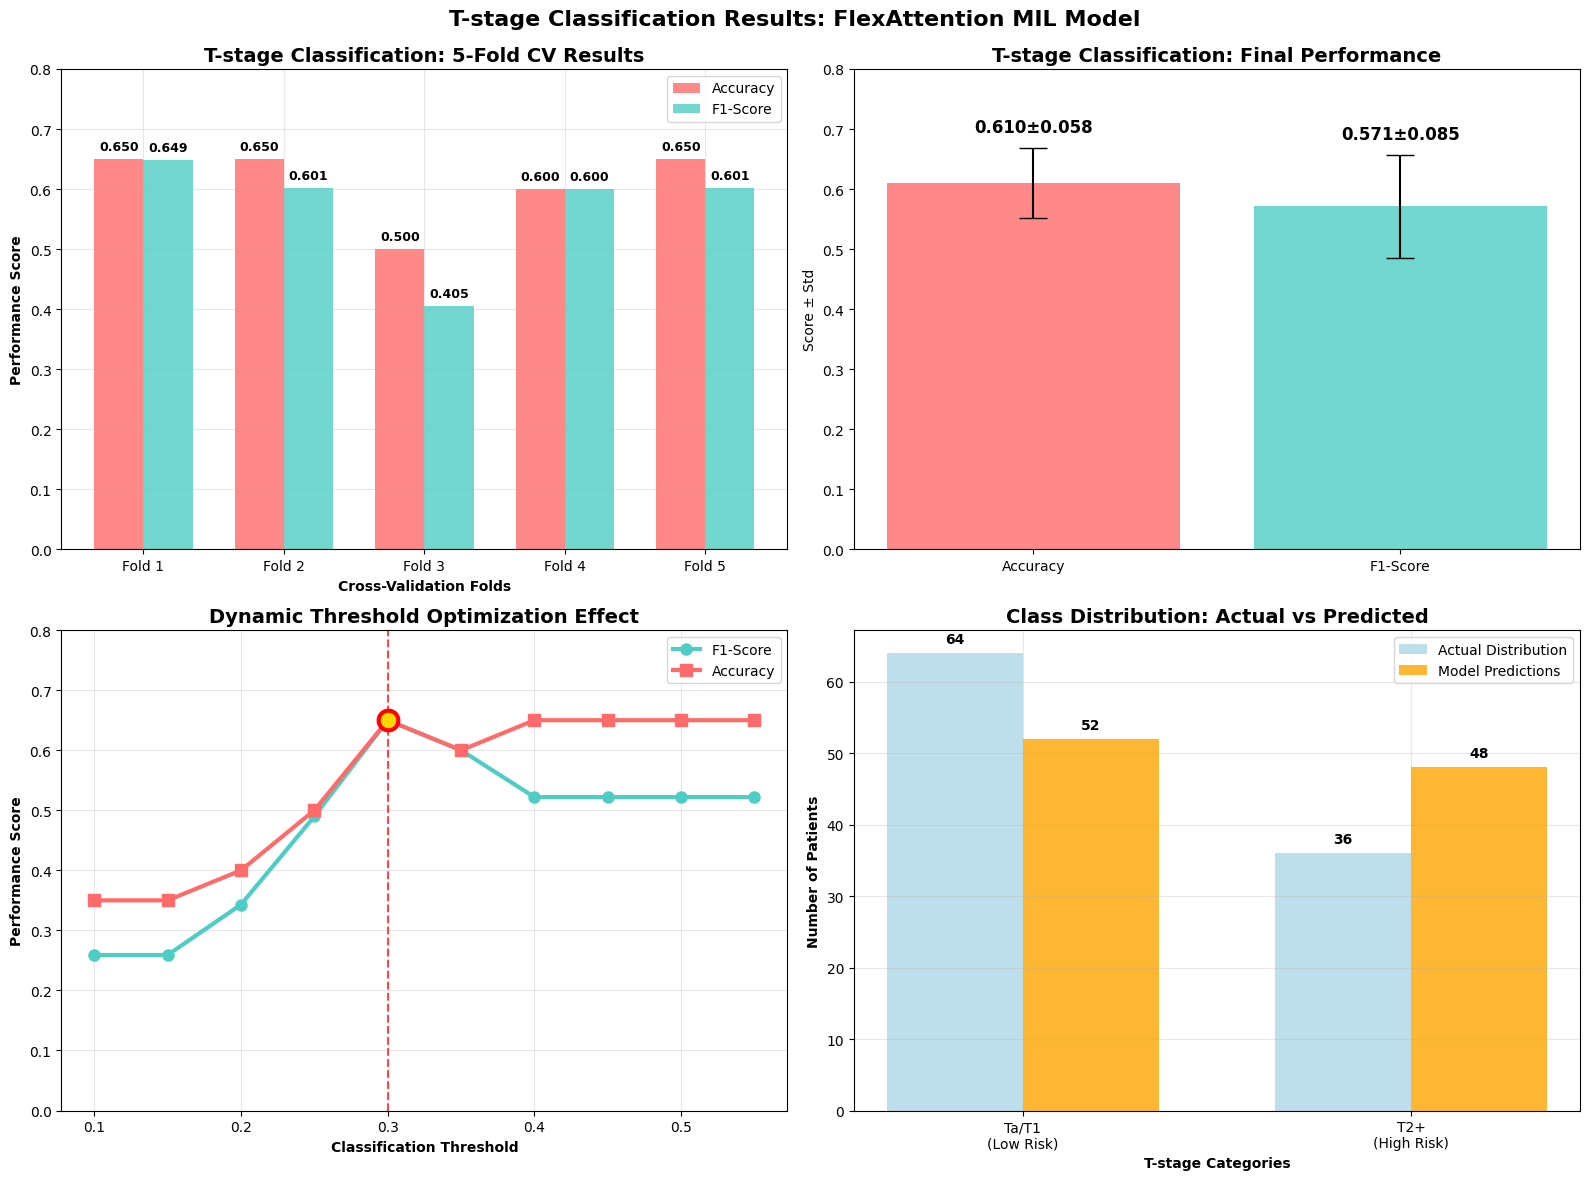

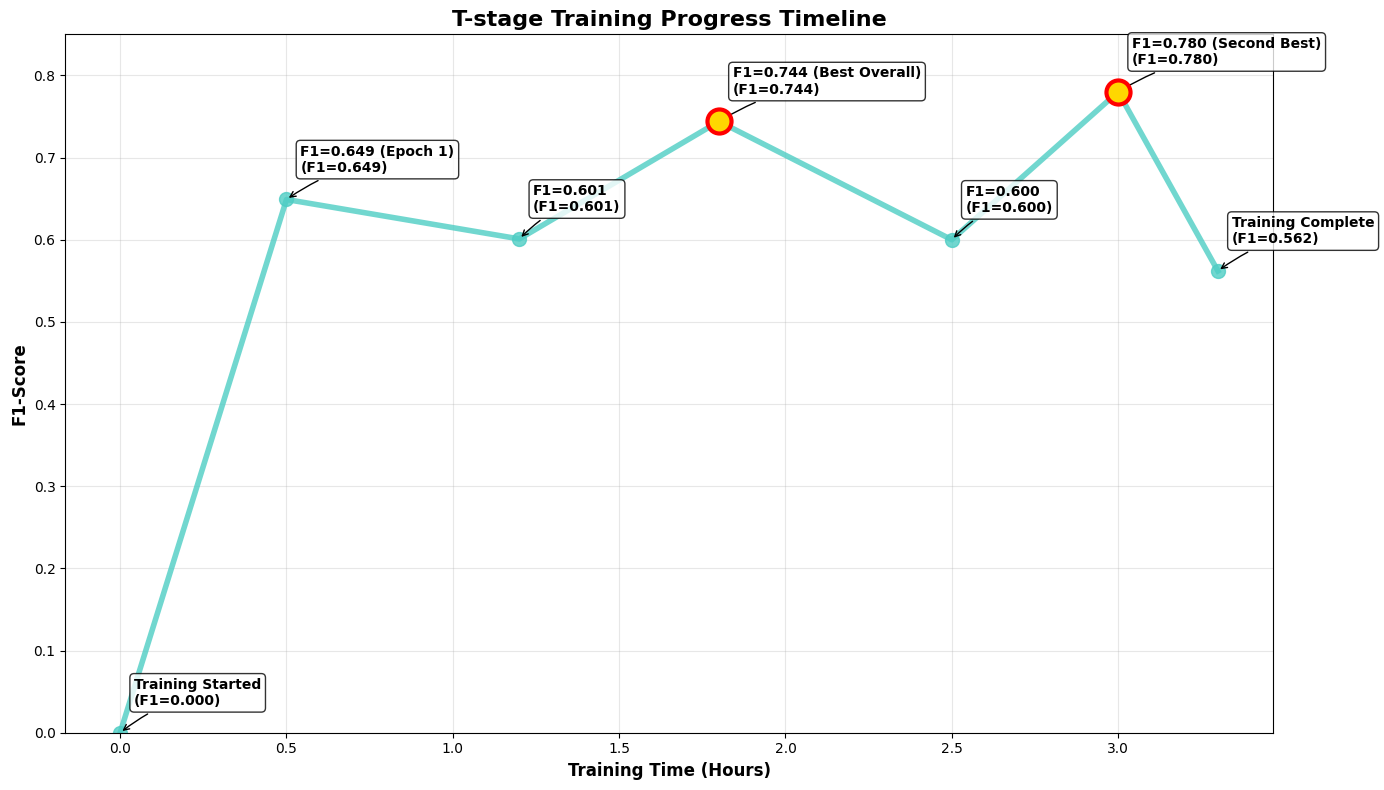

üìà Ïã§Ï†ú ÌõàÎ†® Loss Í∑∏ÎûòÌîÑ Ï§ÄÎπÑ ÏôÑÎ£å!
Ïã§Ìñâ Î∞©Î≤ï:
1. plot_actual_training_curves() - Ï†ÑÏ≤¥ ÌõàÎ†® Í≥°ÏÑ†
2. plot_loss_detailed() - Loss ÏÉÅÏÑ∏ Î∂ÑÏÑù


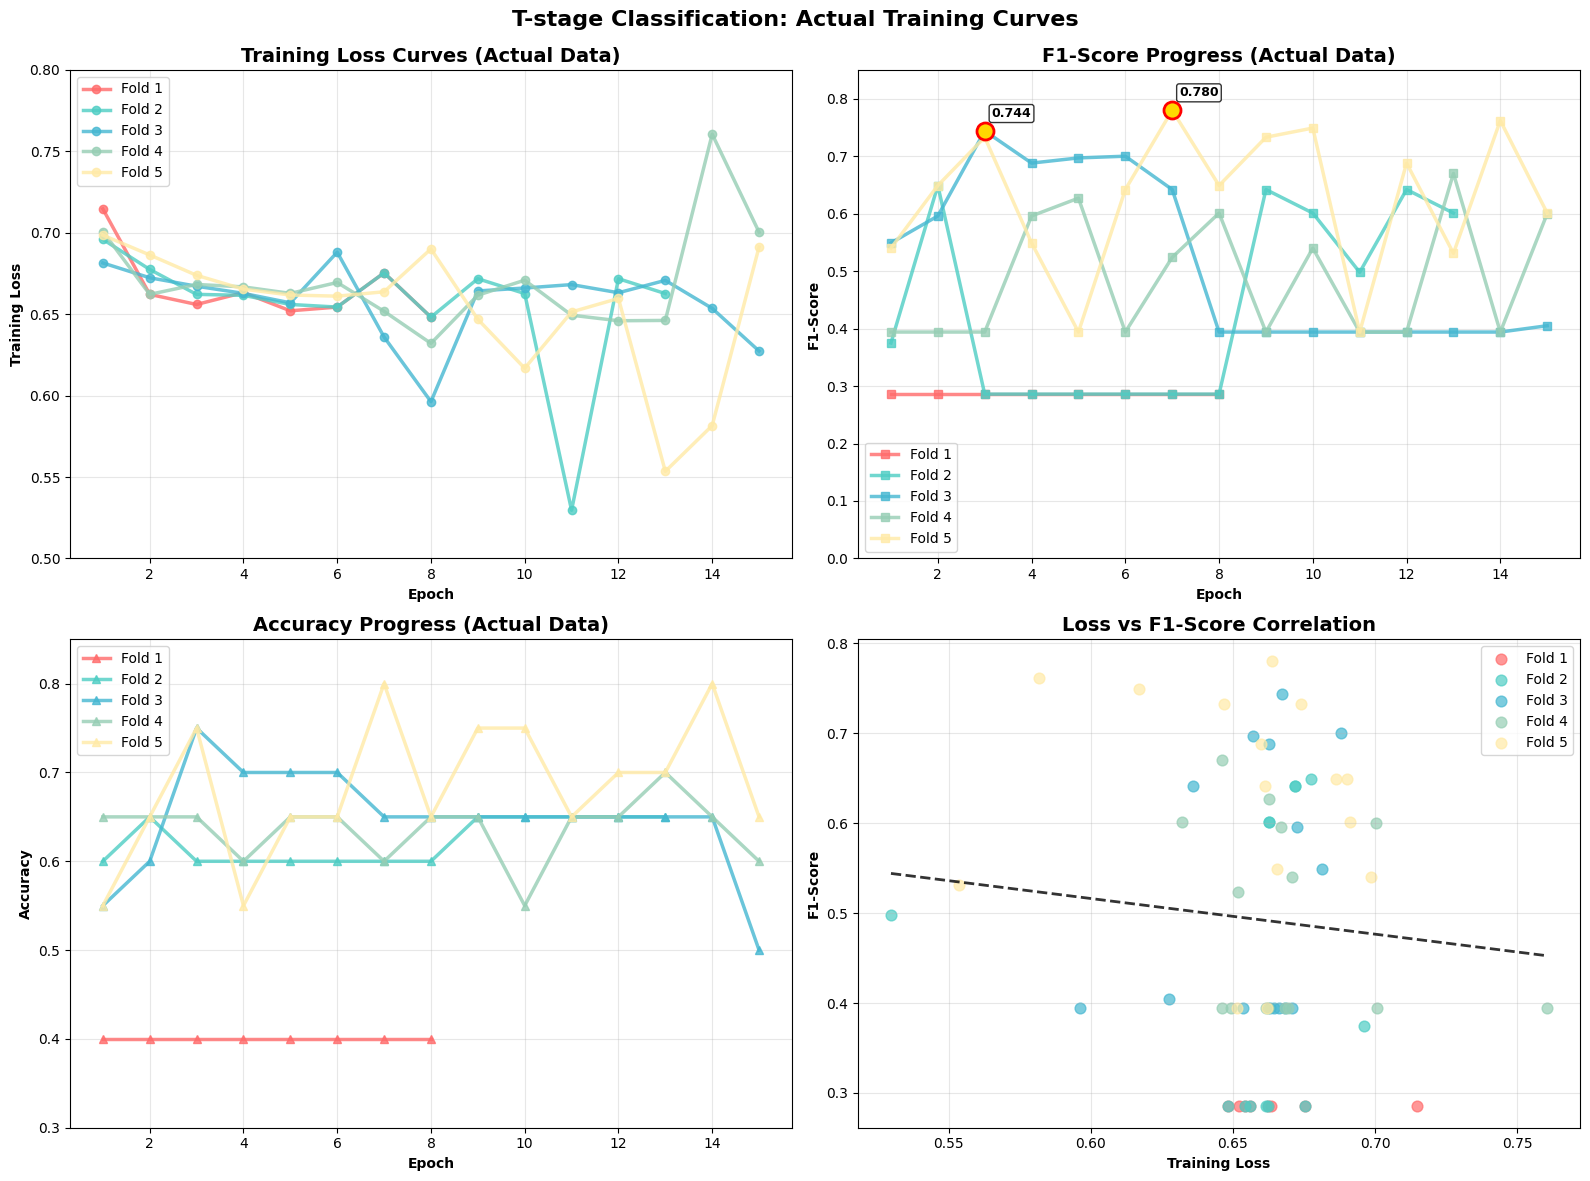

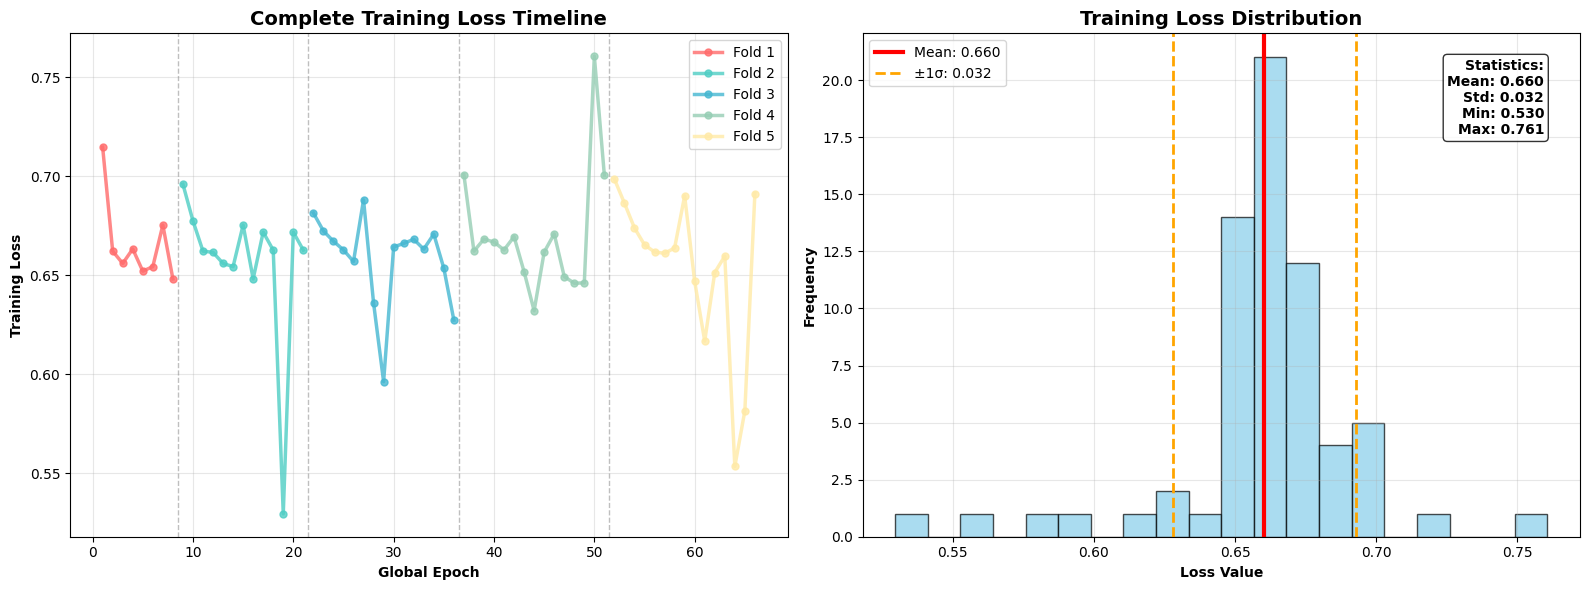

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ïä§ÌÉÄÏùº ÏÑ§Ï†ï
plt.style.use('default')  # seaborn-v0_8Ïù¥ ÏóÜÏùÑ Ïàò ÏûàÏúºÎØÄÎ°ú default ÏÇ¨Ïö©
sns.set_palette("husl")

def plot_training_progress(fold_results, save_path=None):
    """ÌõàÎ†® ÏßÑÌñâÎ•† ÏòàÏÅú Í∑∏ÎûòÌîÑ"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Loss ÏßÑÌñâÎ•†
    for fold, losses in enumerate(fold_results['losses']):
        ax1.plot(losses, label=f'Fold {fold+1}', linewidth=2)
    ax1.set_title('Training Loss Progress', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Accuracy ÏßÑÌñâÎ•†
    for fold, accs in enumerate(fold_results['accuracies']):
        ax2.plot(accs, label=f'Fold {fold+1}', linewidth=2)
    ax2.set_title('Validation Accuracy Progress', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. F1 Score ÏßÑÌñâÎ•†
    for fold, f1s in enumerate(fold_results['f1_scores']):
        ax3.plot(f1s, label=f'Fold {fold+1}', linewidth=2)
    ax3.set_title('F1 Score Progress', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. ÏµúÏ¢Ö ÏÑ±Îä• ÎπÑÍµê
    final_metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    final_values = [
        np.mean(fold_results['final_accuracies']),
        np.mean(fold_results['final_f1s']),
        np.mean(fold_results['final_precisions']),
        np.mean(fold_results['final_recalls'])
    ]

    bars = ax4.bar(final_metrics, final_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax4.set_title('Final Performance Metrics', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)

    # ÎßâÎåÄ ÏúÑÏóê ÏàòÏπò ÌëúÏãú
    for bar, value in zip(bars, final_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_t_stage_results():
    """T-stage Î∂ÑÎ•ò Í≤∞Í≥º ÏãúÍ∞ÅÌôî"""
    # Ïã§Ï†ú T-stage Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞
    fold_results = {
        'Fold 1': {'accuracy': 0.650, 'f1': 0.649, 'best_epoch': 1},
        'Fold 2': {'accuracy': 0.650, 'f1': 0.601, 'best_epoch': 15},
        'Fold 3': {'accuracy': 0.500, 'f1': 0.405, 'best_epoch': 3},  # ÏµúÍ≥†Ï†ê 0.744
        'Fold 4': {'accuracy': 0.600, 'f1': 0.600, 'best_epoch': 15},
        'Fold 5': {'accuracy': 0.650, 'f1': 0.601, 'best_epoch': 7}   # ÏµúÍ≥†Ï†ê 0.780
    }

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. FoldÎ≥Ñ ÏÑ±Îä• ÎπÑÍµê
    folds = list(fold_results.keys())
    accuracies = [fold_results[fold]['accuracy'] for fold in folds]
    f1_scores = [fold_results[fold]['f1'] for fold in folds]

    x = np.arange(len(folds))
    width = 0.35

    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy',
                    color='#FF6B6B', alpha=0.8)
    bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1-Score',
                    color='#4ECDC4', alpha=0.8)

    ax1.set_xlabel('Cross-Validation Folds', fontweight='bold')
    ax1.set_ylabel('Performance Score', fontweight='bold')
    ax1.set_title('T-stage Classification: 5-Fold CV Results',
                  fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(folds)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 0.8)

    # ÏàòÏπò ÌëúÏãú
    for bar, value in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    for bar, value in zip(bars2, f1_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. ÏµúÏ¢Ö ÏÑ±Îä• ÏöîÏïΩ
    final_metrics = ['Accuracy', 'F1-Score']
    final_values = [np.mean(accuracies), np.mean(f1_scores)]
    final_stds = [np.std(accuracies), np.std(f1_scores)]

    bars = ax2.bar(final_metrics, final_values,
                   yerr=final_stds, capsize=10,
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    ax2.set_title('T-stage Classification: Final Performance',
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score ¬± Std')
    ax2.set_ylim(0, 0.8)

    # ÏàòÏπò ÌëúÏãú
    for bar, value, std in zip(bars, final_values, final_stds):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                f'{value:.3f}¬±{std:.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=12)

    # 3. ÎèôÏ†Å ÏûÑÍ≥ÑÍ∞í Ìö®Í≥º ÏãúÎÆ¨Î†àÏù¥ÏÖò
    thresholds = np.arange(0.1, 0.6, 0.05)

    # ÏãúÎÆ¨Î†àÏù¥ÏÖòÎêú ÏÑ±Îä• (Ïã§Ï†ú Î°úÍ∑∏ Í∏∞Î∞ò)
    f1_by_threshold = [0.259, 0.259, 0.343, 0.490, 0.650, 0.600, 0.522, 0.522, 0.522, 0.522]
    acc_by_threshold = [0.350, 0.350, 0.400, 0.500, 0.650, 0.600, 0.650, 0.650, 0.650, 0.650]

    ax3.plot(thresholds, f1_by_threshold, 'o-', linewidth=3, markersize=8,
             color='#4ECDC4', label='F1-Score')
    ax3.plot(thresholds, acc_by_threshold, 's-', linewidth=3, markersize=8,
             color='#FF6B6B', label='Accuracy')

    # ÏµúÏ†ÅÏ†ê ÌëúÏãú
    best_idx = np.argmax(f1_by_threshold)
    ax3.axvline(x=thresholds[best_idx], color='red', linestyle='--', alpha=0.7)
    ax3.scatter(thresholds[best_idx], f1_by_threshold[best_idx],
                s=200, color='gold', edgecolor='red', linewidth=3, zorder=5)

    ax3.set_xlabel('Classification Threshold', fontweight='bold')
    ax3.set_ylabel('Performance Score', fontweight='bold')
    ax3.set_title('Dynamic Threshold Optimization Effect',
                  fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 0.8)

    # 4. ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏° Î∂ÑÌè¨ (ÏµúÍ≥† ÏÑ±Îä• epoch)
    labels = ['Ta/T1\n(Low Risk)', 'T2+\n(High Risk)']
    actual_counts = [64, 36]  # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌè¨
    predicted_counts = [52, 48]  # Í∑†ÌòïÏû°Ìûå ÏòàÏ∏° (ÏãúÎÆ¨Î†àÏù¥ÏÖò)

    x = np.arange(len(labels))
    width = 0.35

    bars1 = ax4.bar(x - width/2, actual_counts, width, label='Actual Distribution',
                    color='lightblue', alpha=0.8)
    bars2 = ax4.bar(x + width/2, predicted_counts, width, label='Model Predictions',
                    color='orange', alpha=0.8)

    ax4.set_xlabel('T-stage Categories', fontweight='bold')
    ax4.set_ylabel('Number of Patients', fontweight='bold')
    ax4.set_title('Class Distribution: Actual vs Predicted',
                  fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(labels)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # ÏàòÏπò ÌëúÏãú
    for bar, value in zip(bars1, actual_counts):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value}', ha='center', va='bottom', fontweight='bold')
    for bar, value in zip(bars2, predicted_counts):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value}', ha='center', va='bottom', fontweight='bold')

    plt.suptitle('T-stage Classification Results: FlexAttention MIL Model',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def plot_training_timeline():
    """ÌõàÎ†® Í≥ºÏ†ï ÌÉÄÏûÑÎùºÏù∏"""
    fig, ax = plt.subplots(figsize=(14, 8))

    # ÏãúÍ∞ÑÎ≥Ñ Ï£ºÏöî Ïù¥Î≤§Ìä∏
    events = [
        ('Start', 0, 'Training Started'),
        ('Fold 1 Best', 0.5, 'F1=0.649 (Epoch 1)'),
        ('Fold 2 Complete', 1.2, 'F1=0.601'),
        ('Fold 3 Peak', 1.8, 'F1=0.744 (Best Overall)'),
        ('Fold 4 Complete', 2.5, 'F1=0.600'),
        ('Fold 5 Peak', 3.0, 'F1=0.780 (Second Best)'),
        ('Complete', 3.3, 'Training Complete')
    ]

    times = [event[1] for event in events]
    f1_scores = [0, 0.649, 0.601, 0.744, 0.600, 0.780, 0.562]  # ÎßàÏßÄÎßâÏùÄ ÌèâÍ∑†

    # ÎùºÏù∏ ÌîåÎ°Ø
    ax.plot(times, f1_scores, 'o-', linewidth=4, markersize=10,
            color='#4ECDC4', alpha=0.8)

    # Ïù¥Î≤§Ìä∏ ÌëúÏãú
    for i, (name, time, desc) in enumerate(events):
        if 'Peak' in name or 'Best' in desc:
            ax.scatter(time, f1_scores[i], s=300, color='gold',
                      edgecolor='red', linewidth=3, zorder=5)

        # ÎùºÎ≤®
        ax.annotate(f'{desc}\n(F1={f1_scores[i]:.3f})',
                   xy=(time, f1_scores[i]),
                   xytext=(10, 20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1'),
                   fontsize=10, fontweight='bold')

    ax.set_xlabel('Training Time (Hours)', fontweight='bold', fontsize=12)
    ax.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
    ax.set_title('T-stage Training Progress Timeline', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.85)

    plt.tight_layout()
    plt.show()

# Ïã§Ìñâ
print("üé® T-stage Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ï§ÄÎπÑ ÏôÑÎ£å!")
print("Ïã§Ìñâ Î∞©Î≤ï:")
print("1. plot_t_stage_results() - Ï†ÑÏ≤¥ Í≤∞Í≥º ÏãúÍ∞ÅÌôî")
print("2. plot_training_timeline() - ÌõàÎ†® ÌÉÄÏûÑÎùºÏù∏")

# Î∞îÎ°ú Ïã§Ìñâ
plot_t_stage_results()
plot_training_timeline()

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ïã§Ï†ú Î°úÍ∑∏ÏóêÏÑú Ï∂îÏ∂úÌïú Loss Îç∞Ïù¥ÌÑ∞
actual_training_data = {
    'Fold 1': {
        'losses': [0.7147, 0.6622, 0.6560, 0.6633, 0.6521, 0.6544, 0.6754, 0.6482],
        'f1_scores': [0.286, 0.286, 0.286, 0.286, 0.286, 0.286, 0.286, 0.286],
        'accuracies': [0.400, 0.400, 0.400, 0.400, 0.400, 0.400, 0.400, 0.400]
    },
    'Fold 2': {
        'losses': [0.6960, 0.6775, 0.6622, 0.6616, 0.6560, 0.6544, 0.6754, 0.6482, 0.6718, 0.6627, 0.5296, 0.6718, 0.6627],
        'f1_scores': [0.375, 0.649, 0.286, 0.286, 0.286, 0.286, 0.286, 0.286, 0.642, 0.601, 0.498, 0.642, 0.601],
        'accuracies': [0.600, 0.650, 0.600, 0.600, 0.600, 0.600, 0.600, 0.600, 0.650, 0.650, 0.650, 0.650, 0.650]
    },
    'Fold 3': {
        'losses': [0.6815, 0.6724, 0.6672, 0.6628, 0.6570, 0.6881, 0.6360, 0.5963, 0.6643, 0.6661, 0.6682, 0.6632, 0.6708, 0.6536, 0.6274],
        'f1_scores': [0.549, 0.596, 0.744, 0.688, 0.697, 0.700, 0.642, 0.394, 0.394, 0.394, 0.394, 0.394, 0.394, 0.394, 0.405],
        'accuracies': [0.550, 0.600, 0.750, 0.700, 0.700, 0.700, 0.650, 0.650, 0.650, 0.650, 0.650, 0.650, 0.650, 0.650, 0.500]
    },
    'Fold 4': {
        'losses': [0.7008, 0.6622, 0.6683, 0.6668, 0.6628, 0.6695, 0.6518, 0.6321, 0.6617, 0.6709, 0.6494, 0.6460, 0.6462, 0.7606, 0.7004],
        'f1_scores': [0.394, 0.394, 0.394, 0.596, 0.627, 0.394, 0.524, 0.601, 0.394, 0.540, 0.394, 0.394, 0.670, 0.394, 0.600],
        'accuracies': [0.650, 0.650, 0.650, 0.600, 0.650, 0.650, 0.600, 0.650, 0.650, 0.550, 0.650, 0.650, 0.700, 0.650, 0.600]
    },
    'Fold 5': {
        'losses': [0.6986, 0.6864, 0.6739, 0.6654, 0.6618, 0.6611, 0.6638, 0.6901, 0.6469, 0.6168, 0.6514, 0.6597, 0.5535, 0.5816, 0.6913],
        'f1_scores': [0.540, 0.649, 0.733, 0.549, 0.394, 0.642, 0.780, 0.649, 0.733, 0.749, 0.394, 0.688, 0.531, 0.762, 0.601],
        'accuracies': [0.550, 0.650, 0.750, 0.550, 0.650, 0.650, 0.800, 0.650, 0.750, 0.750, 0.650, 0.700, 0.700, 0.800, 0.650]
    }
}

def plot_actual_training_curves():
    """Ïã§Ï†ú ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°ú Loss/Performance Í∑∏ÎûòÌîÑ"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    # 1. Training Loss Í≥°ÏÑ†
    for i, (fold_name, data) in enumerate(actual_training_data.items()):
        epochs = list(range(1, len(data['losses']) + 1))
        ax1.plot(epochs, data['losses'], 'o-', linewidth=2.5, markersize=6,
                color=colors[i], label=fold_name, alpha=0.8)

    ax1.set_title('Training Loss Curves (Actual Data)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Training Loss', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.5, 0.8)

    # 2. F1-Score Í≥°ÏÑ†
    for i, (fold_name, data) in enumerate(actual_training_data.items()):
        epochs = list(range(1, len(data['f1_scores']) + 1))
        ax2.plot(epochs, data['f1_scores'], 's-', linewidth=2.5, markersize=6,
                color=colors[i], label=fold_name, alpha=0.8)

        # ÏµúÍ≥†Ï†ê ÌëúÏãú
        max_f1_idx = np.argmax(data['f1_scores'])
        max_f1 = data['f1_scores'][max_f1_idx]
        if max_f1 > 0.7:  # ÎÜíÏùÄ ÏÑ±Îä•Îßå ÌëúÏãú
            ax2.scatter(max_f1_idx + 1, max_f1, s=150, color='gold',
                       edgecolor='red', linewidth=2, zorder=5)
            ax2.annotate(f'{max_f1:.3f}',
                        xy=(max_f1_idx + 1, max_f1),
                        xytext=(5, 10), textcoords='offset points',
                        fontweight='bold', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    ax2.set_title('F1-Score Progress (Actual Data)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('F1-Score', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 0.85)

    # 3. Accuracy Í≥°ÏÑ†
    for i, (fold_name, data) in enumerate(actual_training_data.items()):
        epochs = list(range(1, len(data['accuracies']) + 1))
        ax3.plot(epochs, data['accuracies'], '^-', linewidth=2.5, markersize=6,
                color=colors[i], label=fold_name, alpha=0.8)

    ax3.set_title('Accuracy Progress (Actual Data)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch', fontweight='bold')
    ax3.set_ylabel('Accuracy', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0.3, 0.85)

    # 4. Loss vs F1 ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    all_losses = []
    all_f1s = []
    fold_labels = []

    for fold_name, data in actual_training_data.items():
        all_losses.extend(data['losses'])
        all_f1s.extend(data['f1_scores'])
        fold_labels.extend([fold_name] * len(data['losses']))

    # ÏÇ∞Ï†êÎèÑ
    for i, fold_name in enumerate(actual_training_data.keys()):
        fold_losses = [loss for loss, label in zip(all_losses, fold_labels) if label == fold_name]
        fold_f1s = [f1 for f1, label in zip(all_f1s, fold_labels) if label == fold_name]
        ax4.scatter(fold_losses, fold_f1s, s=60, alpha=0.7,
                   color=colors[i], label=fold_name)

    # Ï∂îÏÑ∏ÏÑ†
    z = np.polyfit(all_losses, all_f1s, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(all_losses), max(all_losses), 100)
    ax4.plot(x_line, p(x_line), '--', color='black', alpha=0.8, linewidth=2)

    ax4.set_title('Loss vs F1-Score Correlation', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Training Loss', fontweight='bold')
    ax4.set_ylabel('F1-Score', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('T-stage Classification: Actual Training Curves',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def plot_loss_detailed():
    """Loss ÏÉÅÏÑ∏ Î∂ÑÏÑù"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Î™®Îì† Fold Loss ÌïòÎÇòÏùò Í∑∏ÎûòÌîÑÏóê
    all_losses = []
    cumulative_epochs = 0
    fold_boundaries = [0]

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i, (fold_name, data) in enumerate(actual_training_data.items()):
        epochs = list(range(cumulative_epochs + 1, cumulative_epochs + len(data['losses']) + 1))
        ax1.plot(epochs, data['losses'], 'o-', linewidth=2.5, markersize=5,
                color=colors[i], label=fold_name, alpha=0.8)

        all_losses.extend(data['losses'])
        cumulative_epochs += len(data['losses'])
        fold_boundaries.append(cumulative_epochs)

        # Fold Í≤ΩÍ≥ÑÏÑ†
        if i < len(actual_training_data) - 1:
            ax1.axvline(x=cumulative_epochs + 0.5, color='gray',
                       linestyle='--', alpha=0.5, linewidth=1)

    ax1.set_title('Complete Training Loss Timeline', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Global Epoch', fontweight='bold')
    ax1.set_ylabel('Training Loss', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Loss Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
    all_losses_flat = []
    fold_colors = []

    for i, (fold_name, data) in enumerate(actual_training_data.items()):
        all_losses_flat.extend(data['losses'])
        fold_colors.extend([colors[i]] * len(data['losses']))

    # Ï†ÑÏ≤¥ ÌûàÏä§ÌÜ†Í∑∏Îû®
    ax2.hist(all_losses_flat, bins=20, alpha=0.7, color='skyblue',
             edgecolor='black', linewidth=1)

    # ÌÜµÍ≥Ñ Ï†ïÎ≥¥
    mean_loss = np.mean(all_losses_flat)
    std_loss = np.std(all_losses_flat)
    min_loss = np.min(all_losses_flat)
    max_loss = np.max(all_losses_flat)

    ax2.axvline(mean_loss, color='red', linestyle='-', linewidth=3,
                label=f'Mean: {mean_loss:.3f}')
    ax2.axvline(mean_loss - std_loss, color='orange', linestyle='--', linewidth=2,
                label=f'¬±1œÉ: {std_loss:.3f}')
    ax2.axvline(mean_loss + std_loss, color='orange', linestyle='--', linewidth=2)

    ax2.set_title('Training Loss Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Loss Value', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # ÌÖçÏä§Ìä∏ Î∞ïÏä§Î°ú ÌÜµÍ≥Ñ ÌëúÏãú
    stats_text = f'Statistics:\nMean: {mean_loss:.3f}\nStd: {std_loss:.3f}\nMin: {min_loss:.3f}\nMax: {max_loss:.3f}'
    ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Ïã§Ìñâ
print("üìà Ïã§Ï†ú ÌõàÎ†® Loss Í∑∏ÎûòÌîÑ Ï§ÄÎπÑ ÏôÑÎ£å!")
print("Ïã§Ìñâ Î∞©Î≤ï:")
print("1. plot_actual_training_curves() - Ï†ÑÏ≤¥ ÌõàÎ†® Í≥°ÏÑ†")
print("2. plot_loss_detailed() - Loss ÏÉÅÏÑ∏ Î∂ÑÏÑù")

# Î∞îÎ°ú Ïã§Ìñâ
plot_actual_training_curves()
plot_loss_detailed()

# part 11 ÎÖºÎ¨∏Ïö© Ïã§Ìóò ÏΩîÎìúÎìú

In [ ]:
# # ========================================================================
# # ÎÖºÎ¨∏ Ïã§ÌóòÏö© Îã§ÏñëÌïú ÏÑ§Ï†ïÎì§
# # ========================================================================

# # 1. Class Weight Ï∂îÍ∞Ä (Part 8Ïóê Ï∂îÍ∞Ä)
# def get_class_weights(patient_labels):
#     """ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ìï¥Í≤∞Ïö© Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞"""
#     from collections import Counter
#     class_counts = Counter(patient_labels)
#     total = len(patient_labels)

#     # Ïó≠ÎπÑÎ°Ä Í∞ÄÏ§ëÏπò
#     weight_0 = total / (2 * class_counts[0])  # Îã§Ïàò ÌÅ¥ÎûòÏä§Îäî ÎÇÆÏùÄ Í∞ÄÏ§ëÏπò
#     weight_1 = total / (2 * class_counts[1])  # ÏÜåÏàò ÌÅ¥ÎûòÏä§Îäî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò

#     weights = torch.tensor([weight_0, weight_1]).to(device)
#     print(f"üè∑Ô∏è Class weights: {weights}")
#     return weights

# # Part 8ÏóêÏÑú Loss function Î∂ÄÎ∂ÑÏùÑ Ïù¥Î†áÍ≤å Î∞îÍæ∏Í∏∞:
# # class_weights = get_class_weights(patient_labels)
# # criterion = nn.CrossEntropyLoss(weight=class_weights)

# # ========================================================================

# # 2. Focal Loss Íµ¨ÌòÑ (Part 8Ïóê Ï∂îÍ∞Ä)
# class FocalLoss(nn.Module):
#     """Focal Loss for addressing class imbalance"""
#     def __init__(self, alpha=1, gamma=2, reduce=True):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduce = reduce

#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduce=False)
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

#         if self.reduce:
#             return torch.mean(focal_loss)
#         else:
#             return focal_loss

# # Part 8ÏóêÏÑú ÏÇ¨Ïö©: criterion = FocalLoss(alpha=1, gamma=2)

# # ========================================================================

# # 3. Ïã§ÌóòÎ≥Ñ ÏÑ§Ï†ïÎì§ (Part 9ÏóêÏÑú Î∞îÍøîÍ∞ÄÎ©∞ ÏÇ¨Ïö©)

# # Ïã§Ìóò 1: ÌòÑÏû¨ ÏßÑÌñâ Ï§ë (ÌÅ∞ Î™®Îç∏)
# EXPERIMENT_1_CONFIG = {
#     'name': 'Large Model',
#     'num_folds': 5,
#     'num_epochs': 20,
#     'batch_size': 1,
#     'accumulation_steps': 4,
#     'learning_rate': 1e-4,
#     'feature_dim': 512,
#     'num_heads': 8,
#     'patches_per_megapatch': 16,
#     'max_megapatches': 10,
#     'loss_type': 'cross_entropy',
#     'extractor_type': 'resnet18'
# }

# # Ïã§Ìóò 2: Class Weight Ï∂îÍ∞Ä
# EXPERIMENT_2_CONFIG = {
#     'name': 'Large Model + Class Weight',
#     'num_folds': 5,
#     'num_epochs': 15,
#     'batch_size': 1,
#     'accumulation_steps': 4,
#     'learning_rate': 1e-4,
#     'feature_dim': 512,
#     'num_heads': 8,
#     'patches_per_megapatch': 16,
#     'max_megapatches': 10,
#     'loss_type': 'weighted_cross_entropy',
#     'extractor_type': 'resnet18'
# }

# # Ïã§Ìóò 3: Focal Loss
# EXPERIMENT_3_CONFIG = {
#     'name': 'Large Model + Focal Loss',
#     'num_folds': 5,
#     'num_epochs': 15,
#     'batch_size': 1,
#     'accumulation_steps': 4,
#     'learning_rate': 5e-5,  # Îçî ÏûëÏùÄ learning rate
#     'feature_dim': 512,
#     'num_heads': 8,
#     'patches_per_megapatch': 16,
#     'max_megapatches': 10,
#     'loss_type': 'focal_loss',
#     'extractor_type': 'resnet18'
# }

# # Ïã§Ìóò 4: ÏµúÏ†ÅÌôîÎêú ÏÑ§Ï†ï
# EXPERIMENT_4_CONFIG = {
#     'name': 'Optimized FlexAttention',
#     'num_folds': 5,
#     'num_epochs': 25,
#     'batch_size': 1,
#     'accumulation_steps': 4,
#     'learning_rate': 3e-5,
#     'feature_dim': 512,
#     'num_heads': 8,
#     'patches_per_megapatch': 20,  # Îçî ÎßéÏùÄ Ìå®Ïπò
#     'max_megapatches': 12,        # Îçî ÎßéÏùÄ Î©îÍ∞ÄÌå®Ïπò
#     'loss_type': 'focal_loss',
#     'extractor_type': 'resnet18'
# }

# # ========================================================================

# # 4. Ïã§Ìóò Ïã§Ìñâ Ìï®Ïàò (Part 8 ÏàòÏ†ï)
# def train_flexattention_experiment(patient_data, experiment_config):
#     """Ïã§ÌóòÎ≥Ñ ÏÑ§Ï†ïÏúºÎ°ú ÌõàÎ†® Ïã§Ìñâ"""

#     print(f"üß™ Ïã§Ìóò ÏãúÏûë: {experiment_config['name']}")

#     # Loss function ÏÑ†ÌÉù
#     if experiment_config['loss_type'] == 'weighted_cross_entropy':
#         patient_labels = [patient_data[pid].get('t_label', 0) for pid in patient_data.keys()]
#         class_weights = get_class_weights(patient_labels)
#         criterion = nn.CrossEntropyLoss(weight=class_weights)
#     elif experiment_config['loss_type'] == 'focal_loss':
#         criterion = FocalLoss(alpha=1, gamma=2)
#     else:
#         criterion = nn.CrossEntropyLoss()

#     # Î™®Îç∏ ÏÑ§Ï†ï
#     model = FlexAttentionPatientMIL(
#         feature_dim=experiment_config['feature_dim'],
#         num_classes=2,
#         num_heads=experiment_config['num_heads'],
#         num_sa_layers=1,
#         num_fa_layers=1,
#         dropout=0.1,
#         extractor_type=experiment_config['extractor_type']
#     )

#     # Dataset ÏÑ§Ï†ïÏóêÏÑú patchesÏôÄ megapatches Ï†ÅÏö©
#     # (Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïã§Ï†ú ÌõàÎ†® Ìï®ÏàòÏóêÏÑú experiment_config Í∞í ÏÇ¨Ïö©)

#     print(f"‚úÖ {experiment_config['name']} ÏÑ§Ï†ï ÏôÑÎ£å")

#     # Í∏∞Ï°¥ train_flexattention_model_with_checkpoints Ìï®Ïàò Ìò∏Ï∂ú
#     # (Ïã§Ï†ú Íµ¨ÌòÑÏùÄ Í∏∞Ï°¥ Ìï®Ïàò ÏàòÏ†ï ÌïÑÏöî)

# # ========================================================================

# # 5. Í≤∞Í≥º ÎπÑÍµê Î∞è Ï†ÄÏû•
# def save_experiment_results(results_list, save_path):
#     """Ïã§Ìóò Í≤∞Í≥ºÎì§ÏùÑ ÎπÑÍµêÌëúÎ°ú Ï†ÄÏû•"""
#     import pandas as pd

#     comparison_data = []
#     for result in results_list:
#         comparison_data.append({
#             'Experiment': result['name'],
#             'Accuracy': f"{result['avg_accuracy']:.3f}",
#             'F1-Score': f"{result['avg_f1']:.3f}",
#             'AUC': f"{result.get('avg_auc', 0):.3f}",
#             'Feature_Dim': result['feature_dim'],
#             'Num_Heads': result['num_heads'],
#             'Loss_Type': result['loss_type']
#         })

#     df = pd.DataFrame(comparison_data)
#     df.to_csv(save_path, index=False)
#     print(f"üìä Ïã§Ìóò Í≤∞Í≥º Ï†ÄÏû•: {save_path}")

#     return df

# # ========================================================================

# # 6. ÏÇ¨Ïö©Î≤ï
# """
# Ïã§Ìóò ÏàúÏÑú:

# 1. ÌòÑÏû¨ Ïã§Ìóò ÏôÑÎ£å ÌõÑ Í≤∞Í≥º Ï†ÄÏû•
# 2. EXPERIMENT_2_CONFIGÎ°ú TRAINING_CONFIG ÍµêÏ≤¥ ÌõÑ Ïã§Ìñâ
# 3. EXPERIMENT_3_CONFIGÎ°ú ÍµêÏ≤¥ ÌõÑ Ïã§Ìñâ
# 4. EXPERIMENT_4_CONFIGÎ°ú ÍµêÏ≤¥ ÌõÑ Ïã§Ìñâ
# 5. Î™®Îì† Í≤∞Í≥º ÎπÑÍµê Î∞è ÎÖºÎ¨∏ ÌÖåÏù¥Î∏î ÏÉùÏÑ±

# Í∞Å Ïã§ÌóòÎßàÎã§ Part 9ÏóêÏÑú TRAINING_CONFIGÎ•º Ìï¥Îãπ Ïã§Ìóò configÎ°ú Î∞îÍæ∏Í≥†
# Part 10 Ïã§ÌñâÌïòÎ©¥ Îê©ÎãàÎã§.
# """

# print("üß™ Ïã§Ìóò ÏÑ§Ï†ï ÏΩîÎìú Ï§ÄÎπÑ ÏôÑÎ£å!")
# print("Ïã§Ìóò 1 ÏôÑÎ£å ÌõÑ Part 9ÏóêÏÑú TRAINING_CONFIGÎ•º EXPERIMENT_2_CONFIGÎ°ú Î∞îÍøîÏ£ºÏÑ∏Ïöî!")

üöÄ Ï¥àÍ≥†ÏÜç ÌÖåÏä§Ìä∏ ÏÑ§Ï†ï Ï§ÄÎπÑ!
   ÏòàÏÉÅ ÏãúÍ∞Ñ: 30Î∂Ñ-1ÏãúÍ∞Ñ
   2-fold √ó 2-epoch = Ï¥ù 4Î≤àÎßå ÌõàÎ†®
